In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scikits.odes.ode import ode
import time
import random

In [3]:
#Import local functions
sys.path.append('../functions')
from functions import nonlinearity, repression, activation

In [11]:
def solve_point(x, func):
    n1, n2, theta1, theta2, k1, k2 = x
    
    alpha1 = 1E-5
    alpha2 = 1E-2
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467

    int_time = 5E4
    t = np.linspace(0, int_time, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

    def dual_control_sundials(t, y, ydot):
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

    def upstream_repression_sundials(t, y, ydot):
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = k2 - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1) + k2
    
    def downstream_activation_sundials(t, y, ydot):
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = k1 - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = activation(y[1], k2, theta2, n2) + k1

    def no_control(t, y, ydot):
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = k1 - lam*y[2]
        ydot[3] = k2 - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = k1 + k2


    def loss_biological(j1, j2, alpha1, alpha2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

    if func == 'dc':
        solution = ode('cvode', dual_control_sundials, old_api=False).solve(t, y0)
    elif func == 'ur':
        solution = ode('cvode', upstream_repression_sundials, old_api=False).solve(t, y0)
    elif func == 'da':
        solution = ode('cvode', downstream_activation_sundials, old_api=False).solve(t, y0)
    elif func == 'nc':
        solution = ode('cvode', no_control, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return loss

In [12]:
def solve_patch_6d(init_conds, patch_size, step_sizes, func):
    n1, n2, theta1, theta2, k1, k2 = init_conds
    center_loss = solve_point(init_conds, func)
    #Sample randomly from hypersphere
    normal_deviates = np.random.normal(size=(6, patch_size))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius

    scaled_points = []
    for i in range(patch_size):
        scaled_points.append(list(step_sizes*points[:, i]  + init_conds))
    scaled_points = np.array(scaled_points)
    
    min_loss = center_loss
    new_k1 = k1; new_k2 = k2; new_theta1 = theta1; new_theta2 = theta2; new_n1 = n1; new_n2 = n2
    for n1, n2, theta1, theta2, k1, k2 in zip(scaled_points[:, 0], scaled_points[:, 1], scaled_points[:, 2], scaled_points[:, 3], scaled_points[:, 4], scaled_points[:, 5]):
        loss = solve_point([n1, n2, theta1, theta2, k1, k2], func)
        if bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
            if loss < min_loss:
                new_k1 = k1
                new_k2 = k2
                new_theta1 = theta1
                new_theta2 = theta2
                new_n1 = n1
                new_n2 = n2
                min_loss = loss
    return new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, min_loss

In [13]:
def bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
    if k1 <= 1E-3 and k2 <= 1E-3 and k1 >= 1E-7 and k2 >= 1E-7:
        if n1 <= 4 and n2 <= 4 and n1 >= 1 and n2 >= 1:
            if theta1 >= 0.001 and theta2 >= 0.001 and theta1 <= 10 and theta2 <= 10:
                return True
    else: return False

In [38]:
def gen_ics(N):
    #Set random seed
    np.random.seed(2022)
    ics = []
    for i in range(N):
        k1 = random.uniform(1E-7,1E-3)
        k2 = random.uniform(1E-7,1E-3)
        n1 = random.uniform(1,4)
        n2 = random.uniform(1,4)
        theta1 = random.uniform(0.001,10)
        theta2 = random.uniform(0.001,10)

        init_conds = np.array([n1,n2,theta1, theta2, k1, k2])
        ics.append(init_conds)
    return ics

#Randomize N=10 initial conditions 
ics = gen_ics(100)

In [39]:
total_results = pd.DataFrame(columns=['circuit','initialization', 'loss', 'k1_trace','k2_trace','n1_trace','n2_trace','theta1_trace','theta2_trace', 'time','loss_auc'])


In [40]:
#Set hyperparameters
func='dc'
num_epochs = 100
tolerance = 0.0004
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])
for j in range(len(ics)):
    print('Descent', j+1, 'of', len(ics))
    start_time = time.time()
    init_conds = ics[j]
    solve_patch_6d(init_conds, patch_size, step_sizes, func)
    next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes, func)

    losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

    for i in range(num_epochs):
        new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes, func)
        next_k1 = new_k1
        next_k2 = new_k2
        next_theta1 = new_theta1
        next_theta2 = new_theta2
        next_n1 = new_n1
        next_n2 = new_n2

        print('Epoch: ', i, 'Loss: ', loss)
        losses.append(loss)
        k1_trace.append(new_k1)
        k2_trace.append(new_k2)
        n1_trace.append(new_n1)
        n2_trace.append(new_n2)
        theta1_trace.append(new_theta1)
        theta2_trace.append(new_theta2)

        if losses[-2] - losses[-1] < tolerance:
            print('Terminating early at step', i, 'of ', num_epochs)
            break
    loss_auc = np.trapz(losses, dx=5)
    elapsed_time = time.time() - start_time
    results = pd.DataFrame({'circuit': func, 'initialization': j+1,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time, 'loss_auc':loss_auc})
    total_results = pd.concat([results, total_results])


Descent 1 of 100
Epoch:  0 Loss:  0.4044017182280284
Epoch:  1 Loss:  0.36928442613867346
Epoch:  2 Loss:  0.33027215604474625
Epoch:  3 Loss:  0.28855383010953595
Epoch:  4 Loss:  0.25512679693989254
Epoch:  5 Loss:  0.22005123016679717
Epoch:  6 Loss:  0.17639746059580402
Epoch:  7 Loss:  0.133020890876781
Epoch:  8 Loss:  0.09425810045769793
Epoch:  9 Loss:  0.07865168182509766


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  10 Loss:  0.07796380973865524



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07727081059884194



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.07657704569108524



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07555496373116147



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.07440949064592584



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07323484214977258



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  16 Loss:  0.07143146169057972



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  17 Loss:  0.06906856984638295



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  18 Loss:  0.06688153965933537



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  19 Loss:  0.06667328545584891
Terminating early at step 19 of  100
Descent 2 of 100
Epoch:  0 Loss:  0.08124410721988237


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  1 Loss:  0.08100139890641228
Terminating early at step 1 of  100
Descent 3 of 100
Epoch:  0 Loss:  0.30009795057411787
Epoch:  1 Loss:  0.24751528713039136
Epoch:  2 Loss:  0.19440630921815005
Epoch:  3 Loss:  0.16191486892289841


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  4 Loss:  0.1552129275406186



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.1507353687232827



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.1461017604116811



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.14115015682005141



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.13348657411567974



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.12374881676750488



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.112287611112278



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.10035510963389224



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.07710199727156217



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07370355464009026
Epoch:  14 Loss:  0.07307049352658689
Epoch:  15 Loss:  0.07269936918228467
Terminating early at step 15 of  100
Descent 4 of 100
Epoch:  0 Loss:  0.09768915493765622
Epoch:  1 Loss:  0.0731429768401888


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.07182918548192314



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07139361502311542



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06997613325951668



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06940103779257707



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.0675944194436602



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.06647609281250798
Epoch:  8 Loss:  0.06636597590851274
Terminating early at step 8 of  100
Descent 5 of 100
Epoch:  0 Loss:  0.18161568139647274
Epoch:  1 Loss:  0.0902450715718572
Epoch:  2 Loss:  0.0679219986351107
Epoch:  3 Loss:  0.0679219986351107
Terminating early at step 3 of  100
Descent 6 of 100
Epoch:  0 Loss:  0.13739876799440054
Epoch:  1 Loss:  0.11205221141632368
Epoch:  2 Loss:  0.096128407942


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.09437192303332487



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09173875982941926



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.08936144009829425



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.08617166597970677



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.08359904179061531
Epoch:  8 Loss:  0.08105384803803087
Epoch:  9 Loss:  0.07751007402817607
Epoch:  10 Loss:  0.07583175399927894
Epoch:  11 Loss:  0.07493929929007492
Epoch:  12 Loss:  0.07465367021395622
Terminating early at step 12 of  100
Descent 7 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.06910503509869304
Epoch:  1 Loss:  0.06863662104701423
Epoch:  2 Loss:  0.06816606349507348
Epoch:  3 Loss:  0.0674470187579271
Epoch:  4 Loss:  0.06661596723950246
Epoch:  5 Loss:  0.06581584389479228
Epoch:  6 Loss:  0.06512261348451603
Epoch:  7 Loss:  0.06464105226722162
Epoch:  8 Loss:  0.06447023657343785
Terminating early at step 8 of  100
Descent 8 of 100
Epoch:  0 Loss:  0.20335377399129176
Epoch:  1 Loss:  0.07096001748595603
Epoch:  2 Loss:  0.07092147531669843
Terminating early at step 2 of  100
Descent 9 of 100
Epoch:  0 Loss:  0.0988030319043387
Epoch:  1 Loss:  0.0901552808094315
Epoch:  2 Loss:  0.08333744493493711
Epoch:  3 Loss:  0.0803522568979263
Epoch:  4 Loss:  0.0783256647114422
Epoch:  5 Loss:  0.07661269147230275
Epoch:  6 Loss:  0.07500419458495844
Epoch:  7 Loss:  0.07352743423337027
Epoch:  8 Loss:  0.07169450668226558
Epoch:  9 Loss:  0.0702730147825865
Epoch:  10 Loss:  0.06874599539279966
Epoch:  11 Loss:  0.06742338160259045
Epoch:  12

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.0840763232091511



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07861204837758298



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07288218231853331



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.0695899190634652



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.06858173836096035
Epoch:  7 Loss:  0.06832355798291453
Terminating early at step 7 of  100
Descent 11 of 100
Epoch:  0 Loss:  0.20927159682226065
Epoch:  1 Loss:  0.17163114216845252
Epoch:  2 Loss:  0.12719829691459508
Epoch:  3 Loss:  0.10553435308164588


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  4 Loss:  0.10218699851428639



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.09962508228914667



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0962595064805854



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09297678524342098



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.08815590641304696



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08348189064099218



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.0792455055432088



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.07602926391947601
Epoch:  12 Loss:  0.07417388827351012
Epoch:  13 Loss:  0.07309248755608796
Epoch:  14 Loss:  0.07268462596426319
Epoch:  15 Loss:  0.07244330094377571
Terminating early at step 15 of  100
Descent 12 of 100
Epoch:  0 Loss:  0.47717835884588944
Epoch:  1 Loss:  0.4307978041638342
Epoch:  2 Loss:  0.38691310041701427
Epoch:  3 Loss:  0.3453139772789626
Epoch:  4 Loss:  0.3086528771722219
Epoch:  5 Loss:  0.2621672582537095
Epoch:  6 Loss:  0.2202394282984671
Epoch:  7 Loss:  0.1730104905998088
Epoch:  8 Loss:  0.12937452842088973


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  9 Loss:  0.12261217222915147



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.11601897009487039



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.1076843768912955



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.09744462999653951



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07443966732568028



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.07315218496178133
Epoch:  15 Loss:  0.07288319490294111
Terminating early at step 15 of  100
Descent 13 of 100
Epoch:  0 Loss:  0.11299867642534733
Epoch:  1 Loss:  0.08575825504610357


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.08432011813098635



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08293831466649366



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08076411865309116



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07939907464050928



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07565071259518741



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.0732049542482261



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/t

Epoch:  8 Loss:  0.07297913017652194
Terminating early at step 8 of  100
Descent 14 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.07482879606907623



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.07367503214740206



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.07187930537834936



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.07014890816001716



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.06736718477960606
Epoch:  5 Loss:  0.06585234901878725
Epoch:  6 Loss:  0.06554128129074653
Terminating early at step 6 of  100
Descent 15 of 100
Epoch:  0 Loss:  0.26760339376137837
Epoch:  1 Loss:  0.2336221166285949
Epoch:  2 Loss:  0.19907350587434453
Epoch:  3 Loss:  0.16862142512854253
Epoch:  4 Loss:  0.13935820148892367
Epoch:  5 Loss:  0.11636516018397756
Epoch:  6 Loss:  0.09888400461910526
Epoch:  7 Loss:  0.08708052701726685
Epoch:  8 Loss:  0.08303305213516655
Epoch:  9 Loss:  0.08215577677539875
Epoch:  10 Loss:  0.08100209009103285
Epoch:  11 Loss:  0.07996468534059378
Epoch:  12 Loss:  0.07877749505153295
Epoch:  13 Loss:  0.07814554508948718
Epoch:  14 Loss:  0.07729293878503404
Epoch:  15 Loss:  0.0763606007483211
Epoch:  16 Loss:  0.076172415487989
Terminating early at step 16 of  100
Descent 16 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.10730249281211307



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.10406509440235553



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.10170534059983546



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09753294294025192



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09340914464805411



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0894053472573155



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08524923018145042



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08210380029307904



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07595802956631553
Epoch:  9 Loss:  0.07432116247640955
Epoch:  10 Loss:  0.07333032935708897
Epoch:  11 Loss:  0.0731466434784626
Terminating early at step 11 of  100
Descent 17 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.0904632285956802



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.08873911000249005



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.0869770530636319



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.08575084439067185



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08378407149343593



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08263250346435831



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08098446054370838



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07834571872924544



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07608788433336229



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07438186891732779



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.0717336168177229



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.0689084060807266



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.06679911431199809
Epoch:  13 Loss:  0.06608452291101873
Epoch:  14 Loss:  0.06604422490188078
Terminating early at step 14 of  100
Descent 18 of 100
Epoch:  0 Loss:  0.11768931057185061
Epoch:  1 Loss:  0.09635083922107043
Epoch:  2 Loss:  0.07866719503034245
Epoch:  3 Loss:  0.0719353216602274
Epoch:  4 Loss:  0.07119473646307206
Epoch:  5 Loss:  0.07064117872880307
Epoch:  6 Loss:  0.06998463238279537
Epoch:  7 Loss:  0.06941720519738523
Epoch:  8 Loss:  0.06885509784971322
Epoch:  9 Loss:  0.06801513325239152
Epoch:  10 Loss:  0.06705661453383062
Epoch:  11 Loss:  0.0656791088451607
Epoch:  12 Loss:  0.06525551852438366
Epoch:  13 Loss:  0.06521471182646482
Terminating early at step 13 of  100
Descent 19 of 100
Epoch:  0 Loss:  0.24473311698158373
Epoch:  1 Loss:  0.2028070137907791
Epoch:  2 Loss:  0.15304809089503582
Epoch:  3 Loss:  0.11018737350604331
Epoch:  4 Loss:  0.07403943373016392


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  5 Loss:  0.0734164919262392



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07302292162343567
Terminating early at step 6 of  100
Descent 20 of 100
Epoch:  0 Loss:  0.3072685430692066
Epoch:  1 Loss:  0.2590669870411933
Epoch:  2 Loss:  0.21839175471458747
Epoch:  3 Loss:  0.17525873061479752
Epoch:  4 Loss:  0.1295588845760352
Epoch:  5 Loss:  0.1009870116783058


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  6 Loss:  0.09718993980165372



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.09252796194476108



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08626388067465485



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07885520391660254



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07084353670748171



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.06983830195921788
Epoch:  12 Loss:  0.06966745447903851
Terminating early at step 12 of  100
Descent 21 of 100
Epoch:  0 Loss:  0.10321376383937908
Epoch:  1 Loss:  0.09114763826857408


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.09050414098185386



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08918096511948212



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08853831459291711



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08700651498002093



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.08521738927611022



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08394843892709095



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.08142075593992264



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.07939756367174952



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07643182811312008



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.07382310471244741



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.06896236519897536



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06793391977719383
Epoch:  14 Loss:  0.06793391977719383
Terminating early at step 14 of  100
Descent 22 of 100
Epoch:  0 Loss:  0.2581212306145279
Epoch:  1 Loss:  0.21748663640595384
Epoch:  2 Loss:  0.18164687177022446
Epoch:  3 Loss:  0.14715398164056678
Epoch:  4 Loss:  0.11490857798562384
Epoch:  5 Loss:  0.10205237529245127


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  6 Loss:  0.09867889358326916



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.09298216862506636



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.08404633981291657
Epoch:  9 Loss:  0.0810525885183466
Epoch:  10 Loss:  0.07918655396296351
Epoch:  11 Loss:  0.07831361854820602
Epoch:  12 Loss:  0.07765975209613084
Epoch:  13 Loss:  0.07740206745479153
Terminating early at step 13 of  100
Descent 23 of 100
Epoch:  0 Loss:  0.16891339479799314
Epoch:  1 Loss:  0.13609830387474078
Epoch:  2 Loss:  0.10533204869703489
Epoch:  3 Loss:  0.07779535257423666


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.07552720659942785



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.07455607923157315



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.0731306826709285
Epoch:  7 Loss:  0.0720827398415354



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07047193877112759
Epoch:  9 Loss:  0.06955906834435018
Epoch:  10 Loss:  0.06927647579690335
Terminating early at step 10 of  100
Descent 24 of 100
Epoch:  0 Loss:  0.13314015044638952
Epoch:  1 Loss:  0.10772870655098185
Epoch:  2 Loss:  0.09791962956560016
Epoch:  3 Loss:  0.09318771638893525
Epoch:  4 Loss:  0.09064138497561686
Epoch:  5 Loss:  0.08879789774766993
Epoch:  6 Loss:  0.08676729931238503
Epoch:  7 Loss:  0.08500771870917977
Epoch:  8 Loss:  0.08380465493641234
Epoch:  9 Loss:  0.08261543946733735
Epoch:  10 Loss:  0.08102841038269361
Epoch:  11 Loss:  0.07984100406904923
Epoch:  12 Loss:  0.0783029718545863
Epoch:  13 Loss:  0.07738336260285711
Epoch:  14 Loss:  0.07657691220650094
Epoch:  15 Loss:  0.07530999457308243
Epoch:  16 Loss:  0.07463364996419673
Epoch:  17 Loss:  0.07356092269070015
Epoch:  18 Loss:  0.07263135477511662
Epoch:  19 Loss:  0.07194539108442934
Epoch:  20 Loss:  0.07089223076617117
Epoch:  21 Loss:  0.07002600853189636
Epoch:  

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.08720957712800252



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08640084195028858



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08483331805384503



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08317080029754753



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0817610190062252



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.0801252103857194



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07812988214147308



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07703591898497363



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07493259923747925



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07277773028425721



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.07069136752037156



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06874491765040663
Epoch:  14 Loss:  0.06827917012503015
Epoch:  15 Loss:  0.06823657972153417
Terminating early at step 15 of  100
Descent 26 of 100
Epoch:  0 Loss:  0.2680095633560935
Epoch:  1 Loss:  0.2324966634058124
Epoch:  2 Loss:  0.1978280327673483
Epoch:  3 Loss:  0.15949866526351614
Epoch:  4 Loss:  0.12907306573781363
Epoch:  5 Loss:  0.09241566138453575
Epoch:  6 Loss:  0.07564874259446698


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  7 Loss:  0.07502365947691705



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07464068200908641
Terminating early at step 8 of  100
Descent 27 of 100
Epoch:  0 Loss:  0.13216120305971085
Epoch:  1 Loss:  0.11850780853522383
Epoch:  2 Loss:  0.10951161607007684
Epoch:  3 Loss:  0.10261373153652475
Epoch:  4 Loss:  0.09733687568821735
Epoch:  5 Loss:  0.09335248331352906
Epoch:  6 Loss:  0.08998570087079176
Epoch:  7 Loss:  0.08729593495127275
Epoch:  8 Loss:  0.085539711971607
Epoch:  9 Loss:  0.08392350961936335
Epoch:  10 Loss:  0.08251024988362074
Epoch:  11 Loss:  0.08056341650115316
Epoch:  12 Loss:  0.07862541940872153
Epoch:  13 Loss:  0.07730324679812998
Epoch:  14 Loss:  0.07528778727673976
Epoch:  15 Loss:  0.07469664853015547
Epoch:  16 Loss:  0.07391689241736285
Epoch:  17 Loss:  0.07339857194566607
Epoch:  18 Loss:  0.07220828295019871
Epoch:  19 Loss:  0.0711148419840928
Epoch:  20 Loss:  0.0711148419840928
Terminating early at step 20 of  100
Descent 28 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.08486172605125127



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.07969472456624492



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07373000602529708
Epoch:  3 Loss:  0.06961084525527235
Epoch:  4 Loss:  0.06856019307061444
Epoch:  5 Loss:  0.06845945511753218
Terminating early at step 5 of  100
Descent 29 of 100
Epoch:  0 Loss:  0.12797351251035496
Epoch:  1 Loss:  0.12189286854462357
Epoch:  2 Loss:  0.11771484005138053
Epoch:  3 Loss:  0.11511711129841054
Epoch:  4 Loss:  0.11268405578166407
Epoch:  5 Loss:  0.11065950378895278
Epoch:  6 Loss:  0.10849518405302513
Epoch:  7 Loss:  0.10634488369383395
Epoch:  8 Loss:  0.10452157273573548
Epoch:  9 Loss:  0.10326938544780265
Epoch:  10 Loss:  0.10200842122423687
Epoch:  11 Loss:  0.1002586060039242
Epoch:  12 Loss:  0.09918660518678006
Epoch:  13 Loss:  0.09736654782426774
Epoch:  14 Loss:  0.09628394730342565
Epoch:  15 Loss:  0.09532335832866774
Epoch:  16 Loss:  0.09442994588263862
Epoch:  17 Loss:  0.09285403741069877
Epoch:  18 Loss:  0.09164029551234097
Epoch:  19 Loss:  0.08983374858013247
Epoch:  20 Loss:  0.0883985006897589
Epoch:  21 L

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  9 Loss:  0.08335988895530415



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08025370003953451



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07841605075216539



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07465101366085411



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07035810942148735



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.06733363380808516
Epoch:  15 Loss:  0.06668713635070202
Epoch:  16 Loss:  0.06668713635070202
Terminating early at step 16 of  100
Descent 36 of 100
Epoch:  0 Loss:  0.06816516966665058
Epoch:  1 Loss:  0.06808483443826334
Terminating early at step 1 of  100
Descent 37 of 100
Epoch:  0 Loss:  0.06940655780337479
Terminating early at step 0 of  100
Descent 38 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.08652569177823555



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.08514419903860339



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.08419091632880736



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08317353674224438



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08195821995725763



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0803086961067945



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07866765385600359



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07640625721331773



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07261456248493746



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07058978792398632



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07058978792398632
Terminating early at step 10 of  100
Descent 39 of 100
Epoch:  0 Loss:  0.37760547724833976
Epoch:  1 Loss:  0.335998599388668
Epoch:  2 Loss:  0.2957367290498001
Epoch:  3 Loss:  0.2558408655089341
Epoch:  4 Loss:  0.2183860225089863
Epoch:  5 Loss:  0.17083419464625071
Epoch:  6 Loss:  0.08722954794593049
Epoch:  7 Loss:  0.06928996675599691
Epoch:  8 Loss:  0.06928996675599691
Terminating early at step 8 of  100
Descent 40 of 100
Epoch:  0 Loss:  0.07737566433337445
Epoch:  1 Loss:  0.07101843411201145
Epoch:  2 Loss:  0.06923506731262041
Epoch:  3 Loss:  0.06861911541056072
Epoch:  4 Loss:  0.06817102910993669
Epoch:  5 Loss:  0.06781563885448126
Terminating early at step 5 of  100
Descent 41 of 100
Epoch:  0 Loss:  0.4727388780813818
Epoch:  1 Loss:  0.4304931598121597
Epoch:  2 Loss:  0.3911647021819819
Epoch:  3 Loss:  0.35027206779759484
Epoch:  4 Loss:  0.30523602056110005
Epoch:  5 Loss:  0.2649430630504315
Epoch:  6 Loss:  0.221381413826

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  10 Loss:  0.09255453520786885



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.09057026351564086



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08897268138724909



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.0870555809592416



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.08518924389183306



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.08300296072305009



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.08088967296727076



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.07888323071203082



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.0771172113775981



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.07549459463664436



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  20 Loss:  0.0730281910803003



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  21 Loss:  0.07075092352767898



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  22 Loss:  0.06789856029247794
Epoch:  23 Loss:  0.06789856029247794
Terminating early at step 23 of  100
Descent 42 of 100
Epoch:  0 Loss:  0.2023666676910919
Epoch:  1 Loss:  0.14800517063978458
Epoch:  2 Loss:  0.0895054320665076
Epoch:  3 Loss:  0.08684972432991445
Epoch:  4 Loss:  0.08443121479294716
Epoch:  5 Loss:  0.08231985702380429
Epoch:  6 Loss:  0.08017657410293846
Epoch:  7 Loss:  0.07849940328278357
Epoch:  8 Loss:  0.07778590404656192
Epoch:  9 Loss:  0.0745764760348485
Epoch:  10 Loss:  0.07319750789767016
Epoch:  11 Loss:  0.07237059789710402
Epoch:  12 Loss:  0.07165396930059781
Epoch:  13 Loss:  0.07055834221138446
Epoch:  14 Loss:  0.07007582910983962
Epoch:  15 Loss:  0.06898456026297266
Epoch:  16 Loss:  0.06898456026297266
Terminating early at step 16 of  100
Descent 43 of 100
Epoch:  0 Loss:  0.1967570511609657
Epoch:  1 Loss:  0.1553706442725939
Epoch:  2 Loss:  0.1301424948932337
Epoch:  3 Loss:  0.1139912703311915
Epoch:  4 Loss:  0.09999210786444894


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  11 Loss:  0.11464804056956518



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.1038573083678133



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.09503620397447306



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.08071120271837855



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  15 Loss:  0.0722479586003849
Epoch:  16 Loss:  0.07031777048846047
Epoch:  17 Loss:  0.07031777048846047
Terminating early at step 17 of  100
Descent 45 of 100
Epoch:  0 Loss:  0.1263022248433395
Epoch:  1 Loss:  0.11024569153283698
Epoch:  2 Loss:  0.09836819305394587
Epoch:  3 Loss:  0.09484548584891592
Epoch:  4 Loss:  0.09221217139459693
Epoch:  5 Loss:  0.09020368266922625
Epoch:  6 Loss:  0.08741512382373545
Epoch:  7 Loss:  0.08502484181639457
Epoch:  8 Loss:  0.08278049092679046
Epoch:  9 Loss:  0.07835859884635483
Epoch:  10 Loss:  0.07425198779417072
Epoch:  11 Loss:  0.0718050595775208
Epoch:  12 Loss:  0.0696854664065395
Epoch:  13 Loss:  0.06801035981655634
Epoch:  14 Loss:  0.06672312172083296
Epoch:  15 Loss:  0.06594549636421265
Epoch:  16 Loss:  0.06550699861053906
Epoch:  17 Loss:  0.06535363935542624
Terminating early at step 17 of  100
Descent 46 of 100
Epoch:  0 Loss:  0.11483694608870115
Epoch:  1 Loss:  0.09451169450762205
Epoch:  2 Loss:  0.0783504050889

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.09980195245664189



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09593984148646098



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09249153944655583



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08749453601460444



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.08375082899726297



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.0795077718609909



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07415008422802781
Epoch:  9 Loss:  0.07092346543728928
Epoch:  10 Loss:  0.06923821773816172
Epoch:  11 Loss:  0.06898571946430973
Terminating early at step 11 of  100
Descent 52 of 100
Epoch:  0 Loss:  0.39751722557062363
Epoch:  1 Loss:  0.3545067716002932
Epoch:  2 Loss:  0.31561046688408373
Epoch:  3 Loss:  0.2707121112033357
Epoch:  4 Loss:  0.23102847913056718
Epoch:  5 Loss:  0.1875968648696502
Epoch:  6 Loss:  0.14075018365409692
Epoch:  7 Loss:  0.10453762334450667


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  8 Loss:  0.09909037865556197



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.09607854436925656



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.09333295817647227



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.09051588928952203



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08754317660162139



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.08476958189224057



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.08229535970041965



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.08004416954076116



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.07757577855213149



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.0736628434038692



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  18 Loss:  0.06831347707596752
Epoch:  19 Loss:  0.06552608165556337
Epoch:  20 Loss:  0.06511220789747109
Epoch:  21 Loss:  0.06488563125982862
Terminating early at step 21 of  100
Descent 53 of 100
Epoch:  0 Loss:  0.5922051689642842
Epoch:  1 Loss:  0.5500142065444911
Epoch:  2 Loss:  0.507573406317409
Epoch:  3 Loss:  0.46190874115282116
Epoch:  4 Loss:  0.4142645894094291
Epoch:  5 Loss:  0.3587012193335896
Epoch:  6 Loss:  0.3070301099516507


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  7 Loss:  0.2769019404024426



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.25753908180775426



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.2382407683149097



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.21837994716178113



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.19204246165792



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.1572866117010163



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.12491736949354769



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.09979906679882117



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07658753383473825



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  16 Loss:  0.0760996698349405
Epoch:  17 Loss:  0.0760996698349405
Terminating early at step 17 of  100
Descent 54 of 100
Epoch:  0 Loss:  0.0928461562937656
Epoch:  1 Loss:  0.07143954130416597


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.07020920689767407



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.06855796353199874



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.06649672167237773



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06515411497537238
Epoch:  6 Loss:  0.06515411497537238
Terminating early at step 6 of  100
Descent 55 of 100
Epoch:  0 Loss:  0.534650803110126
Epoch:  1 Loss:  0.49103277670043116
Epoch:  2 Loss:  0.4445643539490941
Epoch:  3 Loss:  0.39652462425624513
Epoch:  4 Loss:  0.3523374658474712
Epoch:  5 Loss:  0.30554043104112993
Epoch:  6 Loss:  0.25470916539643335
Epoch:  7 Loss:  0.20510711489266537
Epoch:  8 Loss:  0.1610697384067309


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.1304096683293921



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.10414223782544743



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07348504939931082
Epoch:  12 Loss:  0.0712747423978268
Epoch:  13 Loss:  0.0712747423978268
Terminating early at step 13 of  100
Descent 56 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.08556729952849154
Epoch:  1 Loss:  0.08376957396606649
Epoch:  2 Loss:  0.08232995856699762
Epoch:  3 Loss:  0.07999959382459157
Epoch:  4 Loss:  0.07718078687527433
Epoch:  5 Loss:  0.07403950734547286
Epoch:  6 Loss:  0.06999514159118009
Epoch:  7 Loss:  0.06844323292424728
Epoch:  8 Loss:  0.0682224213728733
Terminating early at step 8 of  100
Descent 57 of 100
Epoch:  0 Loss:  0.0868252530158931
Epoch:  1 Loss:  0.0828726194321004
Epoch:  2 Loss:  0.08126476040204329
Epoch:  3 Loss:  0.0800979519186353
Epoch:  4 Loss:  0.07893265670123739
Epoch:  5 Loss:  0.077752042957494
Epoch:  6 Loss:  0.07705295367815995
Epoch:  7 Loss:  0.07628472819383009
Epoch:  8 Loss:  0.07540026847471179
Epoch:  9 Loss:  0.07455326246294113
Epoch:  10 Loss:  0.07399981550869188
Epoch:  11 Loss:  0.07292826561741308
Epoch:  12 Loss:  0.07252049195735688
Epoch:  13 Loss:  0.07184197242310768
Epoch:  14 Loss:  0.07092311922941955
Epoch:  15 Loss:  0.0703997485399896
Epoch:  16 Loss:  0.07

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.07167991892035952



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.0711915949073393



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06981975518164191
Epoch:  6 Loss:  0.06881218272837257
Epoch:  7 Loss:  0.06766639359790297
Epoch:  8 Loss:  0.06701473509946905
Epoch:  9 Loss:  0.06692037995822413
Terminating early at step 9 of  100
Descent 59 of 100
Epoch:  0 Loss:  0.13267101726551384
Epoch:  1 Loss:  0.098463095290907


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.09368926106779299



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09240673104573638



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.09222377685705078
Terminating early at step 4 of  100
Descent 60 of 100
Epoch:  0 Loss:  0.3552219568821262
Epoch:  1 Loss:  0.3058320776946922
Epoch:  2 Loss:  0.2584444078238934
Epoch:  3 Loss:  0.21543655632744582


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  4 Loss:  0.20302499688779735



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.19353698223389287



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.18682133391324218



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.17590864698301245



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.15153585436315448



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.12436726138049442



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08494411914518477



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07456071543109431



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.07350656891583143
Epoch:  13 Loss:  0.07297069172187533
Epoch:  14 Loss:  0.07297069172187533
Terminating early at step 14 of  100
Descent 61 of 100
Epoch:  0 Loss:  0.10280131691852608
Epoch:  1 Loss:  0.06582764046050577
Epoch:  2 Loss:  0.06495764258173665
Epoch:  3 Loss:  0.06495764258173665
Terminating early at step 3 of  100
Descent 62 of 100
Epoch:  0 Loss:  0.0813495902663908
Epoch:  1 Loss:  0.07770829505417559
Epoch:  2 Loss:  0.0763154487812086
Epoch:  3 Loss:  0.07520786380125738
Epoch:  4 Loss:  0.07396155686538124
Epoch:  5 Loss:  0.07301812604149983
Epoch:  6 Loss:  0.07191052011967602
Epoch:  7 Loss:  0.07086419194879176
Epoch:  8 Loss:  0.07001777759186596
Epoch:  9 Loss:  0.06926415359758338
Epoch:  10 Loss:  0.06874668701683666
Epoch:  11 Loss:  0.06826302864960163
Epoch:  12 Loss:  0.06796974537609847
Terminating early at step 12 of  100
Descent 63 of 100
Epoch:  0 Loss:  0.4106831056625752
Epoch:  1 Loss:  0.3649774827174875
Epoch:  2 Loss:  0.3

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  8 Loss:  0.0999348711350577



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.09667380047035208



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.09269212341717634



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08843894173941272



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08570158862865115



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.0828143075548549



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.07864289889273904



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07516818267055536



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.0714582256825461
Epoch:  17 Loss:  0.0701751891715289
Epoch:  18 Loss:  0.06922828153171465
Epoch:  19 Loss:  0.0692132516924598
Terminating early at step 19 of  100
Descent 64 of 100
Epoch:  0 Loss:  0.16560843531856673
Epoch:  1 Loss:  0.1411387830925615


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.139797902446094



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.13821327918917053



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.1367585678829187



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.1350573623786082



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.13261065854330262



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.1298600230378871



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.1256937881343407



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.12248971924599286



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.1174371998381564



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.10978216139514495



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.10056139021730284



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.09297552083918387
Epoch:  14 Loss:  0.08661885934564942
Epoch:  15 Loss:  0.08425407457075844
Epoch:  16 Loss:  0.08188748266527517
Epoch:  17 Loss:  0.08122583603974032
Epoch:  18 Loss:  0.07933796815726266
Epoch:  19 Loss:  0.07861364124076599
Epoch:  20 Loss:  0.07816292884265999
Epoch:  21 Loss:  0.07754165155063762
Epoch:  22 Loss:  0.07646876777957295
Epoch:  23 Loss:  0.07601096445052943
Epoch:  24 Loss:  0.07546245853933814
Epoch:  25 Loss:  0.07497381051709393
Epoch:  26 Loss:  0.07461243009400209
Terminating early at step 26 of  100
Descent 65 of 100
Epoch:  0 Loss:  0.18658419637230747
Epoch:  1 Loss:  0.15659458840537654
Epoch:  2 Loss:  0.12625976035872713
Epoch:  3 Loss:  0.09842440349681765
Epoch:  4 Loss:  0.07835419867419519
Epoch:  5 Loss:  0.07289062338391472
Epoch:  6 Loss:  0.06715948992191167
Epoch:  7 Loss:  0.06491935054217032
Epoch:  8 Loss:  0.06406386471924497
Epoch:  9 Loss:  0.06393333697346007
Terminating early at step 9 of  100
Descent

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.07387261345148681



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07208796935965055



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.0695674537663959
Epoch:  12 Loss:  0.06948209516950044
Terminating early at step 12 of  100
Descent 67 of 100
Epoch:  0 Loss:  0.26611372689169355
Epoch:  1 Loss:  0.22001629411197846
Epoch:  2 Loss:  0.1770101274488981
Epoch:  3 Loss:  0.13855188104351637
Epoch:  4 Loss:  0.09848792847976175


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.07665127982253148
Epoch:  6 Loss:  0.06996784724153746
Epoch:  7 Loss:  0.06996784724153746
Terminating early at step 7 of  100
Descent 68 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.0698010806685033
Terminating early at step 0 of  100
Descent 69 of 100
Epoch:  0 Loss:  0.06667224423587645
Epoch:  1 Loss:  0.06526784230476787
Epoch:  2 Loss:  0.06452956538491178
Epoch:  3 Loss:  0.06394203071766373
Epoch:  4 Loss:  0.06354032583907138
Epoch:  5 Loss:  0.06313223155286753
Epoch:  6 Loss:  0.06282560897217604
Terminating early at step 6 of  100
Descent 70 of 100
Epoch:  0 Loss:  0.15083213283311442
Epoch:  1 Loss:  0.14495296534803864
Epoch:  2 Loss:  0.1408989365390615
Epoch:  3 Loss:  0.13933473031993582
Epoch:  4 Loss:  0.13476067678602247
Epoch:  5 Loss:  0.13167691107397056
Epoch:  6 Loss:  0.12956594842220948
Epoch:  7 Loss:  0.1275715218447389
Epoch:  8 Loss:  0.12501889509530104
Epoch:  9 Loss:  0.12213813734591791
Epoch:  10 Loss:  0.12213813734591791
Terminating early at step 10 of  100
Descent 71 of 100
Epoch:  0 Loss:  0.3438009371861607
Epoch:  1 Loss:  0.32052617980261866
Epoch:  2 Loss:  0.298942595867459
Epoch:  3 Loss:  0.273980984

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  3 Loss:  0.3000638527843113



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.28379142176854505



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.26377934365045963



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.24305145911363224



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.21368543190592085



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.18719789426196096



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.1626873942131148



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.1291149388894234



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.09885903159821965



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07086917279361901
Epoch:  13 Loss:  0.06889115264283768
Epoch:  14 Loss:  0.06886959322827171
Terminating early at step 14 of  100
Descent 74 of 100
Epoch:  0 Loss:  0.23990340695464799
Epoch:  1 Loss:  0.20641460697200736
Epoch:  2 Loss:  0.1724062586997235
Epoch:  3 Loss:  0.14045509517118399
Epoch:  4 Loss:  0.11041804533912947
Epoch:  5 Loss:  0.08079820720878875
Epoch:  6 Loss:  0.06746989484128449


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  7 Loss:  0.06693920711356192



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.06641350436252091



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.06561046917481943



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06484589179552042



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06430314924451333



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.06372267451894509



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06312027294190221



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.06312027294190221
Terminating early at step 14 of  100
Descent 75 of 100
Epoch:  0 Loss:  0.07977384382551705
Epoch:  1 Loss:  0.07821045464053443
Epoch:  2 Loss:  0.07630892158203319
Epoch:  3 Loss:  0.0746181116096617
Epoch:  4 Loss:  0.07286520164739049
Epoch:  5 Loss:  0.07098186291768882
Epoch:  6 Loss:  0.06891196344863798
Epoch:  7 Loss:  0.0671476695922076
Epoch:  8 Loss:  0.06594888564875084
Epoch:  9 Loss:  0.06532346662079197
Epoch:  10 Loss:  0.06532346662079197
Terminating early at step 10 of  100
Descent 76 of 100
Epoch:  0 Loss:  0.20349890990451414
Epoch:  1 Loss:  0.17026545585729508
Epoch:  2 Loss:  0.1403131662758912
Epoch:  3 Loss:  0.11532326865940308
Epoch:  4 Loss:  0.08978433557381044


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.08619142730606152



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.08225867372430379



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.0797311104997935
Epoch:  8 Loss:  0.07294733161369088
Epoch:  9 Loss:  0.07161766707088907
Epoch:  10 Loss:  0.07020775167908319
Epoch:  11 Loss:  0.07020775167908319
Terminating early at step 11 of  100
Descent 77 of 100
Epoch:  0 Loss:  0.19585657589033573
Epoch:  1 Loss:  0.14834703089391799
Epoch:  2 Loss:  0.09940685691282213
Epoch:  3 Loss:  0.08411133939053853


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  4 Loss:  0.0834044363207379



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08272251711543113



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08219550173603497



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08137329811317175



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08057080434156398



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.0799360461184438



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07918441387478915



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07848969116215539



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07723973426389584



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07636954463919424



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.07451465147758685



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.0726777556875057



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.07061626533979817



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  17 Loss:  0.07020830528467219



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  18 Loss:  0.07020830528467219
Terminating early at step 18 of  100
Descent 78 of 100
Epoch:  0 Loss:  0.0650579262616736
Terminating early at step 0 of  100
Descent 79 of 100
Epoch:  0 Loss:  0.06828287640382102
Terminating early at step 0 of  100
Descent 80 of 100
Epoch:  0 Loss:  0.20058492100048025
Epoch:  1 Loss:  0.18020874190606712
Epoch:  2 Loss:  0.1594286455728112
Epoch:  3 Loss:  0.1422239678880041
Epoch:  4 Loss:  0.1267549220310684
Epoch:  5 Loss:  0.11315773527771653
Epoch:  6 Loss:  0.1010757063830726
Epoch:  7 Loss:  0.09133328236730685
Epoch:  8 Loss:  0.08183778677586796
Epoch:  9 Loss:  0.0760653028864083
Epoch:  10 Loss:  0.07375266471624599
Epoch:  11 Loss:  0.07266638703286826
Epoch:  12 Loss:  0.07179120318049569
Epoch:  13 Loss:  0.07083743061395564
Epoch:  14 Loss:  0.06986787754285505
Epoch:  15 Loss:  0.06896930707223177
Epoch:  16 Loss:  0.06845310463195864
Epoch:  17 Loss:  0.06809071548087653
Terminating early at step 17 of  100
Descent 81 of 100
Ep

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  8 Loss:  0.07236018028153418



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.0712310734207593



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07033187801392403



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.06930334541680339



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.06748519692471369



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06601931473014191



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.06449263922411146
Epoch:  15 Loss:  0.0635582747790502
Epoch:  16 Loss:  0.0631620092396113
Terminating early at step 16 of  100
Descent 82 of 100
Epoch:  0 Loss:  0.08032122129965616


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  1 Loss:  0.07566834553881463



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.07358485915709082
Epoch:  3 Loss:  0.07234983628369533
Epoch:  4 Loss:  0.07195174932930179
Terminating early at step 4 of  100
Descent 83 of 100
Epoch:  0 Loss:  0.1363523420542091
Epoch:  1 Loss:  0.09340480545720671


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.0782632147563454



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07735547074100863



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.0768576546378747



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07624633699523442



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07579757080579114



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07532424032333904



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07461599722931755



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07389703302419628



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07314847673349108



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07275805381020992
Terminating early at step 11 of  100
Descent 84 of 100
Epoch:  0 Loss:  0.3681123580482303
Epoch:  1 Loss:  0.33695802851279116
Epoch:  2 Loss:  0.29896752114806435
Epoch:  3 Loss:  0.26272935714851897
Epoch:  4 Loss:  0.22682954788657206
Epoch:  5 Loss:  0.19216897301116692
Epoch:  6 Loss:  0.16082798659663883
Epoch:  7 Loss:  0.12920535562109764
Epoch:  8 Loss:  0.10109603010204175
Epoch:  9 Loss:  0.0889199270227721


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  10 Loss:  0.08655595396415987



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.08477006866061576



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.08273473681513471
Epoch:  13 Loss:  0.08087610250514284
Epoch:  14 Loss:  0.07853191502534207
Epoch:  15 Loss:  0.0760941138715493
Epoch:  16 Loss:  0.0744612459890224
Epoch:  17 Loss:  0.072611733893603
Epoch:  18 Loss:  0.07156044249430862
Epoch:  19 Loss:  0.07074763031764629
Epoch:  20 Loss:  0.07009689522867138
Epoch:  21 Loss:  0.06960616097417095
Epoch:  22 Loss:  0.06889567647866113
Epoch:  23 Loss:  0.06843989964121797
Epoch:  24 Loss:  0.06797613891781917
Epoch:  25 Loss:  0.06769630117272013
Terminating early at step 25 of  100
Descent 85 of 100
Epoch:  0 Loss:  0.1263819322964443
Epoch:  1 Loss:  0.09284953693463219


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.09080926023465243



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08962098310725203



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08848847763477577



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08681967911189238



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08585879846884117



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08450629061941148



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.08228459544883006



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08103801109217493



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.0783855798179071



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07684331007898484



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07319159796568621



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06883383253995498



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.0685372992348237
Terminating early at step 14 of  100
Descent 86 of 100
Epoch:  0 Loss:  0.12667815190632684
Epoch:  1 Loss:  0.10798617436762584
Epoch:  2 Loss:  0.09325126570253456
Epoch:  3 Loss:  0.08578670301152996
Epoch:  4 Loss:  0.08429261958223316
Epoch:  5 Loss:  0.08331871046827104
Epoch:  6 Loss:  0.08229773842975324
Epoch:  7 Loss:  0.08090199652508707
Epoch:  8 Loss:  0.07929852784092184
Epoch:  9 Loss:  0.07777625631154941
Epoch:  10 Loss:  0.07615345077212077
Epoch:  11 Loss:  0.0745313834517836
Epoch:  12 Loss:  0.07311257019004302
Epoch:  13 Loss:  0.07234018698398728
Epoch:  14 Loss:  0.07200695060816308
Terminating early at step 14 of  100
Descent 87 of 100
Epoch:  0 Loss:  0.11637485219564458


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.10645194436188855



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.10339254041310125



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09869280749816395



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09583094252683008



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.09198833855063225



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08833871880413138



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.0835760267465976



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07883159445844992



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.07240885477541893
Epoch:  10 Loss:  0.06699747723634265
Epoch:  11 Loss:  0.06578954372742264
Epoch:  12 Loss:  0.06565059336279969
Terminating early at step 12 of  100
Descent 88 of 100
Epoch:  0 Loss:  0.06762597988669332
Epoch:  1 Loss:  0.06724973604212989
Terminating early at step 1 of  100
Descent 89 of 100
Epoch:  0 Loss:  0.480618127980301
Epoch:  1 Loss:  0.4227944162804297
Epoch:  2 Loss:  0.3657109703009507
Epoch:  3 Loss:  0.19606971821755068
Epoch:  4 Loss:  0.07266001834508758
Epoch:  5 Loss:  0.07252475985643916
Terminating early at step 5 of  100
Descent 90 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.15732820970521294
Epoch:  1 Loss:  0.1419222935616179
Epoch:  2 Loss:  0.13371374698892735
Epoch:  3 Loss:  0.12955383284318728
Epoch:  4 Loss:  0.12694387664757323
Epoch:  5 Loss:  0.125338601452184
Epoch:  6 Loss:  0.12381089875869708
Epoch:  7 Loss:  0.12222052389985026
Epoch:  8 Loss:  0.12064385827101698
Epoch:  9 Loss:  0.11876982796081978
Epoch:  10 Loss:  0.11722299504553191
Epoch:  11 Loss:  0.11535949773119439
Epoch:  12 Loss:  0.11372269824462986
Epoch:  13 Loss:  0.11216381432772696
Epoch:  14 Loss:  0.11093493632511744
Epoch:  15 Loss:  0.10985807893807192
Epoch:  16 Loss:  0.10908579037570579
Epoch:  17 Loss:  0.10787456947504578
Epoch:  18 Loss:  0.10667427762517348
Epoch:  19 Loss:  0.10541610626322022
Epoch:  20 Loss:  0.10429851454131356
Epoch:  21 Loss:  0.10301084550416598
Epoch:  22 Loss:  0.10224954871657277
Epoch:  23 Loss:  0.10139351599690044
Epoch:  24 Loss:  0.1003273320731114
Epoch:  25 Loss:  0.09965670229197439
Epoch:  26 Loss:  0.098450

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  0 Loss:  0.07918356691351439



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.07807670019899057



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07743032554393052



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.07655476103926868



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.07512836161965275



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07411773925068106



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.07262487830762403



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.07082847951315785



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.06975102317311832



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.06758045033037956
Epoch:  10 Loss:  0.06736499333982164
Terminating early at step 10 of  100
Descent 92 of 100
Epoch:  0 Loss:  0.38997163843920424
Epoch:  1 Loss:  0.3475979639470823
Epoch:  2 Loss:  0.3077474847136965
Epoch:  3 Loss:  0.2603019894773449
Epoch:  4 Loss:  0.21501557936244886
Epoch:  5 Loss:  0.171975130405353
Epoch:  6 Loss:  0.12662062864359158
Epoch:  7 Loss:  0.08856729903603539


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  8 Loss:  0.08378522818555782



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08365410358573418
Terminating early at step 9 of  100
Descent 93 of 100
Epoch:  0 Loss:  0.06576316025892336
Terminating early at step 0 of  100
Descent 94 of 100
Epoch:  0 Loss:  0.07975928478892137
Epoch:  1 Loss:  0.07633458513991653
Epoch:  2 Loss:  0.07434163848426832
Epoch:  3 Loss:  0.07308818164322209
Epoch:  4 Loss:  0.07264918990863699
Epoch:  5 Loss:  0.07179675412942152
Epoch:  6 Loss:  0.0714754579103056
Terminating early at step 6 of  100
Descent 95 of 100
Epoch:  0 Loss:  0.06793268007734606
Epoch:  1 Loss:  0.06727335424959213
Epoch:  2 Loss:  0.06727335424959213
Terminating early at step 2 of  100
Descent 96 of 100
Epoch:  0 Loss:  0.12950468017234135
Epoch:  1 Loss:  0.10859405700309191
Epoch:  2 Loss:  0.10471890932812501
Epoch:  3 Loss:  0.10279901859622603


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.10134562851258624



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.0995327695629829



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.09778821008204941
Epoch:  7 Loss:  0.09633758913828985
Epoch:  8 Loss:  0.09373635727352522
Epoch:  9 Loss:  0.0914023960252986
Epoch:  10 Loss:  0.08794092766055552
Epoch:  11 Loss:  0.0835953263731049
Epoch:  12 Loss:  0.07894902033106589
Epoch:  13 Loss:  0.07621090589634939
Epoch:  14 Loss:  0.07506105265125196
Epoch:  15 Loss:  0.07409225150682067
Epoch:  16 Loss:  0.07357958962077592
Epoch:  17 Loss:  0.07304080138479968
Epoch:  18 Loss:  0.07232703260950399
Epoch:  19 Loss:  0.07224301290060144
Terminating early at step 19 of  100
Descent 97 of 100
Epoch:  0 Loss:  0.0919859723567834
Epoch:  1 Loss:  0.08997530225189083
Epoch:  2 Loss:  0.08843951444230648
Epoch:  3 Loss:  0.08702113836733619
Epoch:  4 Loss:  0.08551486811136115
Epoch:  5 Loss:  0.0845059062559371
Epoch:  6 Loss:  0.08329803588780905
Epoch:  7 Loss:  0.08223869245935807
Epoch:  8 Loss:  0.08097437395317733
Epoch:  9 Loss:  0.08005473535236411
Epoch:  10 Loss:  0.07917394433721896
Epoch:  11 Lo

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  11 Loss:  0.14819065712239152



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.12618263691138745



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.09447599337586603



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.07503368666179831



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  15 Loss:  0.07316806314096497
Epoch:  16 Loss:  0.07306720189109671
Terminating early at step 16 of  100
Descent 99 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  0.08022394726903712



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.07928509900331997



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07799054916954126



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07750437925260131



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.07585468214287489



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07466045799473724



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07359807982310196



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07081093203927413



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06821245989322704



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.06605072585499427
Epoch:  10 Loss:  0.06597576127844061
Terminating early at step 10 of  100
Descent 100 of 100
Epoch:  0 Loss:  0.11070976259035073
Epoch:  1 Loss:  0.07964598467125422


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repea

Epoch:  2 Loss:  0.07848011076420433



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07723534404233007



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.07599909528563381



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0750940142678568
Epoch:  6 Loss:  0.07333911476974861



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07016750618629021



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.067934347870311



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.06698502098565089
Epoch:  10 Loss:  0.06690143869819398
Terminating early at step 10 of  100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



In [41]:
#Set hyperparameters
func='da'
num_epochs = 100
tolerance = 0.0004
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])
for j in range(len(ics)):
    print('Descent', j+1, 'of', len(ics))
    start_time = time.time()
    init_conds = ics[j]
    solve_patch_6d(init_conds, patch_size, step_sizes, func)
    next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes, func)

    losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

    for i in range(num_epochs):
        new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes, func)
        next_k1 = new_k1
        next_k2 = new_k2
        next_theta1 = new_theta1
        next_theta2 = new_theta2
        next_n1 = new_n1
        next_n2 = new_n2

        print('Epoch: ', i, 'Loss: ', loss)
        losses.append(loss)
        k1_trace.append(new_k1)
        k2_trace.append(new_k2)
        n1_trace.append(new_n1)
        n2_trace.append(new_n2)
        theta1_trace.append(new_theta1)
        theta2_trace.append(new_theta2)

        if losses[-2] - losses[-1] < tolerance:
            print('Terminating early at step', i, 'of ', num_epochs)
            break
    loss_auc = np.trapz(losses, dx=5)
    elapsed_time = time.time() - start_time
    results = pd.DataFrame({'circuit': func, 'initialization': j+1,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time, 'loss_auc':loss_auc})
    total_results = pd.concat([results, total_results])


Descent 1 of 100
Epoch:  0 Loss:  0.5124337192414776
Epoch:  1 Loss:  0.47137048236458207
Epoch:  2 Loss:  0.4244657977797051
Epoch:  3 Loss:  0.3779635275423833
Epoch:  4 Loss:  0.33249945272251635
Epoch:  5 Loss:  0.28115045415721607
Epoch:  6 Loss:  0.23170699357143418
Epoch:  7 Loss:  0.1789960921817431
Epoch:  8 Loss:  0.12199059767787905
Epoch:  9 Loss:  0.08033701092336026


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.07909212416478126



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07815653114499671



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.0775319689659717



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07714425393478729
Terminating early at step 13 of  100
Descent 2 of 100
Epoch:  0 Loss:  0.081074716912957


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  1 Loss:  0.08020905067824811



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07979055536862523



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.0796162431559978
Terminating early at step 3 of  100
Descent 3 of 100
Epoch:  0 Loss:  0.3064484729990028
Epoch:  1 Loss:  0.24919867230133544
Epoch:  2 Loss:  0.19164091435557423
Epoch:  3 Loss:  0.1623774308704038


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.15761290355199833



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.15289213908534777



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.14866864262872614



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.14360710540157864



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.13705888607440064



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.12899529815612926



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.11998403466909414



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.1106853134802975



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.09349985803526384



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06376635947826706



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06357379853433608
Terminating early at step 14 of  100
Descent 4 of 100
Epoch:  0 Loss:  0.11852331794493196
Epoch:  1 Loss:  0.0752808111528766


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.07299314632724635



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07185026194522806



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07084483811155412



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06988289326376183



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06950522339688689
Terminating early at step 6 of  100
Descent 5 of 100
Epoch:  0 Loss:  0.3819490751654934
Epoch:  1 Loss:  0.33356741366556614
Epoch:  2 Loss:  0.29342195592605796
Epoch:  3 Loss:  0.2421252627911918
Epoch:  4 Loss:  0.19311414154094386
Epoch:  5 Loss:  0.14566028340088966
Epoch:  6 Loss:  0.10324947849337586
Epoch:  7 Loss:  0.06320507966011081


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.0625098617054631



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06189422564805411



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06184507468110073
Terminating early at step 10 of  100
Descent 6 of 100
Epoch:  0 Loss:  0.17625155092597058
Epoch:  1 Loss:  0.1279009222362497
Epoch:  2 Loss:  0.09391940324337132


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.09230484423521679



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08955459951249951



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08683345291134514



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08343909262226103



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07949261075118



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07323483201900197



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.0661848479583851



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06360735680495913



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06360735680495913
Terminating early at step 11 of  100
Descent 7 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.06815246905607156



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.0674952565855915



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.06706230220384676



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.0664228862558893



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06608341086657865
Terminating early at step 4 of  100
Descent 8 of 100
Epoch:  0 Loss:  0.3126409554941133
Epoch:  1 Loss:  0.26481728149470757
Epoch:  2 Loss:  0.21648309165432944
Epoch:  3 Loss:  0.1736813396974815
Epoch:  4 Loss:  0.1252112972467188
Epoch:  5 Loss:  0.08561813181863129
Epoch:  6 Loss:  0.06313476362459924


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  7 Loss:  0.062009472563782794



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06182345604881668
Terminating early at step 8 of  100
Descent 9 of 100
Epoch:  0 Loss:  0.28808844415063306
Epoch:  1 Loss:  0.23583100558739
Epoch:  2 Loss:  0.18352752723475116
Epoch:  3 Loss:  0.13312310671440655
Epoch:  4 Loss:  0.08904115784975926


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  5 Loss:  0.08236471273265289



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08082782450304261



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08034459082737862



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07925082313377756



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.0783393698832785



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07697369349594987



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07506170883984134



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07368591822221529



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07263340044630143



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.07028333923119576



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06793862083790789



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06653151202247513



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.0627194603611888



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.06155808722056596



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.06142979706754896
Terminating early at step 19 of  100
Descent 10 of 100
Epoch:  0 Loss:  0.12467719320788923
Epoch:  1 Loss:  0.08803974374373816


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.08226237521767156



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07722258367871407



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07241017948291405



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06148627906874955



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06148627906874955
Terminating early at step 6 of  100
Descent 11 of 100
Epoch:  0 Loss:  0.22708933632246378
Epoch:  1 Loss:  0.18642653496632908
Epoch:  2 Loss:  0.13570341493434696
Epoch:  3 Loss:  0.10773555364004118


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.10392500255668254



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.10057230237790357



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0962921398674377



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09355993356960918



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.09065345647633918



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08568411594389182



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07752568504413034



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.06741526405594192



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06271085142000957



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06251189843645251
Terminating early at step 13 of  100
Descent 12 of 100
Epoch:  0 Loss:  0.5150464219162009
Epoch:  1 Loss:  0.4719651437028079
Epoch:  2 Loss:  0.4347179126063786
Epoch:  3 Loss:  0.39292839919215267
Epoch:  4 Loss:  0.3435925466205543
Epoch:  5 Loss:  0.29271569203281544
Epoch:  6 Loss:  0.24110879754418077
Epoch:  7 Loss:  0.19126678907451425
Epoch:  8 Loss:  0.1396179761179737


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.12378692857846095



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.1188360799382984



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.11219016367381766



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.0976518269924025



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.08316263943852448



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06321725272310863



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06321725272310863
Terminating early at step 15 of  100
Descent 13 of 100
Epoch:  0 Loss:  0.11553817569949154
Epoch:  1 Loss:  0.0861320692903273


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.08317012497103204



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08143890377837959



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07830111005935309



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07557121214218909



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07095581409804073



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06525056830551876



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06445652271752406



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06316823781221022



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06316823781221022
Terminating early at step 10 of  100
Descent 14 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.07484586665616147



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.07335843035738525



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07109801050332115



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06912657628177575



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.06658256564974296



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0633641085633907



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.061848182608466806



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.0616767033998301
Terminating early at step 7 of  100
Descent 15 of 100
Epoch:  0 Loss:  0.479056085639246
Epoch:  1 Loss:  0.42543796644795057
Epoch:  2 Loss:  0.36911007906890364
Epoch:  3 Loss:  0.3171817378849817
Epoch:  4 Loss:  0.2645300508710892
Epoch:  5 Loss:  0.21085843035583596
Epoch:  6 Loss:  0.15587314682660938
Epoch:  7 Loss:  0.108832474470126


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.10457872004848279



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.10005962623205447



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.09672370622451705



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.0941849089511689



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.09035552355578633



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.0870080597394422



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.0822124117786282



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07816306453080482



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  16 Loss:  0.07207893173078629



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.06249464696768185



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.061329786787232485



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.061302388708892375
Terminating early at step 19 of  100
Descent 16 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.10836740954164684



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.10458753707399844



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.10298145269642117



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09863953137176143



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09495401496852302



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.090746624979064



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0870841651582543



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07938356029756324



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07272102817299042



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06391069963877762



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06280871851133475



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06280871851133475
Terminating early at step 11 of  100
Descent 17 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  0 Loss:  0.092354813397369



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.09085869936817269



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.08804178495961551



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.0863381351590745



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08510705223270199



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0829576757593163



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08149472169120622



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07927911456417407



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07823835207201763



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.0758427875271914



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07507156177434648



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07220462845466986



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.0697965551295793



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06805116538530195



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06360442663822008



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06139368057422301



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06139368057422301
Terminating early at step 16 of  100
Descent 18 of 100
Epoch:  0 Loss:  0.23335847457923142
Epoch:  1 Loss:  0.17585677138296163
Epoch:  2 Loss:  0.12420944621744051
Epoch:  3 Loss:  0.07776466872163848


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.07179916714909876



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07176945057941682
Terminating early at step 5 of  100
Descent 19 of 100
Epoch:  0 Loss:  0.27977772089484
Epoch:  1 Loss:  0.2348209691658921
Epoch:  2 Loss:  0.1835473791889782
Epoch:  3 Loss:  0.1305555881452704
Epoch:  4 Loss:  0.0808920121759638


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.07236002964365724



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07187998080580188



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07140464805843404



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07074674041557702



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.0699041838843617



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06937917292345017



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06840670457739284



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.06717373993335723



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06624670987521875



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06557809434187059



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.0641975708294524



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06192059146712142



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  17 Loss:  0.06192059146712142
Terminating early at step 17 of  100
Descent 20 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  0.3375957131004649
Epoch:  1 Loss:  0.29869683659648305
Epoch:  2 Loss:  0.25621078859413476
Epoch:  3 Loss:  0.20631448750875808
Epoch:  4 Loss:  0.14771868863148638
Epoch:  5 Loss:  0.09720687166863584


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.0793099687411466



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06639110110363552



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06225357212256455



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06225357212256455
Terminating early at step 9 of  100
Descent 21 of 100
Epoch:  0 Loss:  0.11691046809907651
Epoch:  1 Loss:  0.09148659663636684


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.0904233103663627



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.0883968267533133



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08652464154837577



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08472849886051532



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08292403154517537



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08115850261130528



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07855007122297539



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.07614495276998783



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07317442834984436



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06619509747370482



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06270069823240261



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06232619953474874
Terminating early at step 13 of  100
Descent 22 of 100
Epoch:  0 Loss:  0.31571860787858763
Epoch:  1 Loss:  0.2676768041750902
Epoch:  2 Loss:  0.21774435108600387
Epoch:  3 Loss:  0.16682715424480976
Epoch:  4 Loss:  0.1128885216872064


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.099973491382614



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.09643907561746244



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08880545808472358



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.078379697545437



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06397045403174242



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06381952235326183
Terminating early at step 10 of  100
Descent 23 of 100
Epoch:  0 Loss:  0.22508087665597126
Epoch:  1 Loss:  0.1695431720311625
Epoch:  2 Loss:  0.11792072961339521
Epoch:  3 Loss:  0.07677678085101301


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.0749824563220717



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07367109864551075



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07156501042202354



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07045426136752495



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06857017199289475



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06573136758838649



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06225130699084559



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06225130699084559
Terminating early at step 11 of  100
Descent 24 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  0 Loss:  0.062123503154649526



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.06132399906957081



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.06103215787615245
Terminating early at step 2 of  100
Descent 25 of 100
Epoch:  0 Loss:  0.10968623644116951
Epoch:  1 Loss:  0.08830451755658253


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.0878035021773473



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08619538557642267



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08550786919150138



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08318206339258263



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0820288770582425



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07983635751018395



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07789890228098216



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07596510668007338



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07400364130494042



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07170217607475862



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06920181626553504



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06371524471026523



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06211157375787822



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06211157375787822
Terminating early at step 15 of  100
Descent 26 of 100
Epoch:  0 Loss:  0.3725237749167898
Epoch:  1 Loss:  0.32117646269328004
Epoch:  2 Loss:  0.2706699218239872
Epoch:  3 Loss:  0.21744217564619622
Epoch:  4 Loss:  0.16204777746511304
Epoch:  5 Loss:  0.10921356567097289
Epoch:  6 Loss:  0.07530302276360609


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  7 Loss:  0.07475348952779824



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07383202848180462



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07293345752031484



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07250949199843547



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07140903810044481



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07078750880015629



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06963484583107331



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.0684730023567001



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06688871769033704



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.0644924232584278



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  17 Loss:  0.06290692315865802



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.06209392965272195



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.062076177013223224
Terminating early at step 19 of  100
Descent 27 of 100
Epoch:  0 Loss:  0.15216364933681656
Epoch:  1 Loss:  0.100702445714139


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.0939632712201619



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09231395119084444



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.0910805502817427



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08651764295087701



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08531544590128298



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08222915477796769



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.0804376459573792



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07901763702098163



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07675525907254498



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07388045507135245



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07087608404138457



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06748289949443588



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06265018006979708



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06133359828391941



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)


Epoch:  16 Loss:  0.06106992574041305
Terminating early at step 16 of  100
Descent 28 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.08522620454663664



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.08167834912884786



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07469105063065289



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06817154388682901



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06280054994589265



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06280054994589265
Terminating early at step 5 of  100
Descent 29 of 100
Epoch:  0 Loss:  0.18230596978458724
Epoch:  1 Loss:  0.14038016788067462
Epoch:  2 Loss:  0.09874106449864317


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.0900357177916274



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08028874363193587



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06438546311234526



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06438546311234526
Terminating early at step 6 of  100
Descent 30 of 100
Epoch:  0 Loss:  0.06767579561161553


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  1 Loss:  0.06650362729091538



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.06426194503454108



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06195401350355274



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06125555820603093



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06125555820603093
Terminating early at step 5 of  100
Descent 31 of 100
Epoch:  0 Loss:  0.3282810897270013
Epoch:  1 Loss:  0.2871604322266105
Epoch:  2 Loss:  0.24279190821171723
Epoch:  3 Loss:  0.1966144803096326
Epoch:  4 Loss:  0.1533715789815467
Epoch:  5 Loss:  0.10793103530233328
Epoch:  6 Loss:  0.07162407046322648


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  7 Loss:  0.06802435746568966



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06426510802884944



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06242527720336133



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.061650352146317686



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.061650352146317686
Terminating early at step 11 of  100
Descent 32 of 100
Epoch:  0 Loss:  0.25100579014071256
Epoch:  1 Loss:  0.20193003496143722


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.17463203713038483



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.14263348401409773



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.1138123498322195



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.07475364491960687



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.06516529233095328



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.06516529233095328
Terminating early at step 7 of  100
Descent 33 of 100
Epoch:  0 Loss:  0.3221632238816661
Epoch:  1 Loss:  0.27627378033501737
Epoch:  2 Loss:  0.2246786610678694
Epoch:  3 Loss:  0.17280376934582817
Epoch:  4 Loss:  0.12742478118570755
Epoch:  5 Loss:  0.10891215335318549


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  6 Loss:  0.100021348472858



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.0907190418465987



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08153717235575555



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06390014659298454



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06313966477171648



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.06313966477171648
Terminating early at step 11 of  100
Descent 34 of 100
Epoch:  0 Loss:  0.22032077215186777
Epoch:  1 Loss:  0.169559409688839
Epoch:  2 Loss:  0.1245684400853167
Epoch:  3 Loss:  0.09709969635016873


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.09203796735458689



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08760891970343981



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07316768575722615



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06441947130197215



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06387408722102483



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06387408722102483
Terminating early at step 9 of  100
Descent 35 of 100
Epoch:  0 Loss:  0.47026433003112766
Epoch:  1 Loss:  0.4228931358940573
Epoch:  2 Loss:  0.3762442481404961
Epoch:  3 Loss:  0.3332117162282673
Epoch:  4 Loss:  0.28352684434423436
Epoch:  5 Loss:  0.23191927461811696
Epoch:  6 Loss:  0.18757754081309788
Epoch:  7 Loss:  0.14344750879883975
Epoch:  8 Loss:  0.09743330285944754


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.08757008655633952



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08433199441283325



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08151213160143911



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.0782993890791718



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.07302321443188618



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06612344697022887



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06143068435834968



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06143068435834968
Terminating early at step 16 of  100
Descent 36 of 100
Epoch:  0 Loss:  0.22414118873449673
Epoch:  1 Loss:  0.1879961776153143
Epoch:  2 Loss:  0.14790574017662342
Epoch:  3 Loss:  0.10456412212149163
Epoch:  4 Loss:  0.07226149158572376


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06145355446660445



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06145355446660445
Terminating early at step 6 of  100
Descent 37 of 100
Epoch:  0 Loss:  0.33745840360306456
Epoch:  1 Loss:  0.30529317989276045
Epoch:  2 Loss:  0.26020222630822754
Epoch:  3 Loss:  0.21362727297799775
Epoch:  4 Loss:  0.1667264114974215
Epoch:  5 Loss:  0.12414426864101821
Epoch:  6 Loss:  0.08280711163315463
Epoch:  7 Loss:  0.06113722462682383


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.06113722462682383
Terminating early at step 8 of  100
Descent 38 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  0.08757725742664357



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.08667922630605929



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.08571715268753931



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.08349417409877292



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.0823719834640538



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08118764166339025



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07857354079369272



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.0751683082280182



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06887887419324967



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.063378735870326



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.063378735870326
Terminating early at step 10 of  100
Descent 39 of 100
Epoch:  0 Loss:  0.435693776473404
Epoch:  1 Loss:  0.39110365738284897
Epoch:  2 Loss:  0.34937395156370077
Epoch:  3 Loss:  0.2995792658871138
Epoch:  4 Loss:  0.25531667072618874
Epoch:  5 Loss:  0.20625802556213818
Epoch:  6 Loss:  0.16239704408032102
Epoch:  7 Loss:  0.12251735448602885
Epoch:  8 Loss:  0.08604630658213949
Epoch:  9 Loss:  0.06253743219811132


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.06253743219811132
Terminating early at step 10 of  100
Descent 40 of 100
Epoch:  0 Loss:  0.24383359144890157
Epoch:  1 Loss:  0.1920209484103357
Epoch:  2 Loss:  0.1388451141902241
Epoch:  3 Loss:  0.0869044960816047
Epoch:  4 Loss:  0.07055437079286879


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  5 Loss:  0.07023509087140106
Terminating early at step 5 of  100
Descent 41 of 100
Epoch:  0 Loss:  0.5311474871618913
Epoch:  1 Loss:  0.47846692035525545
Epoch:  2 Loss:  0.42552712264466847
Epoch:  3 Loss:  0.378753947675191
Epoch:  4 Loss:  0.3272638194738102
Epoch:  5 Loss:  0.27336586881571295
Epoch:  6 Loss:  0.22795513500746084
Epoch:  7 Loss:  0.17672225800108893
Epoch:  8 Loss:  0.12236587446360334
Epoch:  9 Loss:  0.09607625882760108


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.09438062139393857



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.09191254166226176



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.09022202072933704



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.0896108142138116



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.08723966311704105



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.08578756000487091



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.08428446249138337



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  17 Loss:  0.08133167566620304



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.07953497983786288



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.07664472858587092



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  20 Loss:  0.07470169541030991



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  21 Loss:  0.07157346228358219



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  22 Loss:  0.0674444111410879



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  23 Loss:  0.06287650366000812



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  24 Loss:  0.06280612869514154
Terminating early at step 24 of  100
Descent 42 of 100
Epoch:  0 Loss:  0.2763965713480066
Epoch:  1 Loss:  0.2081953741691184
Epoch:  2 Loss:  0.14122601011292832
Epoch:  3 Loss:  0.07509250356212464


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.06328248171322007



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06326401183188532
Terminating early at step 5 of  100
Descent 43 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  0 Loss:  0.06348931940836441



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.06174160469265494



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.061729798070216266
Terminating early at step 2 of  100
Descent 44 of 100
Epoch:  0 Loss:  0.5611572599056466
Epoch:  1 Loss:  0.5129319602805669
Epoch:  2 Loss:  0.46765303102045613
Epoch:  3 Loss:  0.4239970936786398
Epoch:  4 Loss:  0.37710487789380426
Epoch:  5 Loss:  0.32615849506474914
Epoch:  6 Loss:  0.27379931172099997
Epoch:  7 Loss:  0.22443170838883952
Epoch:  8 Loss:  0.17355124080116402
Epoch:  9 Loss:  0.1167366855595785


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.0994088591284571



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08833960090899035



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07250073132052466



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06374609152896737



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.06374609152896737
Terminating early at step 14 of  100
Descent 45 of 100
Epoch:  0 Loss:  0.22382951554854225
Epoch:  1 Loss:  0.17750483235221348
Epoch:  2 Loss:  0.12702613616504202
Epoch:  3 Loss:  0.10320502167701139


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.09938070242379449



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0953800002329663



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0917113068705783



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09034430058626068



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08784953415522226



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08493371044384546



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08229142921547576



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07902925923904175



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07498060288201394



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07049922935734759



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06414273154467912



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  15 Loss:  0.06180734702813469



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06180734702813469
Terminating early at step 16 of  100
Descent 46 of 100
Epoch:  0 Loss:  0.24142706184867463
Epoch:  1 Loss:  0.1980986646385462
Epoch:  2 Loss:  0.14332745240111883
Epoch:  3 Loss:  0.09117621785783855
Epoch:  4 Loss:  0.06905894416014655


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  5 Loss:  0.06772998055100095



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06630825291869796



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06400395913267884



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.061400219977655594



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.061400219977655594
Terminating early at step 9 of  100
Descent 47 of 100
Epoch:  0 Loss:  0.0766709364958497


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  1 Loss:  0.07359996262036228



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.0655102145816722



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06406303805684416



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06347686370045015



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06347686370045015
Terminating early at step 5 of  100
Descent 48 of 100
Epoch:  0 Loss:  0.3694320360835174
Epoch:  1 Loss:  0.3256476496792631
Epoch:  2 Loss:  0.28408656382330666
Epoch:  3 Loss:  0.23576431494571248
Epoch:  4 Loss:  0.20047008905186156
Epoch:  5 Loss:  0.15941736695812458
Epoch:  6 Loss:  0.11957047755011097
Epoch:  7 Loss:  0.08015485989708704
Epoch:  8 Loss:  0.06379766674778904


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  9 Loss:  0.06308171242347668



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06308171242347668
Terminating early at step 10 of  100
Descent 49 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  0 Loss:  0.06210027222414599



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.06205747981727713
Terminating early at step 1 of  100
Descent 50 of 100
Epoch:  0 Loss:  0.19964788275487386
Epoch:  1 Loss:  0.148779337944196
Epoch:  2 Loss:  0.09459010418072017
Epoch:  3 Loss:  0.06829110415285602


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.06770884885277224



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0672747103088494



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06684086630375992



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.066296340614301



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06585638047430306



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.0649377382046058



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06404375172269311



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06199864967887321



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06143657517181646



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06143657517181646
Terminating early at step 13 of  100
Descent 51 of 100
Epoch:  0 Loss:  0.11615499237889151


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.10002567959274902



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.0971012922911113



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.09384901312045324



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08953012966423908



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08419659687204617



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08175979672316463



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07481630847806196



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06979196370569309



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06173229648317807



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06173229648317807
Terminating early at step 10 of  100
Descent 52 of 100
Epoch:  0 Loss:  0.4505605996121955
Epoch:  1 Loss:  0.39684175539763705
Epoch:  2 Loss:  0.3465354676483929
Epoch:  3 Loss:  0.29188050606525506
Epoch:  4 Loss:  0.23884078008281548
Epoch:  5 Loss:  0.18520243385914284
Epoch:  6 Loss:  0.13727183560485387
Epoch:  7 Loss:  0.0991899116103474


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.09666914117932977



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.09521988149698463



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.09482375444901343
Terminating early at step 10 of  100
Descent 53 of 100
Epoch:  0 Loss:  0.6247969329882492
Epoch:  1 Loss:  0.5742147257574615
Epoch:  2 Loss:  0.53127044945537
Epoch:  3 Loss:  0.4788267759968252
Epoch:  4 Loss:  0.4250536994096961
Epoch:  5 Loss:  0.3780987419336519
Epoch:  6 Loss:  0.3173414803930751
Epoch:  7 Loss:  0.2712784040288709


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.25077171635582923



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.23114162620219225



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.20324308621946535



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.17209160038524318



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.13501128431709788



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.09557885453233336



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06344183531178299



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06277158262005753



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06277158262005753
Terminating early at step 16 of  100
Descent 54 of 100
Epoch:  0 Loss:  0.1387236342681566
Epoch:  1 Loss:  0.09234156034481104
Epoch:  2 Loss:  0.06986631430949906



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.06862869789661297



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06715443833259616



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06558375688945103



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0624563535966782



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06207422613996802
Terminating early at step 7 of  100
Descent 55 of 100
Epoch:  0 Loss:  0.5636772228940834
Epoch:  1 Loss:  0.5147357073650016
Epoch:  2 Loss:  0.4583042349346885
Epoch:  3 Loss:  0.40187485008397916
Epoch:  4 Loss:  0.3502178832830634
Epoch:  5 Loss:  0.3000917741929692
Epoch:  6 Loss:  0.24745016394839353
Epoch:  7 Loss:  0.20711292514545793


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.17903603451185185



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.15871102565969838



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.1404102554940495



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.10987906992298199



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08510096565483788



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06402540964321901



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06402540964321901
Terminating early at step 14 of  100
Descent 56 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  0 Loss:  0.08696264191288058
Terminating early at step 0 of  100
Descent 57 of 100
Epoch:  0 Loss:  0.3712536985622089
Epoch:  1 Loss:  0.3234411980510302
Epoch:  2 Loss:  0.27255388725932905
Epoch:  3 Loss:  0.22208622968465194
Epoch:  4 Loss:  0.17738142952347044
Epoch:  5 Loss:  0.12782284654834045
Epoch:  6 Loss:  0.08808714291576365


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  7 Loss:  0.08612163285049348



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08404127874426236



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08190845209775083



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07958514313196331



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07797325567424758



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.0751688401130021



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07210637889535518



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.07069888675932885



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06673140990537671



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06305429114232887



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.061453391288258274



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.061397223176910376
Terminating early at step 18 of  100
Descent 58 of 100
Epoch:  0 Loss:  0.1630780089718692
Epoch:  1 Loss:  0.11175704320015521
Epoch:  2 Loss:  0.07339193057431316


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.07163706585886645



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07045562972953762



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06970402080435834



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0684644282243374



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06739909325736242



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.06581914490919791



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06298924718423204



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06293940356680067
Terminating early at step 10 of  100
Descent 59 of 100
Epoch:  0 Loss:  0.1569644871981296
Epoch:  1 Loss:  0.11103771703142057
Epoch:  2 Loss:  0.09398154615146556


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.09301294148332644



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09195132204527659



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.09078324770083303



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08997598420747309



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08873300706333598



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08761805210710595



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08485817632144188



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08228360451040981



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.078937688534503



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07288985214007618



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06393796022039001



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06351682531200396



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06351682531200396
Terminating early at step 15 of  100
Descent 60 of 100
Epoch:  0 Loss:  0.3636293252637175
Epoch:  1 Loss:  0.312043348936052
Epoch:  2 Loss:  0.2552363717526928
Epoch:  3 Loss:  0.21249387488872054


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.2010096994729116



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.194196374904659



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.1799099823842693



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.15718636939348074



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.12620500476896201



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.09347064632911087



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06698734975034447



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06345699377926729



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06292985456961075



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06292985456961075
Terminating early at step 13 of  100
Descent 61 of 100
Epoch:  0 Loss:  0.3204666968084513
Epoch:  1 Loss:  0.27753156032323706
Epoch:  2 Loss:  0.2329218282815931
Epoch:  3 Loss:  0.19388589831192884
Epoch:  4 Loss:  0.14221109414096486
Epoch:  5 Loss:  0.0915034669020618
Epoch:  6 Loss:  0.06405315862809444


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  7 Loss:  0.06210337603951668



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06136868236077207



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06136868236077207
Terminating early at step 9 of  100
Descent 62 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  0.07409327148944625



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.07237383706842374



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07130360278576002



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06836866409820262



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06524613649854952



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06250989374518329



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.06250989374518329
Terminating early at step 6 of  100
Descent 63 of 100
Epoch:  0 Loss:  0.44828845785739113
Epoch:  1 Loss:  0.4081960709539255
Epoch:  2 Loss:  0.3584394748972946
Epoch:  3 Loss:  0.3085020648176404
Epoch:  4 Loss:  0.2580720352188964
Epoch:  5 Loss:  0.20856347552629534
Epoch:  6 Loss:  0.1585082206052255
Epoch:  7 Loss:  0.11187450543087936


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.10088790699237277



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.09769504552857777



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.0959411900878944



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.09129441778884988



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08941273048043855



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.08709457780143955



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.08331158778394127



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07995548672720801



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.07726369379685746



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.07321593107286962



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.06560096371280899



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.061679409863649615



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  20 Loss:  0.061679409863649615
Terminating early at step 20 of  100
Descent 64 of 100
Epoch:  0 Loss:  0.17095553066235422
Epoch:  1 Loss:  0.1410005920282849


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.13896768514399233



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.1360895228177805



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.13410095324610177



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.13056930330768582



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.12800546118409964



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.12214228857735937



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.11859841918673289



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.1148395121326309



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.1087846667157909



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.09659772278260957



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07111171802716422



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06358619555027085



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06358619555027085
Terminating early at step 14 of  100
Descent 65 of 100
Epoch:  0 Loss:  0.2854560218082345
Epoch:  1 Loss:  0.24863671151422415
Epoch:  2 Loss:  0.20183550631524544
Epoch:  3 Loss:  0.1589233767743771
Epoch:  4 Loss:  0.10826235430815194
Epoch:  5 Loss:  0.08206977693607156


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  6 Loss:  0.07830316764459076



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.07315083976510783



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06557158243717638



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.061771926151496945



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06120118964965137



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06120118964965137
Terminating early at step 11 of  100
Descent 66 of 100
Epoch:  0 Loss:  0.45379192099230636
Epoch:  1 Loss:  0.4107103914880932
Epoch:  2 Loss:  0.3663715543015948
Epoch:  3 Loss:  0.3246142167636776
Epoch:  4 Loss:  0.2805535248221632
Epoch:  5 Loss:  0.2388883413070828
Epoch:  6 Loss:  0.18713058041332956
Epoch:  7 Loss:  0.13666780938738649
Epoch:  8 Loss:  0.09490074719847805
Epoch:  9 Loss:  0.07656428908485745


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.0752069088523919



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07323907353194596



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07120310634995353



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.0669651349945337



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.0630506054021498



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.0624000028771026



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  16 Loss:  0.0624000028771026
Terminating early at step 16 of  100
Descent 67 of 100
Epoch:  0 Loss:  0.28994388030178275
Epoch:  1 Loss:  0.2449024512851844
Epoch:  2 Loss:  0.19845388349790852
Epoch:  3 Loss:  0.14485563376264587
Epoch:  4 Loss:  0.08925594200762316
Epoch:  5 Loss:  0.06287547266814321


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  6 Loss:  0.06287547266814321
Terminating early at step 6 of  100
Descent 68 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.06415037585576341
Terminating early at step 0 of  100
Descent 69 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  0.06485659005882083



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.06447535763319896
Terminating early at step 1 of  100
Descent 70 of 100
Epoch:  0 Loss:  0.16575573517814565
Epoch:  1 Loss:  0.12854084330223128
Epoch:  2 Loss:  0.0916622255352214
Epoch:  3 Loss:  0.06361806858490927


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.06284921029539033



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06284921029539033
Terminating early at step 5 of  100
Descent 71 of 100
Epoch:  0 Loss:  0.4327311672431751
Epoch:  1 Loss:  0.39254282763735426
Epoch:  2 Loss:  0.3535186689797559
Epoch:  3 Loss:  0.3085582910329744
Epoch:  4 Loss:  0.26737726367739506
Epoch:  5 Loss:  0.22232058291401832
Epoch:  6 Loss:  0.18072913661457832
Epoch:  7 Loss:  0.13736127000474188
Epoch:  8 Loss:  0.10053368377875196
Epoch:  9 Loss:  0.06467246802801987


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.06262674843523383



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06251441383575981
Terminating early at step 11 of  100
Descent 72 of 100
Epoch:  0 Loss:  0.42606990266799544
Epoch:  1 Loss:  0.38004504541875694
Epoch:  2 Loss:  0.3369071572175746
Epoch:  3 Loss:  0.29161071685618045
Epoch:  4 Loss:  0.24423505225772676
Epoch:  5 Loss:  0.1962109020847178
Epoch:  6 Loss:  0.15047900617022847
Epoch:  7 Loss:  0.10189189278744165
Epoch:  8 Loss:  0.06371986529303525


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  9 Loss:  0.061688309790613405



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.061688309790613405
Terminating early at step 10 of  100
Descent 73 of 100
Epoch:  0 Loss:  0.41679118662132575
Epoch:  1 Loss:  0.35540068960284804
Epoch:  2 Loss:  0.31249117507498303


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.28863677134519006



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.263000936052384



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.2424537075893688



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.2159534731044784



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.18546067511766823



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.15485911793122728



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.11305698482265658



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07744414639966563



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06433491131561954



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06282080341168701



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06282080341168701
Terminating early at step 13 of  100
Descent 74 of 100
Epoch:  0 Loss:  0.33326884932285544
Epoch:  1 Loss:  0.2828423614434164
Epoch:  2 Loss:  0.22864495934552917
Epoch:  3 Loss:  0.17802391566160636
Epoch:  4 Loss:  0.12589703273595018
Epoch:  5 Loss:  0.07843926084396571


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  6 Loss:  0.06818099651757638



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06734985479792775



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06720772428396214
Terminating early at step 8 of  100
Descent 75 of 100
Epoch:  0 Loss:  0.3278619311255907
Epoch:  1 Loss:  0.2743215408672431
Epoch:  2 Loss:  0.22731505767351276
Epoch:  3 Loss:  0.1731088254245927
Epoch:  4 Loss:  0.12439318990176185
Epoch:  5 Loss:  0.08245841804179341


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  6 Loss:  0.07898796839227946



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07797382854340487



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07618914954952315



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.07437594321418753



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07281883008779289



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07135850057258385



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06864169259763517



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06473850366046495



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.061376765655906634



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06104290551092367
Terminating early at step 15 of  100
Descent 76 of 100
Epoch:  0 Loss:  0.2939097793215216
Epoch:  1 Loss:  0.2502814720370919
Epoch:  2 Loss:  0.202262952620008
Epoch:  3 Loss:  0.14700798020545924
Epoch:  4 Loss:  0.09796957666169416


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  5 Loss:  0.08890139506123158



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08868687080785939
Terminating early at step 6 of  100
Descent 77 of 100
Epoch:  0 Loss:  0.231272364479918
Epoch:  1 Loss:  0.18954610889570458
Epoch:  2 Loss:  0.14278120587355053
Epoch:  3 Loss:  0.09888547180435778
Epoch:  4 Loss:  0.08422435218927199


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  5 Loss:  0.08273872306305258



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08190295920944635



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08148015674740945



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.08069237702540387



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08032897922549932
Terminating early at step 9 of  100
Descent 78 of 100
Epoch:  0 Loss:  0.19418409247333326
Epoch:  1 Loss:  0.16196516631565636
Epoch:  2 Loss:  0.11480012793406125
Epoch:  3 Loss:  0.07083866613807051


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.06097319209710805



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06084005995645082
Terminating early at step 5 of  100
Descent 79 of 100
Epoch:  0 Loss:  0.3410168470229209
Epoch:  1 Loss:  0.3020356503817237
Epoch:  2 Loss:  0.264986125624327
Epoch:  3 Loss:  0.23341782971254726
Epoch:  4 Loss:  0.19493214550633095
Epoch:  5 Loss:  0.15411970462963437
Epoch:  6 Loss:  0.11519253839472182
Epoch:  7 Loss:  0.08050543460235726
Epoch:  8 Loss:  0.06482805234057835


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  9 Loss:  0.062341869652779575



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.062341869652779575
Terminating early at step 10 of  100
Descent 80 of 100
Epoch:  0 Loss:  0.4865114906570334
Epoch:  1 Loss:  0.4446358483694907
Epoch:  2 Loss:  0.4023113134189241
Epoch:  3 Loss:  0.35406058860489625
Epoch:  4 Loss:  0.30052612214396934
Epoch:  5 Loss:  0.24372231880790535
Epoch:  6 Loss:  0.1923315472316406
Epoch:  7 Loss:  0.1434945179509435
Epoch:  8 Loss:  0.0924597990112028


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  9 Loss:  0.08746150331879815



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08587487650682392



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08408604736367133



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.08252908555639382



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.08121807157411642



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.0794425863264315



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07869990494807719



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.07655268854777657



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.07517945299574298



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.07364171524819935



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.07135764837481406



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  20 Loss:  0.06881647458657364



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  21 Loss:  0.06594459157379975



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  22 Loss:  0.06332453868053187



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  23 Loss:  0.06178381301170377



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  24 Loss:  0.0615155405994976
Terminating early at step 24 of  100
Descent 81 of 100
Epoch:  0 Loss:  0.41405611159620315
Epoch:  1 Loss:  0.3676743702366317
Epoch:  2 Loss:  0.3262529844673473
Epoch:  3 Loss:  0.27627740913410004
Epoch:  4 Loss:  0.22500023297106414
Epoch:  5 Loss:  0.17148082600029163
Epoch:  6 Loss:  0.1183408082054692
Epoch:  7 Loss:  0.07267059665275451


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.07047596682237753



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06876881903656785



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06711158486871058



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06454861647825194



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06180679608241527



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06177757628786586
Terminating early at step 13 of  100
Descent 82 of 100
Epoch:  0 Loss:  0.08045361103223357


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  1 Loss:  0.07727012212248288



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07145600072922165



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.06261937495707807



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06261937495707807
Terminating early at step 4 of  100
Descent 83 of 100
Epoch:  0 Loss:  0.13825528888557978
Epoch:  1 Loss:  0.09322875186500579


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.07860765413467737



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07779572319514959



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07710578349164646



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07591731991259638



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07508536879247563



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.0743861278348452



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07362752665348991



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07275395692700051



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07225117350266687



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07075980323927479



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.06960803083839927



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06824446063905674



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06501109362317423



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06245432427611787



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06218613238587616
Terminating early at step 16 of  100
Descent 84 of 100
Epoch:  0 Loss:  0.481421162821013
Epoch:  1 Loss:  0.43175666373301563
Epoch:  2 Loss:  0.38031875221449707
Epoch:  3 Loss:  0.32791310695616516
Epoch:  4 Loss:  0.2750134886660955
Epoch:  5 Loss:  0.22044499152782362
Epoch:  6 Loss:  0.1709784510837428
Epoch:  7 Loss:  0.12603709416982398
Epoch:  8 Loss:  0.09339041690911022


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  9 Loss:  0.09116569396288907



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08875627299657664



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08612708026752394



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.0842897633285308



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.08193351972144991



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.08058034579037457



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.07896038074365838



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.07648392610539341



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.07416391421097684



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.07227273123417792



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.06809247141537667



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  20 Loss:  0.06444720956897627



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  21 Loss:  0.06133611323732663



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  22 Loss:  0.06127959424127609
Terminating early at step 22 of  100
Descent 85 of 100
Epoch:  0 Loss:  0.11758569940519237
Epoch:  1 Loss:  0.0929206569196854


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.09096409685464721



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.08917726614118296



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08750117923726176



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08602275103712839



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0841356564093337



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.0827107873388769



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.08067474452764077



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07837366653161444



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.075451881767229



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07352136851022148



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07018176156857142



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.06453432472228537



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.062474209907591616



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.062474209907591616
Terminating early at step 15 of  100
Descent 86 of 100
Epoch:  0 Loss:  0.25567919577532766
Epoch:  1 Loss:  0.19999678433940277
Epoch:  2 Loss:  0.1526014462743499
Epoch:  3 Loss:  0.09645939218178883


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.0859029592099871



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08512373968003117



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.0841981277445882



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08372704118646934



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.08325406852897879



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08209404166617826



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08147357553672098



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08069023664284225



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.0794127186989195



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07758048681899107



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.07496621692822478



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  15 Loss:  0.07146680724255937



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.06473461064620245



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.06428450336476886



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  18 Loss:  0.0640812914878712
Terminating early at step 18 of  100
Descent 87 of 100
Epoch:  0 Loss:  0.12022525286286845


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.10496774446248705



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.09998523608184043



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.097374222273154



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.09492810592293079



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.0918502555788885



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08824708296133915



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.08357047218754549



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07869055188795446



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07218617964519167



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06247752870264703



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06231347191333739
Terminating early at step 11 of  100
Descent 88 of 100
Epoch:  0 Loss:  0.19503844608602006
Epoch:  1 Loss:  0.15016449412205324
Epoch:  2 Loss:  0.1051025976909312
Epoch:  3 Loss:  0.0653893937543341


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.06244556319718099



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06198279115668637



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.06198279115668637
Terminating early at step 6 of  100
Descent 89 of 100
Epoch:  0 Loss:  0.5050477417415428
Epoch:  1 Loss:  0.4425317779108337
Epoch:  2 Loss:  0.3813400525250702
Epoch:  3 Loss:  0.3268347268601656
Epoch:  4 Loss:  0.2770337631600678
Epoch:  5 Loss:  0.23813410490522519
Epoch:  6 Loss:  0.1871990601949149
Epoch:  7 Loss:  0.14979485865504513
Epoch:  8 Loss:  0.10119602902672867
Epoch:  9 Loss:  0.06641918274612554


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.06471536948293768



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06466336024736255
Terminating early at step 11 of  100
Descent 90 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.11960927215378157



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.11825445425213518



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.11615377778786733



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.11332378536212113



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.1100761747988412



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.10636626884296962



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.10056820073212609



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09451102681326291



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07965399674207055



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06427844090322815



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.0638810565545292
Terminating early at step 10 of  100
Descent 91 of 100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.07904192035874082



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.07788673624587977



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.07723431027172521



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.07673143107427026



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07498966159571585



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.07424391868138494



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07260092871123743



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.0719349710979468



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.0698870376158997



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06843020647934009



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06464365649728214



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06206799352114384



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.06206799352114384
Terminating early at step 12 of  100
Descent 92 of 100
Epoch:  0 Loss:  0.42468833106550763
Epoch:  1 Loss:  0.3786870643532144
Epoch:  2 Loss:  0.329745340052557
Epoch:  3 Loss:  0.2839401311862582
Epoch:  4 Loss:  0.23094969700996984
Epoch:  5 Loss:  0.18332020007241281
Epoch:  6 Loss:  0.12549031327694365
Epoch:  7 Loss:  0.08399527060183712


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.08306989337416562



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08207702607522552



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08207702607522552
Terminating early at step 10 of  100
Descent 93 of 100
Epoch:  0 Loss:  0.09343764298926434
Epoch:  1 Loss:  0.06336056420636665


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  2 Loss:  0.06206452547120578



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06206452547120578
Terminating early at step 3 of  100
Descent 94 of 100
Epoch:  0 Loss:  0.07990657717958935


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  1 Loss:  0.07169884641186153



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.0636111731558589



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06276977216732368



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06261494431624733
Terminating early at step 4 of  100
Descent 95 of 100
Epoch:  0 Loss:  0.34078580808414627
Epoch:  1 Loss:  0.3069669188963224
Epoch:  2 Loss:  0.25997087742753183
Epoch:  3 Loss:  0.21340641284800482
Epoch:  4 Loss:  0.17402008238216932
Epoch:  5 Loss:  0.14022167956091236
Epoch:  6 Loss:  0.09760943202089471
Epoch:  7 Loss:  0.06935338929677787


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  8 Loss:  0.06171069838395972



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06116139854514882



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06116139854514882
Terminating early at step 10 of  100
Descent 96 of 100
Epoch:  0 Loss:  0.18022255523946584
Epoch:  1 Loss:  0.1262640599811004
Epoch:  2 Loss:  0.10384609552616472


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.10299375532920307



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.10039852952461217



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.09944753738260256



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.09695452525404324



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09600720880128112



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.0945256557543256



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.09280585708026996



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.09078540210513411



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08816768468444101



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.085341208620703



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.07927282206569822



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  14 Loss:  0.07105982190165107



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.06437486827662692



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.0631980600136654



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.0631980600136654
Terminating early at step 17 of  100
Descent 97 of 100
Epoch:  0 Loss:  0.21040584520639052
Epoch:  1 Loss:  0.1608060283429452
Epoch:  2 Loss:  0.11271756672340072
Epoch:  3 Loss:  0.08494331628255694


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  4 Loss:  0.08291604318976406



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08090697974341424



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07768690238678277



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07275891786669271



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.06873236161704678



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06328732000768444



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.06264457656681932



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.06264457656681932
Terminating early at step 11 of  100
Descent 98 of 100
Epoch:  0 Loss:  0.6564533190934543
Epoch:  1 Loss:  0.6046141387617389
Epoch:  2 Loss:  0.5537893158784278
Epoch:  3 Loss:  0.5038208273830054
Epoch:  4 Loss:  0.44735474325502
Epoch:  5 Loss:  0.3932665156152172
Epoch:  6 Loss:  0.33847641825100916
Epoch:  7 Loss:  0.2757870996528749
Epoch:  8 Loss:  0.22071245580909457
Epoch:  9 Loss:  0.17957459348023866


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  10 Loss:  0.1606299514822834



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.14379721794456438



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.11664170016002916



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.07949814938668467



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.06338119738420786



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  15 Loss:  0.06338119738420786
Terminating early at step 15 of  100
Descent 99 of 100
Epoch:  0 Loss:  0.08051476833711405


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  1 Loss:  0.07949256255529098



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.0780178758063081



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.0767830286158353



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07574308592705958



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.074849034187136



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07319062109234867



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07070115779587452



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06866988278047693



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06570469827139812



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06228659963420257



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.06202069300085592
Terminating early at step 11 of  100
Descent 100 of 100
Epoch:  0 Loss:  0.13976896515917717
Epoch:  1 Loss:  0.09924709272366405
Epoch:  2 Loss:  0.07858561240102387


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector

Epoch:  3 Loss:  0.07721032117263218



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07579179609818408



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.07414754819434237



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07281902890104802



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.0687415979216282



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.06449805440064693



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.06442939867702929
Terminating early at step 9 of  100


In [42]:
#Set hyperparameters
func='ur'
num_epochs = 100
tolerance = 0.0004
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])
for j in range(len(ics)):
    print('Descent', j+1, 'of', len(ics))
    start_time = time.time()
    init_conds = ics[j]
    solve_patch_6d(init_conds, patch_size, step_sizes, func)
    next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes, func)

    losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

    for i in range(num_epochs):
        new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes, func)
        next_k1 = new_k1
        next_k2 = new_k2
        next_theta1 = new_theta1
        next_theta2 = new_theta2
        next_n1 = new_n1
        next_n2 = new_n2

        print('Epoch: ', i, 'Loss: ', loss)
        losses.append(loss)
        k1_trace.append(new_k1)
        k2_trace.append(new_k2)
        n1_trace.append(new_n1)
        n2_trace.append(new_n2)
        theta1_trace.append(new_theta1)
        theta2_trace.append(new_theta2)

        if losses[-2] - losses[-1] < tolerance:
            print('Terminating early at step', i, 'of ', num_epochs)
            break
    loss_auc = np.trapz(losses, dx=5)
    elapsed_time = time.time() - start_time
    results = pd.DataFrame({'circuit': func, 'initialization': j+1,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time, 'loss_auc':loss_auc})
    total_results = pd.concat([results, total_results])


Descent 1 of 100
Epoch:  0 Loss:  0.8396217261975175
Epoch:  1 Loss:  0.7744655477711486
Epoch:  2 Loss:  0.7087864333162942
Epoch:  3 Loss:  0.6426365532373756
Epoch:  4 Loss:  0.5824436511087
Epoch:  5 Loss:  0.511967363869044
Epoch:  6 Loss:  0.45033695644441324
Epoch:  7 Loss:  0.39257824629217136
Epoch:  8 Loss:  0.32638177755567216
Epoch:  9 Loss:  0.26281857842332135
Epoch:  10 Loss:  0.19533299020543937
Epoch:  11 Loss:  0.13394952499790475
Epoch:  12 Loss:  0.07400023845996062


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  13 Loss:  0.06784355751861368
Epoch:  14 Loss:  0.06784355751861368
Terminating early at step 14 of  100
Descent 2 of 100
Epoch:  0 Loss:  0.38735952216346925
Epoch:  1 Loss:  0.33651350195349494


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  2 Loss:  0.28827308647631517



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.252716493914417



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.2070917648105139



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.16200584234002272



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.1267409413092247



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09088842907960426



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07746935537283609
Epoch:  9 Loss:  0.07613980577741775
Epoch:  10 Loss:  0.0751629607807281
Epoch:  11 Loss:  0.07447126893896913
Epoch:  12 Loss:  0.07434567417989915
Terminating early at step 12 of  100
Descent 3 of 100
Epoch:  0 Loss:  0.5425753924050511
Epoch:  1 Loss:  0.4774551585330688
Epoch:  2 Loss:  0.4102799274032466
Epoch:  3 Loss:  0.34234734860340676
Epoch:  4 Loss:  0.28909227744618987


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  5 Loss:  0.24306197937378005



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.20263763841437776



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.1679852352211658



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.12395251081498304



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.08740879281268146



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07456405278322699



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.07421882041120953
Terminating early at step 11 of  100
Descent 4 of 100
Epoch:  0 Loss:  0.2947789331899252
Epoch:  1 Loss:  0.24870376646542142
Epoch:  2 Loss:  0.18363942871218483
Epoch:  3 Loss:  0.12845850054815341


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.08767796455591956
Epoch:  5 Loss:  0.07109717099156838
Epoch:  6 Loss:  0.07107328697239607
Terminating early at step 6 of  100
Descent 5 of 100
Epoch:  0 Loss:  0.3849220719365658
Epoch:  1 Loss:  0.19071990520801443
Epoch:  2 Loss:  0.07189912057683101
Epoch:  3 Loss:  0.07189912057683101
Terminating early at step 3 of  100
Descent 6 of 100
Epoch:  0 Loss:  0.3902624104738521
Epoch:  1 Loss:  0.3235399375056547
Epoch:  2 Loss:  0.266292250376637
Epoch:  3 Loss:  0.21153955843894334
Epoch:  4 Loss:  0.162017639702398


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.11925850300580541



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.09028428482726085
Epoch:  7 Loss:  0.0829803880737317
Epoch:  8 Loss:  0.08166037384463562
Epoch:  9 Loss:  0.08042707302480168
Epoch:  10 Loss:  0.07993331401200016
Epoch:  11 Loss:  0.07857430505405263
Epoch:  12 Loss:  0.07823014775473554
Terminating early at step 12 of  100
Descent 7 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.30444479044990136



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.2714033719255902



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.24142557041828072



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.19451667015781918



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.15928384272501592



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.1263260052438194



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.08850957717718774



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.07925072929511157
Epoch:  8 Loss:  0.07726584884789428
Epoch:  9 Loss:  0.07726584884789428
Terminating early at step 9 of  100
Descent 8 of 100
Epoch:  0 Loss:  0.28560495916818557
Epoch:  1 Loss:  0.07165325311978976
Epoch:  2 Loss:  0.07058828774705207
Epoch:  3 Loss:  0.07051727705647468
Terminating early at step 3 of  100
Descent 9 of 100
Epoch:  0 Loss:  0.5914539333866057
Epoch:  1 Loss:  0.5286093941725396
Epoch:  2 Loss:  0.4681043011187305
Epoch:  3 Loss:  0.407133551144837
Epoch:  4 Loss:  0.3503064342233824
Epoch:  5 Loss:  0.28806260009854456
Epoch:  6 Loss:  0.22903869743829272
Epoch:  7 Loss:  0.17850057072570263
Epoch:  8 Loss:  0.1208435215837766
Epoch:  9 Loss:  0.09016787038309654
Epoch:  10 Loss:  0.08396554130960437
Epoch:  11 Loss:  0.07968488492009856
Epoch:  12 Loss:  0.07739339248916899
Epoch:  13 Loss:  0.07684214253977782
Epoch:  14 Loss:  0.07353908425559477
Epoch:  15 Loss:  0.07353908425559477
Terminating early at step 15 of  100
Descent

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  3 Loss:  0.07686686083936481



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.07263594404379445
Epoch:  5 Loss:  0.07263594404379445
Terminating early at step 5 of  100
Descent 11 of 100
Epoch:  0 Loss:  0.48500157087313506
Epoch:  1 Loss:  0.4161984021758644
Epoch:  2 Loss:  0.35616863827905976
Epoch:  3 Loss:  0.2953771059763516
Epoch:  4 Loss:  0.24025111445039743
Epoch:  5 Loss:  0.18611397473148447


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.1363964131179531



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09585221923257395



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.0798638221554368
Epoch:  9 Loss:  0.07838328047524434
Epoch:  10 Loss:  0.07759836030816347
Epoch:  11 Loss:  0.07734400895736537
Terminating early at step 11 of  100
Descent 12 of 100
Epoch:  0 Loss:  0.6389449690347309
Epoch:  1 Loss:  0.5675513695682382
Epoch:  2 Loss:  0.5023044393226913
Epoch:  3 Loss:  0.439575745559117
Epoch:  4 Loss:  0.3689455147734225
Epoch:  5 Loss:  0.30891041947244796
Epoch:  6 Loss:  0.24211647497720418
Epoch:  7 Loss:  0.18235833210107774
Epoch:  8 Loss:  0.08082695808169474
Epoch:  9 Loss:  0.07182764398698056
Epoch:  10 Loss:  0.07182764398698056
Terminating early at step 10 of  100
Descent 13 of 100
Epoch:  0 Loss:  0.27176689788744246
Epoch:  1 Loss:  0.20994570312441874
Epoch:  2 Loss:  0.16476272896374644


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  3 Loss:  0.1199844058677387



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.08172308849672533



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.07380931832247208
Epoch:  6 Loss:  0.07380931832247208
Terminating early at step 6 of  100
Descent 14 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.24687828055588595



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.2094477443607756



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.1709287089886164



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.1248423961144046



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.07880670273656916



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.06988489294456507
Epoch:  6 Loss:  0.06988489294456507
Terminating early at step 6 of  100
Descent 15 of 100
Epoch:  0 Loss:  0.7681028565581375
Epoch:  1 Loss:  0.6992728509438477
Epoch:  2 Loss:  0.6450626610594485
Epoch:  3 Loss:  0.5893063896197431
Epoch:  4 Loss:  0.5350155623166527
Epoch:  5 Loss:  0.47175485662233846
Epoch:  6 Loss:  0.4074299974015841
Epoch:  7 Loss:  0.34294178750648374
Epoch:  8 Loss:  0.28809356849724427
Epoch:  9 Loss:  0.2184105408028509
Epoch:  10 Loss:  0.14326261684744898
Epoch:  11 Loss:  0.09777012150949706
Epoch:  12 Loss:  0.09634688481836373
Epoch:  13 Loss:  0.09474876832993734
Epoch:  14 Loss:  0.09347381096558889
Epoch:  15 Loss:  0.09124564571571017
Epoch:  16 Loss:  0.09058534134578639
Epoch:  17 Loss:  0.08975810942783355
Epoch:  18 Loss:  0.08927370840369706
Epoch:  19 Loss:  0.08776793860226126
Epoch:  20 Loss:  0.0870159182083147
Epoch:  21 Loss:  0.08683168921666831
Terminating early at step 21 of  100
Descent 16 of 100

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.3799211215655224



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.3517533633526314



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.3042808190622852



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.25956369639717475



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.21961240272749766
Epoch:  5 Loss:  0.16768628332942975



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.1334609386493325



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.10079178702196956



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07861805667095012
Epoch:  9 Loss:  0.07509623648193096
Epoch:  10 Loss:  0.07509623648193096
Terminating early at step 10 of  100
Descent 17 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  0.4562906604061675



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.4298616595186692



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.3807122015292896



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.3389521917993925



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.2977358104272328



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.2528477212444164



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.22440968101155173



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.1810867131015956



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.13938567078137704



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.09382062578015589



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.07471556903764648



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.0725209024800213
Epoch:  12 Loss:  0.0725209024800213
Terminating early at step 12 of  100
Descent 18 of 100
Epoch:  0 Loss:  0.515174402314337
Epoch:  1 Loss:  0.4501918256793168
Epoch:  2 Loss:  0.387467047072208
Epoch:  3 Loss:  0.3350991129296776
Epoch:  4 Loss:  0.2746006150465083
Epoch:  5 Loss:  0.2214421752563324
Epoch:  6 Loss:  0.1620370856197849
Epoch:  7 Loss:  0.10829612316186345
Epoch:  8 Loss:  0.0770713286074242
Epoch:  9 Loss:  0.07148689354293725
Epoch:  10 Loss:  0.07043571482089524
Epoch:  11 Loss:  0.0701015738099072
Terminating early at step 11 of  100
Descent 19 of 100
Epoch:  0 Loss:  0.6491363839414918
Epoch:  1 Loss:  0.5830274656195144
Epoch:  2 Loss:  0.5235165816271827
Epoch:  3 Loss:  0.4541811319729403
Epoch:  4 Loss:  0.39166615817533806
Epoch:  5 Loss:  0.3303820262621889
Epoch:  6 Loss:  0.2621934039539333
Epoch:  7 Loss:  0.21403127549967463


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.16618442867474897



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.12795578425193718



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08400702064227467



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.07295304818446963



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.07240800720511242
Epoch:  13 Loss:  0.07154750563215519
Epoch:  14 Loss:  0.07154750563215519
Terminating early at step 14 of  100
Descent 20 of 100
Epoch:  0 Loss:  0.4570833918044001
Epoch:  1 Loss:  0.38725842365966195
Epoch:  2 Loss:  0.33133612243546384
Epoch:  3 Loss:  0.2852714739474771
Epoch:  4 Loss:  0.2215720940811665
Epoch:  5 Loss:  0.1661047185578077
Epoch:  6 Loss:  0.07983256331463656
Epoch:  7 Loss:  0.07284087271008863
Epoch:  8 Loss:  0.07170519095962524
Epoch:  9 Loss:  0.07110971339297338
Epoch:  10 Loss:  0.07092447093869902
Terminating early at step 10 of  100
Descent 21 of 100
Epoch:  0 Loss:  0.43490893432071526
Epoch:  1 Loss:  0.3749221756141753
Epoch:  2 Loss:  0.3202284768889284


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  3 Loss:  0.28089448984180304



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.24375652374083615



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.2031333468161839



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.16994009773726876



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.1274719000680853



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.09094847986875174



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07156744558799023
Epoch:  10 Loss:  0.06982824163343195
Epoch:  11 Loss:  0.06969157030416065
Terminating early at step 11 of  100
Descent 22 of 100
Epoch:  0 Loss:  0.41608399322757944
Epoch:  1 Loss:  0.3506966883531209
Epoch:  2 Loss:  0.28635782519011216
Epoch:  3 Loss:  0.2289010971507522
Epoch:  4 Loss:  0.1351356083383207
Epoch:  5 Loss:  0.07827846873013983
Epoch:  6 Loss:  0.07764839421297082
Epoch:  7 Loss:  0.07759645579315494
Terminating early at step 7 of  100
Descent 23 of 100
Epoch:  0 Loss:  0.41685959243968895
Epoch:  1 Loss:  0.3486601461190426
Epoch:  2 Loss:  0.2827035181079481
Epoch:  3 Loss:  0.217019986134617
Epoch:  4 Loss:  0.15056036760875816
Epoch:  5 Loss:  0.09010555894152637
Epoch:  6 Loss:  0.0779414064654123
Epoch:  7 Loss:  0.07664261408559764
Epoch:  8 Loss:  0.07588022976895747
Epoch:  9 Loss:  0.07527438150825717
Epoch:  10 Loss:  0.07527438150825717
Terminating early at step 10 of  100
Descent 24 of 100
Epoch:  0 Loss:  0.10244305

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  3 Loss:  0.3383760573963782



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.3074377435146955



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.2668258796733143



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.22145322971534595



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.18280064007600613



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.13915326291121008



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.09462052852278022



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.074873832537799
Epoch:  11 Loss:  0.07324042021027091
Epoch:  12 Loss:  0.07320237222103174
Terminating early at step 12 of  100
Descent 26 of 100
Epoch:  0 Loss:  0.6496769031937425
Epoch:  1 Loss:  0.5935545186098052
Epoch:  2 Loss:  0.5384099730115681
Epoch:  3 Loss:  0.47048410919439415
Epoch:  4 Loss:  0.4025764650604989
Epoch:  5 Loss:  0.3509898019034156
Epoch:  6 Loss:  0.2878337522648413
Epoch:  7 Loss:  0.21615843681775582
Epoch:  8 Loss:  0.1473013737562444
Epoch:  9 Loss:  0.08359907594534151
Epoch:  10 Loss:  0.06797854464358405
Epoch:  11 Loss:  0.06794310240459056
Terminating early at step 11 of  100
Descent 27 of 100
Epoch:  0 Loss:  0.41502606231428174
Epoch:  1 Loss:  0.37107436017812
Epoch:  2 Loss:  0.3250116577640078
Epoch:  3 Loss:  0.2736965240600944
Epoch:  4 Loss:  0.2304616822571772
Epoch:  5 Loss:  0.19058500270700748
Epoch:  6 Loss:  0.16099580845425093
Epoch:  7 Loss:  0.1449685484756899
Epoch:  8 Loss:  0.13243333098821986
Epoch:  9 Los

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.1659433820380977



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.13033197166798927



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.09107735015625992



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.07385034913266927
Epoch:  4 Loss:  0.07017021396250323
Epoch:  5 Loss:  0.0698946504076112
Terminating early at step 5 of  100
Descent 29 of 100
Epoch:  0 Loss:  0.1448351907299907
Epoch:  1 Loss:  0.1336102995961155
Epoch:  2 Loss:  0.13018336653318763
Epoch:  3 Loss:  0.12772121857798133
Epoch:  4 Loss:  0.12438757391535378
Epoch:  5 Loss:  0.12225815236856835
Epoch:  6 Loss:  0.121097986723383
Epoch:  7 Loss:  0.11700123239352755
Epoch:  8 Loss:  0.1149205363245843
Epoch:  9 Loss:  0.11239196008442387
Epoch:  10 Loss:  0.11032945253594054
Epoch:  11 Loss:  0.10920206580403749
Epoch:  12 Loss:  0.10720889918505033
Epoch:  13 Loss:  0.10541671319586676
Epoch:  14 Loss:  0.10438394285402358
Epoch:  15 Loss:  0.10316666348815887
Epoch:  16 Loss:  0.10224491972654176
Epoch:  17 Loss:  0.10214496481003438
Terminating early at step 17 of  100
Descent 30 of 100
Epoch:  0 Loss:  0.12170416590635241
Epoch:  1 Loss:  0.08936952010039978
Epoch:  2 Loss:  0.08540589316828509
E

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.12250730737451121
Epoch:  4 Loss:  0.10503627813257396
Epoch:  5 Loss:  0.09964107792070026
Epoch:  6 Loss:  0.09342733918170498
Epoch:  7 Loss:  0.09070938555477912
Epoch:  8 Loss:  0.08734649726264641
Epoch:  9 Loss:  0.08592362342552906
Epoch:  10 Loss:  0.08368119273031407
Epoch:  11 Loss:  0.08279850618897852
Epoch:  12 Loss:  0.07922655303123083
Epoch:  13 Loss:  0.0763511920445191
Epoch:  14 Loss:  0.07415490123577466
Epoch:  15 Loss:  0.07245637272990699
Epoch:  16 Loss:  0.07157624495289153
Epoch:  17 Loss:  0.07157624495289153
Terminating early at step 17 of  100
Descent 33 of 100
Epoch:  0 Loss:  0.4076209847053652
Epoch:  1 Loss:  0.3380704038178935
Epoch:  2 Loss:  0.2705077428272791
Epoch:  3 Loss:  0.20585046485612804
Epoch:  4 Loss:  0.13885184751815835
Epoch:  5 Loss:  0.07881849373160127
Epoch:  6 Loss:  0.07615666110819369
Epoch:  7 Loss:  0.07441107683416587
Epoch:  8 Loss:  0.07365335335515288
Epoch:  9 Loss:  0.07308959404523421
Epoch:  10 Loss:

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  1 Loss:  0.3010666258368705



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.2607631479776871



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.21844212133369587



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.1774881252373394



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.13522402867657776



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.09441208939443975



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.07145817229994916
Epoch:  8 Loss:  0.07130275319711836
Terminating early at step 8 of  100
Descent 39 of 100
Epoch:  0 Loss:  0.49119489696846236
Epoch:  1 Loss:  0.42324314438574234
Epoch:  2 Loss:  0.3233152424524822
Epoch:  3 Loss:  0.07065642556400618
Epoch:  4 Loss:  0.07065642556400618
Terminating early at step 4 of  100
Descent 40 of 100
Epoch:  0 Loss:  0.4950309559093608
Epoch:  1 Loss:  0.43333120651601703
Epoch:  2 Loss:  0.3791402006348406
Epoch:  3 Loss:  0.3193062042825005
Epoch:  4 Loss:  0.26074575928173943
Epoch:  5 Loss:  0.19611983404951638
Epoch:  6 Loss:  0.13817115499486973
Epoch:  7 Loss:  0.0881922818031315
Epoch:  8 Loss:  0.07796132543972428
Epoch:  9 Loss:  0.07324598652418415
Epoch:  10 Loss:  0.07176635084110009
Epoch:  11 Loss:  0.07132621377043631
Epoch:  12 Loss:  0.07089404818864095
Epoch:  13 Loss:  0.07007937761863747
Epoch:  14 Loss:  0.07007937761863747
Terminating early at step 14 of  100
Descent 41 of 100
Epoch:  0 Loss:  0.8929

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.2329300383596808
Epoch:  6 Loss:  0.18877679333667474
Epoch:  7 Loss:  0.14589515880517367
Epoch:  8 Loss:  0.10250844277016335
Epoch:  9 Loss:  0.08606046910548316
Epoch:  10 Loss:  0.08032757473812263
Epoch:  11 Loss:  0.07857509864049894
Epoch:  12 Loss:  0.07584994178185725
Epoch:  13 Loss:  0.0741130072942515
Epoch:  14 Loss:  0.07277547663427622
Epoch:  15 Loss:  0.0718083328090577
Epoch:  16 Loss:  0.07022194781371681
Epoch:  17 Loss:  0.06946849029415876
Epoch:  18 Loss:  0.06905166266343032
Epoch:  19 Loss:  0.06884016433329088
Terminating early at step 19 of  100
Descent 46 of 100
Epoch:  0 Loss:  0.346934471530933
Epoch:  1 Loss:  0.28849852011308996
Epoch:  2 Loss:  0.21019246421721213
Epoch:  3 Loss:  0.09747251064742418
Epoch:  4 Loss:  0.06972159896001236
Epoch:  5 Loss:  0.0696908028975246
Terminating early at step 5 of  100
Descent 47 of 100
Epoch:  0 Loss:  0.13059368215768533
Epoch:  1 Loss:  0.12552038946910732
Epoch:  2 Loss:  0.12120559768197828

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  3 Loss:  0.2179920071109291



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.1837106010639639



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.13895656347668006



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.10193662453429678



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.07712560064140275
Epoch:  8 Loss:  0.07502983836126703
Epoch:  9 Loss:  0.0731364822424549
Epoch:  10 Loss:  0.07238250201486573
Epoch:  11 Loss:  0.07193412076793547
Epoch:  12 Loss:  0.07193412076793547
Terminating early at step 12 of  100
Descent 52 of 100
Epoch:  0 Loss:  0.8043449056375209
Epoch:  1 Loss:  0.7429524634995612
Epoch:  2 Loss:  0.6818144346750131
Epoch:  3 Loss:  0.6199476283849299
Epoch:  4 Loss:  0.5571691758813968
Epoch:  5 Loss:  0.49718154205402343
Epoch:  6 Loss:  0.44033806792434266
Epoch:  7 Loss:  0.37443275249710284
Epoch:  8 Loss:  0.3153849822345773
Epoch:  9 Loss:  0.2460267564845973
Epoch:  10 Loss:  0.187395277013948
Epoch:  11 Loss:  0.1282240507949034
Epoch:  12 Loss:  0.07735489538733656
Epoch:  13 Loss:  0.06778357575928098
Epoch:  14 Loss:  0.06778357575928098
Terminating early at step 14 of  100
Descent 53 of 100
Epoch:  0 Loss:  0.7153887158309753
Epoch:  1 Loss:  0.6520598138717396
Epoch:  2 Loss:  0.5854801668255682
Epoch:  

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  9 Loss:  0.1537294007410359



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.11774092536467554



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.07858426701286358



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  12 Loss:  0.07606555692135741
Epoch:  13 Loss:  0.0751055002961971
Epoch:  14 Loss:  0.07445161413985737
Epoch:  15 Loss:  0.07380146348491555
Epoch:  16 Loss:  0.07371803536933205
Terminating early at step 16 of  100
Descent 54 of 100
Epoch:  0 Loss:  0.2555024737962097
Epoch:  1 Loss:  0.19204942822873272
Epoch:  2 Loss:  0.13167012819749996
Epoch:  3 Loss:  0.06941261609339495
Epoch:  4 Loss:  0.06941261609339495
Terminating early at step 4 of  100
Descent 55 of 100
Epoch:  0 Loss:  0.6383807851643302
Epoch:  1 Loss:  0.568625288424455
Epoch:  2 Loss:  0.5086289599974052
Epoch:  3 Loss:  0.4375550015218286
Epoch:  4 Loss:  0.37061143837918137
Epoch:  5 Loss:  0.3050010707595678
Epoch:  6 Loss:  0.23605059744486892
Epoch:  7 Loss:  0.16247292915908723
Epoch:  8 Loss:  0.07022092253740442
Epoch:  9 Loss:  0.07017064504678402
Terminating early at step 9 of  100
Descent 56 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.28841227008161074



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.24919849941016653



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.20272000902359635



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.15788139583282834



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.11430726487208685



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.08453011133441446



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.07523748139498206
Epoch:  7 Loss:  0.07154901266769252
Epoch:  8 Loss:  0.07133326435059043
Terminating early at step 8 of  100
Descent 57 of 100
Epoch:  0 Loss:  0.5373111524373132
Epoch:  1 Loss:  0.47151972231514405
Epoch:  2 Loss:  0.4029406137405507
Epoch:  3 Loss:  0.3234069969137515
Epoch:  4 Loss:  0.2255016753583751
Epoch:  5 Loss:  0.10219872169617152
Epoch:  6 Loss:  0.09200539305996858
Epoch:  7 Loss:  0.09110415156601853
Epoch:  8 Loss:  0.0901069723724478
Epoch:  9 Loss:  0.08951655503610972
Epoch:  10 Loss:  0.088093724161691
Epoch:  11 Loss:  0.08756697818758688
Epoch:  12 Loss:  0.08692438581943494
Epoch:  13 Loss:  0.0859415260083388
Epoch:  14 Loss:  0.08571928486631428
Terminating early at step 14 of  100
Descent 58 of 100
Epoch:  0 Loss:  0.34616478820176594
Epoch:  1 Loss:  0.2833759573842259
Epoch:  2 Loss:  0.22351977817353946
Epoch:  3 Loss:  0.17273218284621594


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  4 Loss:  0.13539359681736182



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.10221277322545376



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.07551274778026448
Epoch:  7 Loss:  0.07370385903017083
Epoch:  8 Loss:  0.07344772980620526
Terminating early at step 8 of  100
Descent 59 of 100
Epoch:  0 Loss:  0.5370123477337848
Epoch:  1 Loss:  0.47861739546963755
Epoch:  2 Loss:  0.4176994527439332
Epoch:  3 Loss:  0.36862006703901395


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  4 Loss:  0.3243871599674792



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.28080154944862185



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.2399221316497135



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.1943294922609638



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.1530879577910273



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.11641676076153473



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.08685292924591816



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.07051681318018002
Epoch:  12 Loss:  0.06957612452570605
Epoch:  13 Loss:  0.06899422050148885
Epoch:  14 Loss:  0.0683566512375595
Epoch:  15 Loss:  0.06805461167244714
Terminating early at step 15 of  100
Descent 60 of 100
Epoch:  0 Loss:  0.4725017547470702
Epoch:  1 Loss:  0.41439451109274816
Epoch:  2 Loss:  0.3473028614187576
Epoch:  3 Loss:  0.2880094143633921
Epoch:  4 Loss:  0.23147262109066458
Epoch:  5 Loss:  0.17718326016137628


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  6 Loss:  0.13351500722371829



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.09857185947476246



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.07469086692585919
Epoch:  9 Loss:  0.07430651021827814
Terminating early at step 9 of  100
Descent 61 of 100
Epoch:  0 Loss:  0.3934902546757445
Epoch:  1 Loss:  0.314596710693672
Epoch:  2 Loss:  0.07308087560161325
Epoch:  3 Loss:  0.072949907132655
Terminating early at step 3 of  100
Descent 62 of 100
Epoch:  0 Loss:  0.16172826645604393
Epoch:  1 Loss:  0.12082339081010954
Epoch:  2 Loss:  0.09793302676285684
Epoch:  3 Loss:  0.09330453327657884
Epoch:  4 Loss:  0.09076519207061085
Epoch:  5 Loss:  0.08692308735444039
Epoch:  6 Loss:  0.08586224915758224
Epoch:  7 Loss:  0.08433595551069215
Epoch:  8 Loss:  0.08374771493495291
Epoch:  9 Loss:  0.08247671227661801
Epoch:  10 Loss:  0.08106083519816731
Epoch:  11 Loss:  0.08018839943369771
Epoch:  12 Loss:  0.07897129848531559
Epoch:  13 Loss:  0.07893578568507345
Terminating early at step 13 of  100
Descent 63 of 100
Epoch:  0 Loss:  0.7489298255138719
Epoch:  1 Loss:  0.6903132540338532
Epoch:  2 Loss:  0.6311576

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.35141637915309826



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.3096852331842715



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.2767900880845708



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.23753919788142752



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.1898313472389912



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.16001967814684503



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.11869449356968823



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.0929159298981837
Epoch:  11 Loss:  0.08758080037880567
Epoch:  12 Loss:  0.08596043086418759
Epoch:  13 Loss:  0.08105470750035587
Epoch:  14 Loss:  0.07940543936047736
Epoch:  15 Loss:  0.07885678571556651
Epoch:  16 Loss:  0.07853131530047716
Terminating early at step 16 of  100
Descent 65 of 100
Epoch:  0 Loss:  0.35157452055843336
Epoch:  1 Loss:  0.2773119262988588
Epoch:  2 Loss:  0.20307507194270907
Epoch:  3 Loss:  0.1119215109678882
Epoch:  4 Loss:  0.06828507849940488
Epoch:  5 Loss:  0.06828507849940488
Terminating early at step 5 of  100
Descent 66 of 100
Epoch:  0 Loss:  0.5660049164051266
Epoch:  1 Loss:  0.49847017872498445
Epoch:  2 Loss:  0.4297854288013633
Epoch:  3 Loss:  0.34011795707480935
Epoch:  4 Loss:  0.071926673690772
Epoch:  5 Loss:  0.07043054734980003
Epoch:  6 Loss:  0.07039869253430456
Terminating early at step 6 of  100
Descent 67 of 100
Epoch:  0 Loss:  0.32870738434750135
Epoch:  1 Loss:  0.2690159267916635
Epoch:  2 Loss:  0.19329

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.07178469451499625
Terminating early at step 0 of  100
Descent 69 of 100
Epoch:  0 Loss:  0.150426402184372
Epoch:  1 Loss:  0.09643203191877124



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.08271475255598404



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  3 Loss:  0.08221318063296634
Epoch:  4 Loss:  0.08121553429285425
Epoch:  5 Loss:  0.08089151103427858
Terminating early at step 5 of  100
Descent 70 of 100
Epoch:  0 Loss:  0.1490090998888777
Epoch:  1 Loss:  0.14516423710993048
Epoch:  2 Loss:  0.14135648916273308
Epoch:  3 Loss:  0.13759717678227168
Epoch:  4 Loss:  0.13513429280168907
Epoch:  5 Loss:  0.13212935030609893
Epoch:  6 Loss:  0.12927448888609128
Epoch:  7 Loss:  0.12669126961310892
Epoch:  8 Loss:  0.12459321156997069
Epoch:  9 Loss:  0.12334078535715812
Epoch:  10 Loss:  0.12042663723724216
Epoch:  11 Loss:  0.11915497892347245
Epoch:  12 Loss:  0.1175039666153439
Epoch:  13 Loss:  0.11565650753597576
Epoch:  14 Loss:  0.11406216364833385
Epoch:  15 Loss:  0.11335729806021422
Epoch:  16 Loss:  0.1120862867264064
Epoch:  17 Loss:  0.10999393062415873
Epoch:  18 Loss:  0.10859845133374549
Epoch:  19 Loss:  0.10724824661744586
Epoch:  20 Loss:  0.10553523807984008
Epoch:  21 Loss:  0.1037052335973414
Epoch:  22 Lo

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  4 Loss:  0.2893701106221702



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.24045369061282304



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.20125307803272993



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.16301527869877597



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.11928271194403275



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.07965573980022239



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.06883653326551036
Epoch:  11 Loss:  0.06835082640140897
Epoch:  12 Loss:  0.06835082640140897
Terminating early at step 12 of  100
Descent 74 of 100
Epoch:  0 Loss:  0.5825716677219247
Epoch:  1 Loss:  0.5126124387074914
Epoch:  2 Loss:  0.4512470382071182
Epoch:  3 Loss:  0.3872769464477394
Epoch:  4 Loss:  0.3228671327144638
Epoch:  5 Loss:  0.2594192194063526
Epoch:  6 Loss:  0.19946436212737917
Epoch:  7 Loss:  0.1435417542600299
Epoch:  8 Loss:  0.09248835627812407
Epoch:  9 Loss:  0.06974983866038033
Epoch:  10 Loss:  0.06952530093805694
Terminating early at step 10 of  100
Descent 75 of 100
Epoch:  0 Loss:  0.456050001827794
Epoch:  1 Loss:  0.39224178177194524
Epoch:  2 Loss:  0.3227885210175814
Epoch:  3 Loss:  0.2560210119456136
Epoch:  4 Loss:  0.18977014064971845
Epoch:  5 Loss:  0.125723429749654
Epoch:  6 Loss:  0.08865624744008932
Epoch:  7 Loss:  0.08484447293189727
Epoch:  8 Loss:  0.08013943495431328
Epoch:  9 Loss:  0.07775446945858275
Epoch:  10 

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  5 Loss:  0.3252228626945798



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.2887191799796188



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.2429623905736561



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.19672956545164208



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.14921703791442917



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  10 Loss:  0.11381590129599066



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  11 Loss:  0.08343934825588332



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.07233043160406713
Epoch:  13 Loss:  0.07210104704259293
Terminating early at step 13 of  100
Descent 78 of 100
Epoch:  0 Loss:  0.07036108148206571
Terminating early at step 0 of  100
Descent 79 of 100
Epoch:  0 Loss:  0.06935529165747854
Terminating early at step 0 of  100
Descent 80 of 100
Epoch:  0 Loss:  0.807045437704438
Epoch:  1 Loss:  0.7424055983828711
Epoch:  2 Loss:  0.6814254869420487
Epoch:  3 Loss:  0.618089585898585
Epoch:  4 Loss:  0.5519374693946799
Epoch:  5 Loss:  0.4938335403350846
Epoch:  6 Loss:  0.4428719879180293
Epoch:  7 Loss:  0.381683344602391
Epoch:  8 Loss:  0.3171079943633139
Epoch:  9 Loss:  0.2337428803305844
Epoch:  10 Loss:  0.13454011169206692
Epoch:  11 Loss:  0.0817361602841864
Epoch:  12 Loss:  0.08075034804674758
Epoch:  13 Loss:  0.08003090802680754
Epoch:  14 Loss:  0.07874036359022332
Epoch:  15 Loss:  0.07858645133264716
Terminating early at step 15 of  100
Descent 81 of 100
Epoch:  0 Loss:  0.5771859991596283
Epoch:  1 Lo

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  3 Loss:  0.3525516581846943



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.3044634477353881



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.2607724557986919



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.22019819841233623



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.1735793533463187



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.13065850246768584



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.09357780276247195



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07324324478899624
Epoch:  11 Loss:  0.07324324478899624
Terminating early at step 11 of  100
Descent 84 of 100
Epoch:  0 Loss:  0.8275111985901508
Epoch:  1 Loss:  0.7638224691641682
Epoch:  2 Loss:  0.7077979309500233
Epoch:  3 Loss:  0.6457533506299226
Epoch:  4 Loss:  0.5895167915716498
Epoch:  5 Loss:  0.5235940472720513
Epoch:  6 Loss:  0.46825985539188797
Epoch:  7 Loss:  0.41448960969205184
Epoch:  8 Loss:  0.3497179328820621
Epoch:  9 Loss:  0.2867631476122659
Epoch:  10 Loss:  0.21834656558207075
Epoch:  11 Loss:  0.169967663267493
Epoch:  12 Loss:  0.10950816101019095
Epoch:  13 Loss:  0.08397167754300876
Epoch:  14 Loss:  0.0812702024834751
Epoch:  15 Loss:  0.0812702024834751
Terminating early at step 15 of  100
Descent 85 of 100
Epoch:  0 Loss:  0.45893931649710473
Epoch:  1 Loss:  0.3929729632227381


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.35567241645596664



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.318142875704752



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.27312366253299925



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.22589102833971114



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.19114149600869482



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.14450754091139195



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.10327206059196409



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.0731279832388802



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.07228259433882142



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  11 Loss:  0.07168963148443638
Epoch:  12 Loss:  0.07138871667081362
Terminating early at step 12 of  100
Descent 86 of 100
Epoch:  0 Loss:  0.5536036783535574
Epoch:  1 Loss:  0.4866251269233817
Epoch:  2 Loss:  0.4295623419119594
Epoch:  3 Loss:  0.36544264837954643
Epoch:  4 Loss:  0.3042551175313339
Epoch:  5 Loss:  0.24035435290353432
Epoch:  6 Loss:  0.18815898014720517
Epoch:  7 Loss:  0.1466064819353589


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  8 Loss:  0.10506021476860913



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.08859541438847345
Epoch:  10 Loss:  0.08286654650550065
Epoch:  11 Loss:  0.08086585469815151
Epoch:  12 Loss:  0.07923195440692676
Epoch:  13 Loss:  0.07838025309305201
Epoch:  14 Loss:  0.07838025309305201
Terminating early at step 14 of  100
Descent 87 of 100
Epoch:  0 Loss:  0.39802265730985104
Epoch:  1 Loss:  0.34219583514804625


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  2 Loss:  0.30311883449372845



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.2658255634889598



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.22116230197818348



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.17158310472323957



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  6 Loss:  0.14249715126374524



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.09482644106457203



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  8 Loss:  0.07172830666047857



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  9 Loss:  0.06790308525039984
Epoch:  10 Loss:  0.06790308525039984
Terminating early at step 10 of  100
Descent 88 of 100
Epoch:  0 Loss:  0.08908532412619072
Epoch:  1 Loss:  0.0750461748579589
Epoch:  2 Loss:  0.07440678153195598
Epoch:  3 Loss:  0.07398789564925978
Epoch:  4 Loss:  0.07398789564925978
Terminating early at step 4 of  100
Descent 89 of 100
Epoch:  0 Loss:  0.48299065263262364
Epoch:  1 Loss:  0.417648926626458
Epoch:  2 Loss:  0.3205013469225398
Epoch:  3 Loss:  0.07332100777800626
Epoch:  4 Loss:  0.07268030215436085
Epoch:  5 Loss:  0.07227502892664994
Epoch:  6 Loss:  0.07227502892664994
Terminating early at step 6 of  100
Descent 90 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.352899020038858



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.3138607670259297



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.27497048302654703
Epoch:  3 Loss:  0.22810139723955197



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.1931687569810307
Epoch:  5 Loss:  0.16720666605459036
Epoch:  6 Loss:  0.15432426715122743
Epoch:  7 Loss:  0.14845986874845896
Epoch:  8 Loss:  0.14263610579573624
Epoch:  9 Loss:  0.13957063269358663
Epoch:  10 Loss:  0.1346763619910368
Epoch:  11 Loss:  0.1329094064288736
Epoch:  12 Loss:  0.1297589511720722
Epoch:  13 Loss:  0.12669807121583296
Epoch:  14 Loss:  0.12476837459827433
Epoch:  15 Loss:  0.12376481077559279
Epoch:  16 Loss:  0.12233190334212582
Epoch:  17 Loss:  0.12096077052779514
Epoch:  18 Loss:  0.11989031280992632
Epoch:  19 Loss:  0.11901771342888848
Epoch:  20 Loss:  0.11638339780654205
Epoch:  21 Loss:  0.11472397737943765
Epoch:  22 Loss:  0.11472397737943765
Terminating early at step 22 of  100
Descent 91 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  0 Loss:  0.3804932522187478



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  1 Loss:  0.3417741401892549



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.3056427852848484



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.26315538352484885



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.22407772081018884



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.18041631976139758



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.1415032172355219



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.10777106741365917



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.0743685867148747
Epoch:  9 Loss:  0.07211803950736133
Epoch:  10 Loss:  0.07073253781864908
Epoch:  11 Loss:  0.07029595614913778
Epoch:  12 Loss:  0.07029595614913778
Terminating early at step 12 of  100
Descent 92 of 100
Epoch:  0 Loss:  0.6339475610319306
Epoch:  1 Loss:  0.5726963239602344
Epoch:  2 Loss:  0.5037720039556753
Epoch:  3 Loss:  0.4429487100555691
Epoch:  4 Loss:  0.3839791740491753
Epoch:  5 Loss:  0.31856776240582785
Epoch:  6 Loss:  0.2496646901778169
Epoch:  7 Loss:  0.18351984644082367
Epoch:  8 Loss:  0.11326569982086736
Epoch:  9 Loss:  0.07032741228339684
Epoch:  10 Loss:  0.07030668841634968
Terminating early at step 10 of  100
Descent 93 of 100
Epoch:  0 Loss:  0.07035143359877455
Epoch:  1 Loss:  0.07035143359877455
Terminating early at step 1 of  100
Descent 94 of 100
Epoch:  0 Loss:  0.1281940974224303
Epoch:  1 Loss:  0.08294624002159576
Epoch:  2 Loss:  0.08015959118361182
Epoch:  3 Loss:  0.07850442040754589
Epoch:  4 Loss:  0.0778047

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence te

Epoch:  4 Loss:  0.34625434271601097



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.30963049449636854
Epoch:  6 Loss:  0.26420262391071164



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.22582610131744466



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  8 Loss:  0.18455713968929063



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  9 Loss:  0.14456826719936727



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  10 Loss:  0.11050214026655124
Epoch:  11 Loss:  0.08721988739840764
Epoch:  12 Loss:  0.08235459016641761
Epoch:  13 Loss:  0.07915380338545291
Epoch:  14 Loss:  0.07729490423880653
Epoch:  15 Loss:  0.07692160777663286
Terminating early at step 15 of  100
Descent 97 of 100
Epoch:  0 Loss:  0.33207097386012
Epoch:  1 Loss:  0.26146599474211973
Epoch:  2 Loss:  0.17279162728527198
Epoch:  3 Loss:  0.10802239658388665
Epoch:  4 Loss:  0.10263339202679539
Epoch:  5 Loss:  0.1008154898515701
Epoch:  6 Loss:  0.09983528285995533
Epoch:  7 Loss:  0.09655080990826445
Epoch:  8 Loss:  0.09492105887293269
Epoch:  9 Loss:  0.09375442754237534
Epoch:  10 Loss:  0.09261247124123637
Epoch:  11 Loss:  0.09109357359812748
Epoch:  12 Loss:  0.09034824423484329
Epoch:  13 Loss:  0.08966374404186353
Epoch:  14 Loss:  0.08856289285811733
Epoch:  15 Loss:  0.08717514509066007
Epoch:  16 Loss:  0.08598238623762186
Epoch:  17 Loss:  0.08436563671817951
Epoch:  18 Loss:  0.08286682659594866
Epoch:  1

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  2 Loss:  0.22092300096014944



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.17921042999635917



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  4 Loss:  0.14225683988551208



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  5 Loss:  0.11388238254374428



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.07681329502149895



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.06915483917271889
Epoch:  8 Loss:  0.06915483917271889
Terminating early at step 8 of  100
Descent 100 of 100
Epoch:  0 Loss:  0.32588762075007927
Epoch:  1 Loss:  0.2638982003547473
Epoch:  2 Loss:  0.2046525499418127
Epoch:  3 Loss:  0.15979442671484256
Epoch:  4 Loss:  0.10669370475947842
Epoch:  5 Loss:  0.06842633588624067
Epoch:  6 Loss:  0.0680981859292307
Terminating early at step 6 of  100


In [43]:
#Set hyperparameters
func='nc'
num_epochs = 100
tolerance = 0.0004
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])
for j in range(len(ics)):
    print('Descent', j+1, 'of', len(ics))
    start_time = time.time()
    init_conds = ics[j]
    solve_patch_6d(init_conds, patch_size, step_sizes, func)
    next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes, func)

    losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

    for i in range(num_epochs):
        new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes, func)
        next_k1 = new_k1
        next_k2 = new_k2
        next_theta1 = new_theta1
        next_theta2 = new_theta2
        next_n1 = new_n1
        next_n2 = new_n2

        print('Epoch: ', i, 'Loss: ', loss)
        losses.append(loss)
        k1_trace.append(new_k1)
        k2_trace.append(new_k2)
        n1_trace.append(new_n1)
        n2_trace.append(new_n2)
        theta1_trace.append(new_theta1)
        theta2_trace.append(new_theta2)

        if losses[-2] - losses[-1] < tolerance:
            print('Terminating early at step', i, 'of ', num_epochs)
            break
    loss_auc = np.trapz(losses, dx=5)
    elapsed_time = time.time() - start_time
    results = pd.DataFrame({'circuit': func, 'initialization': j+1,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time, 'loss_auc':loss_auc})
    total_results = pd.concat([results, total_results])


Descent 1 of 100
Epoch:  0 Loss:  0.8752944314730003
Epoch:  1 Loss:  0.8181433185320348
Epoch:  2 Loss:  0.7565831420044492
Epoch:  3 Loss:  0.6940445636218696
Epoch:  4 Loss:  0.6257763525282675
Epoch:  5 Loss:  0.5527925664475811
Epoch:  6 Loss:  0.494545576556345
Epoch:  7 Loss:  0.4291931708491104
Epoch:  8 Loss:  0.36146102225036625
Epoch:  9 Loss:  0.3037898842454056
Epoch:  10 Loss:  0.23727551852288423
Epoch:  11 Loss:  0.17765334922022208
Epoch:  12 Loss:  0.11804835400361677
Epoch:  13 Loss:  0.07364102527838279
Epoch:  14 Loss:  0.06350543156814561


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 340.074 and h = 1.87463e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
  Internal t = 340.074 and h = 1.19684e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  15 Loss:  0.06350543156814561
Terminating early at step 15 of  100
Descent 2 of 100
Epoch:  0 Loss:  0.37125253375165396
Epoch:  1 Loss:  0.3294703178520533
Epoch:  2 Loss:  0.2764576348213919
Epoch:  3 Loss:  0.2389551557838905
Epoch:  4 Loss:  0.19769474130055392
Epoch:  5 Loss:  0.1534921341856264
Epoch:  6 Loss:  0.11221867224059928
Epoch:  7 Loss:  0.07163774141721188


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 286.77 and h = 2.1112e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 286.77 and h = 1.46954e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 286.77 and h = 1.02285e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 286.77 and h = 7.11909e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 286.77 and h = 4.9547e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 286.77 and h = 3.4

Epoch:  8 Loss:  0.06270547841332492



[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 1.38762e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 9.51895e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 6.52955e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 4.47874e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 3.0719e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 2.10688e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.485 and h = 1.44495e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  9 Loss:  0.06270547841332492
Terminating early at step 9 of  100
Descent 3 of 100
Epoch:  0 Loss:  0.563151688310256
Epoch:  1 Loss:  0.4976945309219807
Epoch:  2 Loss:  0.4276530065657919
Epoch:  3 Loss:  0.35713935285489185
Epoch:  4 Loss:  0.2977108795241681
Epoch:  5 Loss:  0.24348726078523703
Epoch:  6 Loss:  0.20665837367914
Epoch:  7 Loss:  0.1716092594616119
Epoch:  8 Loss:  0.12693392901507736
Epoch:  9 Loss:  0.10061306806764701
Epoch:  10 Loss:  0.06324802965961192


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 264.732 and h = 2.67337e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 264.732 and h = 1.84559e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.06324802965961192
Terminating early at step 11 of  100
Descent 4 of 100
Epoch:  0 Loss:  0.3099046745282399
Epoch:  1 Loss:  0.24565332845097265
Epoch:  2 Loss:  0.180824195487645
Epoch:  3 Loss:  0.1492259337856772
Epoch:  4 Loss:  0.10630391959504765
Epoch:  5 Loss:  0.07153676004707621
Epoch:  6 Loss:  0.06379443761917154
Epoch:  7 Loss:  0.06286943997607736


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 810.277 and h = 5.16958e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 810.277 and h = 3.40604e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 810.277 and h = 2.24403e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 810.277 and h = 1.4784e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 810.277 and h = 9.73957e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 810.277 and 

Epoch:  8 Loss:  0.06286943997607736
Terminating early at step 8 of  100
Descent 5 of 100
Epoch:  0 Loss:  0.4552961830571429
Epoch:  1 Loss:  0.3922189055259125
Epoch:  2 Loss:  0.3226296612243733
Epoch:  3 Loss:  0.25384213663938515
Epoch:  4 Loss:  0.22221865974372393
Epoch:  5 Loss:  0.18143541290085197
Epoch:  6 Loss:  0.13859131469890348
Epoch:  7 Loss:  0.10169160654781331
Epoch:  8 Loss:  0.0639351933411004


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 293.688 and h = 2.64927e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 293.688 and h = 1.80716e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  9 Loss:  0.06287190659257076



[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 2.57042e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 1.70828e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 1.13524e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 7.54386e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 5.01277e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 3.33076e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.641 and h = 2.21305e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  10 Loss:  0.06250178095092043
Terminating early at step 10 of  100
Descent 6 of 100
Epoch:  0 Loss:  0.4175308672023831
Epoch:  1 Loss:  0.34548107434209907
Epoch:  2 Loss:  0.2784808932516906
Epoch:  3 Loss:  0.23138883855082298
Epoch:  4 Loss:  0.19137453871320828
Epoch:  5 Loss:  0.13893002800492435
Epoch:  6 Loss:  0.09734721875736604
Epoch:  7 Loss:  0.0627129604715176


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 252.945 and h = 4.6029e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 252.945 and h = 4.6029e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 252.945 and h = 4.6029e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invali

Epoch:  8 Loss:  0.0627129604715176
Terminating early at step 8 of  100
Descent 7 of 100
Epoch:  0 Loss:  0.319448307474013
Epoch:  1 Loss:  0.27239458291328794
Epoch:  2 Loss:  0.2307509936977172
Epoch:  3 Loss:  0.1867852287301992
Epoch:  4 Loss:  0.14630655138758472
Epoch:  5 Loss:  0.11096738793769084
Epoch:  6 Loss:  0.06877865326155908


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 273.438 and h = 2.16837e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 273.438 and h = 1.46515e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  7 Loss:  0.06532340183012804



[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 1.24709e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 8.38568e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 5.63852e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 3.79124e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 2.5491e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 1.7139e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.05 and h = 1.15233e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE 

Epoch:  8 Loss:  0.06274921103407172



[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 1.05216e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 7.75171e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 7.75171e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 4.18484e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 2.86501e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 2.06266e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 188.011 and h = 1.51918e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  9 Loss:  0.06274860218408489
Terminating early at step 9 of  100
Descent 8 of 100
Epoch:  0 Loss:  0.38919071888875534
Epoch:  1 Loss:  0.3225355787909143
Epoch:  2 Loss:  0.25429432997577633
Epoch:  3 Loss:  0.2098918038756351
Epoch:  4 Loss:  0.1716234851916378
Epoch:  5 Loss:  0.12955012050335435
Epoch:  6 Loss:  0.09607906276336926
Epoch:  7 Loss:  0.06453742118026845


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 225.22 and h = 1.26977e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.22 and h = 8.53846e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.22 and h = 5.74138e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.22 and h = 3.86042e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.22 and h = 2.59559e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.22 and h = 1

Epoch:  8 Loss:  0.06284713892554197


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 340.191 and h = 1.94506e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 340.191 and h = 1.39623e-14 are such that t + h = t on the next step. The solver will continue anyway.

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 340.191 and h = 1.02569e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 340.191 and h = 1.02569e-14 are such that t + h = t on the next st

Epoch:  9 Loss:  0.06254184466039416
Terminating early at step 9 of  100
Descent 9 of 100
Epoch:  0 Loss:  0.6486893892362972
Epoch:  1 Loss:  0.5787735170300359
Epoch:  2 Loss:  0.5095575044382833
Epoch:  3 Loss:  0.44530607576644843
Epoch:  4 Loss:  0.3761052134782358
Epoch:  5 Loss:  0.31178965536187436
Epoch:  6 Loss:  0.2531849162839631
Epoch:  7 Loss:  0.21166051868107244
Epoch:  8 Loss:  0.1714707457240668
Epoch:  9 Loss:  0.1346561496858012
Epoch:  10 Loss:  0.08952537948773141
Epoch:  11 Loss:  0.06601413862286318



[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 1.28961e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 9.21128e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 6.57902e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 4.69874e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 3.35569e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 2.39641e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.19 and h = 1.71128e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVOD

Epoch:  12 Loss:  0.06377674441674687



[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 5.91629e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 4.27841e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 3.09382e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 2.2371e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 1.61754e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 1.16951e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.885 and h = 8.45533e-16 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  13 Loss:  0.06377674441674687
Terminating early at step 13 of  100
Descent 10 of 100
Epoch:  0 Loss:  0.2235300911265104
Epoch:  1 Loss:  0.16358890259735537
Epoch:  2 Loss:  0.11301943269254239
Epoch:  3 Loss:  0.06895816738568755


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 422.673 and h = 2.74398e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 422.673 and h = 1.67949e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  4 Loss:  0.0637039108593699



[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 9.51588e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 9.51588e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 4.70672e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 4.70672e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 2.32758e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 2.32758e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 226.975 and h = 1.15082e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  5 Loss:  0.0637039108593699
Terminating early at step 5 of  100
Descent 11 of 100
Epoch:  0 Loss:  0.5020160795109992
Epoch:  1 Loss:  0.43906348130514294
Epoch:  2 Loss:  0.3663305289269843
Epoch:  3 Loss:  0.2975022019621145
Epoch:  4 Loss:  0.23739536892077862
Epoch:  5 Loss:  0.186792129381617
Epoch:  6 Loss:  0.1352209338340096
Epoch:  7 Loss:  0.10032329345531991
Epoch:  8 Loss:  0.06490894134056054



[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 2.18772e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 1.53021e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 1.07027e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 7.48542e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 5.23503e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 3.66103e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 395.187 and h = 2.56017e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  9 Loss:  0.06282438809667851



[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 1.17468e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 8.5055e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 6.15826e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 4.45856e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 3.22783e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 2.33671e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.466 and h = 1.69152e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  10 Loss:  0.06282438809667851
Terminating early at step 10 of  100
Descent 12 of 100
Epoch:  0 Loss:  0.6642658740678351
Epoch:  1 Loss:  0.6030367675578276
Epoch:  2 Loss:  0.5328403708828985
Epoch:  3 Loss:  0.47181920974850466
Epoch:  4 Loss:  0.40404391850301646
Epoch:  5 Loss:  0.32922735469339115
Epoch:  6 Loss:  0.26841127362997586
Epoch:  7 Loss:  0.1984159503534129
Epoch:  8 Loss:  0.14210077629575618
Epoch:  9 Loss:  0.09730220074935897
Epoch:  10 Loss:  0.0631432991280619


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 186.932 and h = 9.65271e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 186.932 and h = 6.31258e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.0629615311726316
Terminating early at step 11 of  100
Descent 13 of 100
Epoch:  0 Loss:  0.29319598180107814
Epoch:  1 Loss:  0.22297300089856792
Epoch:  2 Loss:  0.175638377008978
Epoch:  3 Loss:  0.1336696649119937
Epoch:  4 Loss:  0.09011845455246614
Epoch:  5 Loss:  0.0628251952847613


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 1428.96 and h = 3.92361e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1428.96 and h = 3.92361e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  6 Loss:  0.0628251952847613
Terminating early at step 6 of  100
Descent 14 of 100
Epoch:  0 Loss:  0.2296347952359243
Epoch:  1 Loss:  0.18679197947012532
Epoch:  2 Loss:  0.13724450126500717
Epoch:  3 Loss:  0.10585608002819803
Epoch:  4 Loss:  0.06274550468941394


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 180.957 and h = 7.85806e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 180.957 and h = 7.85806e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 180.957 and h = 4.23355e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 180.957 and h = 4.23355e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 180.957 and h = 2.28029e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 180.957 and

Epoch:  5 Loss:  0.06274550468941394
Terminating early at step 5 of  100
Descent 15 of 100
Epoch:  0 Loss:  0.8437653789911028
Epoch:  1 Loss:  0.7834505220819401
Epoch:  2 Loss:  0.7231083252270609
Epoch:  3 Loss:  0.6493633143652525
Epoch:  4 Loss:  0.5845022285120054
Epoch:  5 Loss:  0.5230448895713151
Epoch:  6 Loss:  0.4539748846893845
Epoch:  7 Loss:  0.38783722672798426
Epoch:  8 Loss:  0.32857258221376007
Epoch:  9 Loss:  0.2605239652288443
Epoch:  10 Loss:  0.2039981776899656
Epoch:  11 Loss:  0.16352372824717412
Epoch:  12 Loss:  0.11873019536937895
Epoch:  13 Loss:  0.07749711989557556


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 359.818 and h = 2.52476e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 359.818 and h = 1.59444e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  14 Loss:  0.06441350598851332



[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 2.33279e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 1.51873e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 9.88726e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 6.43676e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 4.19037e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 2.72792e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 326.724 and h = 1.77584e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  15 Loss:  0.06301373543355718



[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 9.99502e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 7.02529e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 4.93769e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 3.47027e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 2.43883e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 1.71388e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.032 and h = 1.20437e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  16 Loss:  0.06301373543355718
Terminating early at step 16 of  100
Descent 16 of 100
Epoch:  0 Loss:  0.3635206861491052
Epoch:  1 Loss:  0.3148188596760806
Epoch:  2 Loss:  0.2766519962191159
Epoch:  3 Loss:  0.2318663344221498
Epoch:  4 Loss:  0.18658525044167165
Epoch:  5 Loss:  0.14329688485234207
Epoch:  6 Loss:  0.10481655680746829
Epoch:  7 Loss:  0.06850344263586038
Epoch:  8 Loss:  0.06300023088642348


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 295.943 and h = 2.73284e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 295.943 and h = 2.73284e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 295.943 and h = 1.47359e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 295.943 and h = 1.47359e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 295.943 and h = 7.94258e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 295.943 and

Epoch:  9 Loss:  0.06300023088642348
Terminating early at step 9 of  100
Descent 17 of 100
Epoch:  0 Loss:  0.43969246612168894
Epoch:  1 Loss:  0.3918249299822127
Epoch:  2 Loss:  0.3594336889787152
Epoch:  3 Loss:  0.3155233755183185
Epoch:  4 Loss:  0.26844851985048057
Epoch:  5 Loss:  0.22664546364367347
Epoch:  6 Loss:  0.19051964869581164
Epoch:  7 Loss:  0.149550239705795
Epoch:  8 Loss:  0.10958826342690808
Epoch:  9 Loss:  0.0665420723792203



[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 1.29517e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 9.3175e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 6.70271e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 4.82149e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 3.46809e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 2.49448e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 219.192 and h = 1.7941e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  10 Loss:  0.06316431596541205



[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 1.33171e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 1.33171e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 7.12768e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 7.12768e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 3.814e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 3.814e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 197.415 and h = 2.04037e-15 are such that t + h = t on the next step. The solver will continue anyway.


[C

Epoch:  11 Loss:  0.06316431596541205
Terminating early at step 11 of  100
Descent 18 of 100
Epoch:  0 Loss:  0.5333056304924342
Epoch:  1 Loss:  0.4685801654140402
Epoch:  2 Loss:  0.4030376212071981
Epoch:  3 Loss:  0.33912985897506254
Epoch:  4 Loss:  0.276034217663436
Epoch:  5 Loss:  0.2309983108808097
Epoch:  6 Loss:  0.1917009966573186
Epoch:  7 Loss:  0.15308850319283562
Epoch:  8 Loss:  0.10450979822251068
Epoch:  9 Loss:  0.06247733287351541


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 274.845 and h = 2.61703e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.845 and h = 1.87153e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  10 Loss:  0.06247733287351541
Terminating early at step 10 of  100
Descent 19 of 100
Epoch:  0 Loss:  0.6404860020304592
Epoch:  1 Loss:  0.5791078725597092
Epoch:  2 Loss:  0.5086856359820788
Epoch:  3 Loss:  0.45556417742372407
Epoch:  4 Loss:  0.39436751042507157
Epoch:  5 Loss:  0.32468467549570973
Epoch:  6 Loss:  0.27077480463414266
Epoch:  7 Loss:  0.20466956675781223
Epoch:  8 Loss:  0.15203573219796304
Epoch:  9 Loss:  0.11512497126056287
Epoch:  10 Loss:  0.07014939192018184
Epoch:  11 Loss:  0.06300576389615216


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 292.373 and h = 2.49803e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 292.373 and h = 2.49803e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  12 Loss:  0.06300576389615216
Terminating early at step 12 of  100
Descent 20 of 100
Epoch:  0 Loss:  0.486277546502112
Epoch:  1 Loss:  0.4185428510545154
Epoch:  2 Loss:  0.3518183691167294
Epoch:  3 Loss:  0.2816403553381411
Epoch:  4 Loss:  0.21272074749994396
Epoch:  5 Loss:  0.1497217927363817
Epoch:  6 Loss:  0.10683763376716321
Epoch:  7 Loss:  0.06889656561063946


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 298.314 and h = 2.36884e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 298.314 and h = 1.60472e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  8 Loss:  0.06249827854108353



[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 9.83477e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 6.73852e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 4.61625e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 3.16198e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 2.16565e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 1.48315e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 171.874 and h = 1.01567e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  9 Loss:  0.06249827854108353
Terminating early at step 9 of  100
Descent 21 of 100
Epoch:  0 Loss:  0.42947320363334085
Epoch:  1 Loss:  0.3696664231787712
Epoch:  2 Loss:  0.3181987231750077
Epoch:  3 Loss:  0.27564190932815613
Epoch:  4 Loss:  0.24291417893882178
Epoch:  5 Loss:  0.19416573266229084
Epoch:  6 Loss:  0.15633687145883662
Epoch:  7 Loss:  0.11046458934830707
Epoch:  8 Loss:  0.07356681569813318
Epoch:  9 Loss:  0.06275022964724072


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 220.732 and h = 1.3041e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 220.732 and h = 1.3041e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 220.732 and h = 6.61493e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 220.732 and h = 6.61493e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 220.732 and h = 3.35466e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 220.732 and h

Epoch:  10 Loss:  0.06275022964724072
Terminating early at step 10 of  100
Descent 22 of 100
Epoch:  0 Loss:  0.45177190115705584
Epoch:  1 Loss:  0.3894191636451289
Epoch:  2 Loss:  0.3288095403997504
Epoch:  3 Loss:  0.26041039537140087
Epoch:  4 Loss:  0.2026259370576914
Epoch:  5 Loss:  0.14938595153436576
Epoch:  6 Loss:  0.09436252358247335
Epoch:  7 Loss:  0.06269774192190461


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 193.807 and h = 1.15209e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 193.807 and h = 1.15209e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 193.807 and h = 5.90075e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 193.807 and h = 5.90075e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 193.807 and h = 3.02161e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 193.807 and

Epoch:  8 Loss:  0.06269774192190461
Terminating early at step 8 of  100
Descent 23 of 100
Epoch:  0 Loss:  0.4363258159948409
Epoch:  1 Loss:  0.3617336620647952
Epoch:  2 Loss:  0.29601167291969566
Epoch:  3 Loss:  0.23771990803715
Epoch:  4 Loss:  0.18073545035287664
Epoch:  5 Loss:  0.12844032577794684
Epoch:  6 Loss:  0.09445950266934042
Epoch:  7 Loss:  0.06260588283230276


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 389.86 and h = 2.56882e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 389.86 and h = 1.62913e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING

Epoch:  8 Loss:  0.06260588283230276
Terminating early at step 8 of  100
Descent 24 of 100
Epoch:  0 Loss:  0.06373803510804248


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 447.19 and h = 2.02853e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 447.19 and h = 2.02853e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING

Epoch:  1 Loss:  0.06373803510804248
Terminating early at step 1 of  100
Descent 25 of 100
Epoch:  0 Loss:  0.4935813497311308
Epoch:  1 Loss:  0.42748914523228826
Epoch:  2 Loss:  0.3870816243567941
Epoch:  3 Loss:  0.34587815844984854
Epoch:  4 Loss:  0.3085043941247769
Epoch:  5 Loss:  0.2690243920362563
Epoch:  6 Loss:  0.21713618952021402
Epoch:  7 Loss:  0.1857136217352985
Epoch:  8 Loss:  0.14129591118886994
Epoch:  9 Loss:  0.10404427208481241
Epoch:  10 Loss:  0.06811751752789724
Epoch:  11 Loss:  0.0640587911025489



[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 4.74593e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 3.01375e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 1.91373e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 1.21519e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 7.71601e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 4.89926e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 537.756 and h = 3.11069e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  12 Loss:  0.0640587911025489
Terminating early at step 12 of  100
Descent 26 of 100
Epoch:  0 Loss:  0.684099634524733
Epoch:  1 Loss:  0.6226553404413676
Epoch:  2 Loss:  0.551264302071128
Epoch:  3 Loss:  0.48864819921940983
Epoch:  4 Loss:  0.42827491818403846
Epoch:  5 Loss:  0.3588861465855542
Epoch:  6 Loss:  0.3017643872372926
Epoch:  7 Loss:  0.22827733813062162
Epoch:  8 Loss:  0.16225573994685527
Epoch:  9 Loss:  0.09735118350488693
Epoch:  10 Loss:  0.06285444286939285


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 185.759 and h = 1.21109e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.759 and h = 8.92047e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.06285444286939285
Terminating early at step 11 of  100
Descent 27 of 100
Epoch:  0 Loss:  0.5061057782428358
Epoch:  1 Loss:  0.4489123347863123
Epoch:  2 Loss:  0.3864736793154279
Epoch:  3 Loss:  0.34169218045449407
Epoch:  4 Loss:  0.2952561368759091
Epoch:  5 Loss:  0.25447095008417536
Epoch:  6 Loss:  0.20935979133223748
Epoch:  7 Loss:  0.1637856564670381
Epoch:  8 Loss:  0.12819976576276784
Epoch:  9 Loss:  0.08243682017159869
Epoch:  10 Loss:  0.06374763751371873


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 242.636 and h = 1.11809e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 242.636 and h = 7.83703e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.06374763751371873
Terminating early at step 11 of  100
Descent 28 of 100
Epoch:  0 Loss:  0.17704644537282468
Epoch:  1 Loss:  0.13332451799879427
Epoch:  2 Loss:  0.09363484566916097
Epoch:  3 Loss:  0.06459960045641888


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 296.008 and h = 2.4597e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 296.008 and h = 1.82261e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 296.008 and h = 1.82261e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 296.008 and h = 9.99902e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 296.008 and h = 6.89586e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 296.008 and 

Epoch:  4 Loss:  0.06255765562678545



[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 2.35279e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 1.57792e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 1.0582e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 7.09635e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 4.75864e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 3.1909e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 363.004 and h = 2.13957e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  5 Loss:  0.06255765562678545
Terminating early at step 5 of  100
Descent 29 of 100
Epoch:  0 Loss:  0.26896245946396574
Epoch:  1 Loss:  0.21680785531408775
Epoch:  2 Loss:  0.1469398064025818
Epoch:  3 Loss:  0.09130557992616875
Epoch:  4 Loss:  0.06286987839416219



[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 1.29433e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 8.62163e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 5.7488e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 3.83229e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 2.55383e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 1.70139e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 189.188 and h = 1.13325e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  5 Loss:  0.06256748827010292
Terminating early at step 5 of  100
Descent 30 of 100
Epoch:  0 Loss:  0.1443304268657268
Epoch:  1 Loss:  0.09339160962025864
Epoch:  2 Loss:  0.06532352716753434


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 202.911 and h = 1.32033e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 202.911 and h = 1.32033e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  3 Loss:  0.0627456171903587



[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 8.49947e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 5.16617e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 3.17869e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 1.9476e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 1.1924e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 7.25887e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 1049.88 and h = 4.45516e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  4 Loss:  0.0627456171903587
Terminating early at step 4 of  100
Descent 31 of 100
Epoch:  0 Loss:  0.39633686005374374
Epoch:  1 Loss:  0.3427573684724939
Epoch:  2 Loss:  0.2762337632025919
Epoch:  3 Loss:  0.22242824737530287
Epoch:  4 Loss:  0.18079875750394186
Epoch:  5 Loss:  0.13567722007089794
Epoch:  6 Loss:  0.10009473398910392
Epoch:  7 Loss:  0.06728323755271462



[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 1.03967e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 7.07e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 4.80755e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 3.26896e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 2.22269e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 1.51122e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 210.653 and h = 1.02745e-15 are such that t + h = t on the next step. The solver will continue anyway.


[

Epoch:  8 Loss:  0.06303356554426309


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 241.853 and h = 8.33358e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 241.853 and h = 8.33358e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 241.853 and h = 8.33358e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 241.853 and h = 8.33358e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 241.853 and h = 2.0834e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 241.853 and 

Epoch:  9 Loss:  0.06303356554426309
Terminating early at step 9 of  100
Descent 32 of 100
Epoch:  0 Loss:  0.27662190148603094
Epoch:  1 Loss:  0.2195759967293733
Epoch:  2 Loss:  0.17883156886101956
Epoch:  3 Loss:  0.1401331102687605
Epoch:  4 Loss:  0.09658260763167009
Epoch:  5 Loss:  0.06460631560534197


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 262.119 and h = 2.57592e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 262.119 and h = 1.86951e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  6 Loss:  0.06277671313570074



[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 4.06996e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 2.45381e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 6.13451e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 6.13451e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 9.36302e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 6.149e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 575.712 and h = 3.78382e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  7 Loss:  0.06249109228008873
Terminating early at step 7 of  100
Descent 33 of 100
Epoch:  0 Loss:  0.45552307052775287
Epoch:  1 Loss:  0.392467380201654
Epoch:  2 Loss:  0.32557718768521227
Epoch:  3 Loss:  0.25823011010929187
Epoch:  4 Loss:  0.19178013854863873
Epoch:  5 Loss:  0.13442455245091248
Epoch:  6 Loss:  0.0742887847816935
Epoch:  7 Loss:  0.06607775766509863


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 807.717 and h = 3.37425e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 807.717 and h = 3.37425e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  8 Loss:  0.06606094797222127
Terminating early at step 8 of  100
Descent 34 of 100
Epoch:  0 Loss:  0.3345114504846936
Epoch:  1 Loss:  0.2623100404630721
Epoch:  2 Loss:  0.1967491581314421
Epoch:  3 Loss:  0.12797912864412475
Epoch:  4 Loss:  0.07579999420512325
Epoch:  5 Loss:  0.06388286298254245



[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 1.96911e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 1.2889e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 8.4362e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 5.5215e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 3.61368e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 2.36497e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 439.41 and h = 1.54769e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE W

Epoch:  6 Loss:  0.06387841254503976
Terminating early at step 6 of  100
Descent 35 of 100
Epoch:  0 Loss:  0.7179957614697822
Epoch:  1 Loss:  0.6464105717205126
Epoch:  2 Loss:  0.5753230949691813
Epoch:  3 Loss:  0.5125520670253593
Epoch:  4 Loss:  0.4393925074382271
Epoch:  5 Loss:  0.3703876874364546
Epoch:  6 Loss:  0.29654202294947896
Epoch:  7 Loss:  0.2415665347605019
Epoch:  8 Loss:  0.20525308630349084
Epoch:  9 Loss:  0.1564168060226217
Epoch:  10 Loss:  0.11028144245568908
Epoch:  11 Loss:  0.07806565623223974
Epoch:  12 Loss:  0.06304524247441043


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 321.763 and h = 2.48073e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 321.763 and h = 2.48073e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  13 Loss:  0.06304524247441043
Terminating early at step 13 of  100
Descent 36 of 100
Epoch:  0 Loss:  0.22289349587993715
Epoch:  1 Loss:  0.18508863738069822
Epoch:  2 Loss:  0.15073310683747762
Epoch:  3 Loss:  0.10825722788339637
Epoch:  4 Loss:  0.07201084356756665


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 464.016 and h = 2.79063e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 464.016 and h = 2.05674e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 464.016 and h = 1.51567e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 464.016 and h = 1.11682e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 464.016 and h = 8.22862e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 464.016 and

Epoch:  5 Loss:  0.06359236149585513


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 233.028 and h = 1.2665e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 233.028 and h = 8.70266e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 233.028 and h = 5.97958e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 233.028 and h = 4.10834e-15 are such that t + h = t on the next ste

Epoch:  6 Loss:  0.06359236149585513
Terminating early at step 6 of  100
Descent 37 of 100
Epoch:  0 Loss:  0.34135056782013595
Epoch:  1 Loss:  0.3009698306875172
Epoch:  2 Loss:  0.2618432086932932
Epoch:  3 Loss:  0.21495712940086772
Epoch:  4 Loss:  0.17518467809940866
Epoch:  5 Loss:  0.13697663498181173
Epoch:  6 Loss:  0.10348994125483757
Epoch:  7 Loss:  0.06890437136772076



[CVODE WARNING]  CVode
  Internal t = 230.18 and h = 9.42259e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 230.18 and h = 9.42259e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.18 and h = 9.42259e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.18 and h = 9.42259e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.18 and h = 2.35565e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.18 and h = 2

Epoch:  8 Loss:  0.06365003538222036



[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 1.41609e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 1.41609e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 8.21692e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 8.21692e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 4.76654e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 4.76654e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 183.414 and h = 2.76427e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  9 Loss:  0.06351625067766092
Terminating early at step 9 of  100
Descent 38 of 100


  Internal t = 299.865 and h = 1.86383e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.865 and h = 1.86383e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.865 and h = 9.97015e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.865 and h = 9.97015e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.865 and h = 5.33157e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.865 and h = 5.33157e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.865 and h = 2.85026e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode

Epoch:  0 Loss:  0.3402940735109405
Epoch:  1 Loss:  0.29443798493594087
Epoch:  2 Loss:  0.24332240847482975
Epoch:  3 Loss:  0.19859554859890174
Epoch:  4 Loss:  0.16166871192653157
Epoch:  5 Loss:  0.11609554898393366
Epoch:  6 Loss:  0.07440100613536979
Epoch:  7 Loss:  0.06630422361294544


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 435.853 and h = 1.20782e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 435.853 and h = 1.20782e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  8 Loss:  0.06246799265234267



[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 1.07229e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 1.07229e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 5.44305e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 5.44305e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 2.76239e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 2.76239e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.381 and h = 1.40165e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  9 Loss:  0.06246799265234267
Terminating early at step 9 of  100
Descent 39 of 100
Epoch:  0 Loss:  0.5166452050195417
Epoch:  1 Loss:  0.4574870247371532
Epoch:  2 Loss:  0.38483954836009915
Epoch:  3 Loss:  0.32586706041716945
Epoch:  4 Loss:  0.28338624024955633
Epoch:  5 Loss:  0.23894130960918777
Epoch:  6 Loss:  0.21320336086213232
Epoch:  7 Loss:  0.1682686701494145
Epoch:  8 Loss:  0.13815869979076806
Epoch:  9 Loss:  0.10527860473729664
Epoch:  10 Loss:  0.06523276524237455


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 397.018 and h = 2.22918e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 397.018 and h = 1.61692e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  11 Loss:  0.0630057148217284



[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 2.12062e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 2.12062e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 2.12062e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 5.30155e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 5.30155e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 5.30155e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 333.229 and h = 5.30155e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  12 Loss:  0.0630057148217284
Terminating early at step 12 of  100
Descent 40 of 100
Epoch:  0 Loss:  0.5474284700443101
Epoch:  1 Loss:  0.4785996953601036
Epoch:  2 Loss:  0.423421276687759
Epoch:  3 Loss:  0.35716420810208044
Epoch:  4 Loss:  0.29588605935100243
Epoch:  5 Loss:  0.2590664895259005
Epoch:  6 Loss:  0.22192250433512828
Epoch:  7 Loss:  0.18419128592298123
Epoch:  8 Loss:  0.1476672531890842
Epoch:  9 Loss:  0.10160302995117494
Epoch:  10 Loss:  0.0648233905937734


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 242.226 and h = 6.68705e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 242.226 and h = 1.67176e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.06251746882040168



[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 9.19599e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 9.19599e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 5.1072e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 5.1072e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 2.83569e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 2.83569e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 261.614 and h = 1.57407e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  12 Loss:  0.06251746882040168
Terminating early at step 12 of  100
Descent 41 of 100
Epoch:  0 Loss:  0.9045106919349887
Epoch:  1 Loss:  0.8488325328205567
Epoch:  2 Loss:  0.7797161418989964
Epoch:  3 Loss:  0.7159492733442715
Epoch:  4 Loss:  0.6511387764873542
Epoch:  5 Loss:  0.5858255314633779
Epoch:  6 Loss:  0.5334629363858723
Epoch:  7 Loss:  0.46791093595544014
Epoch:  8 Loss:  0.4006888130931847
Epoch:  9 Loss:  0.3338362055592041
Epoch:  10 Loss:  0.26857297669701985
Epoch:  11 Loss:  0.20365719164226942
Epoch:  12 Loss:  0.14931374493615748
Epoch:  13 Loss:  0.1086848413999078
Epoch:  14 Loss:  0.06744086594337967
Epoch:  15 Loss:  0.06346802239883528


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 359.675 and h = 2.04921e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 359.675 and h = 1.325e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING

Epoch:  16 Loss:  0.06346802239883528
Terminating early at step 16 of  100
Descent 42 of 100
Epoch:  0 Loss:  0.2886534992097639
Epoch:  1 Loss:  0.2193317183408156
Epoch:  2 Loss:  0.15219623925967649
Epoch:  3 Loss:  0.09816686150048541
Epoch:  4 Loss:  0.06322761795831304


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 206.32 and h = 7.90227e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 206.32 and h = 7.90227e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING

Epoch:  5 Loss:  0.06322761795831304
Terminating early at step 5 of  100
Descent 43 of 100
Epoch:  0 Loss:  0.06711380990038862


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 225.826 and h = 1.21368e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.826 and h = 8.93412e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  1 Loss:  0.06487161179212202



[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 2.21687e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 1.41518e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 9.03349e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 5.76602e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 3.68026e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 2.3489e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.227 and h = 1.49911e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  2 Loss:  0.06319867606508806
Epoch:  3 Loss:  0.06319867606508806
Terminating early at step 3 of  100
Descent 44 of 100
Epoch:  0 Loss:  0.7233926048243303
Epoch:  1 Loss:  0.6511387084067712
Epoch:  2 Loss:  0.5842153123379313
Epoch:  3 Loss:  0.5230318066719438
Epoch:  4 Loss:  0.4594705805127783
Epoch:  5 Loss:  0.3927688084118986
Epoch:  6 Loss:  0.33239099603867966
Epoch:  7 Loss:  0.2902241512789736
Epoch:  8 Loss:  0.25432546294738295
Epoch:  9 Loss:  0.21152345530745906
Epoch:  10 Loss:  0.1665134449320853
Epoch:  11 Loss:  0.13153193056507037
Epoch:  12 Loss:  0.09279860541331861
Epoch:  13 Loss:  0.06356093962914548



[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 1.59839e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 1.59839e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 8.04794e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 8.04794e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 4.05129e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 4.05129e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 404.385 and h = 2.03898e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  14 Loss:  0.06336450984276014
Terminating early at step 14 of  100
Descent 45 of 100
Epoch:  0 Loss:  0.5529810819220831
Epoch:  1 Loss:  0.4864027064513869
Epoch:  2 Loss:  0.41880275367719405
Epoch:  3 Loss:  0.3578248333530524
Epoch:  4 Loss:  0.31562423656927835
Epoch:  5 Loss:  0.26743852706213117
Epoch:  6 Loss:  0.2278080121255743
Epoch:  7 Loss:  0.18385980378745317
Epoch:  8 Loss:  0.15146947596794735
Epoch:  9 Loss:  0.10044220466408554
Epoch:  10 Loss:  0.0625327324465948


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 231.736 and h = 1.26804e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 231.736 and h = 8.66742e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 231.736 and h = 5.9242e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 231.736 and h = 4.04903e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 231.736 and h = 2.76729e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 231.736 and 

Epoch:  11 Loss:  0.0625327324465948
Terminating early at step 11 of  100
Descent 46 of 100
Epoch:  0 Loss:  0.38168826243409226
Epoch:  1 Loss:  0.3130785809860512
Epoch:  2 Loss:  0.24215907828085442
Epoch:  3 Loss:  0.17189975906768887
Epoch:  4 Loss:  0.1262911199079401
Epoch:  5 Loss:  0.09388564831853058
Epoch:  6 Loss:  0.0624808152323295


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 269.263 and h = 2.44971e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 269.263 and h = 1.77089e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 269.263 and h = 1.28011e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 269.263 and h = 9.25301e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 269.263 and h = 6.688e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 269.263 and h

Epoch:  7 Loss:  0.0624808152323295
Terminating early at step 7 of  100
Descent 47 of 100
Epoch:  0 Loss:  0.1024434489734435
Epoch:  1 Loss:  0.06701319369987947


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 230.066 and h = 9.35284e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.066 and h = 6.10536e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.066 and h = 3.98528e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.066 and h = 2.60129e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.066 and h = 1.69786e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 230.066 and

Epoch:  2 Loss:  0.06338755743766263



[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 1.14318e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 7.93773e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 5.51132e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 3.82643e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 2.65651e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 1.84421e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 185.694 and h = 1.28023e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  3 Loss:  0.06338755743766263
Terminating early at step 3 of  100
Descent 48 of 100
Epoch:  0 Loss:  0.3677162364902872
Epoch:  1 Loss:  0.3277398441108298
Epoch:  2 Loss:  0.28418555042011057
Epoch:  3 Loss:  0.25034363976501645
Epoch:  4 Loss:  0.213268830937274
Epoch:  5 Loss:  0.17151685294783425
Epoch:  6 Loss:  0.12900275346435375
Epoch:  7 Loss:  0.09452250587561924
Epoch:  8 Loss:  0.0639541091370604


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 173.06 and h = 1.23564e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 173.06 and h = 8.34259e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING

Epoch:  9 Loss:  0.0639541091370604
Terminating early at step 9 of  100
Descent 49 of 100


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 318.325 and h = 2.29442e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 318.325 and h = 5.73606e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  0 Loss:  0.06598981023320383
Terminating early at step 0 of  100
Descent 50 of 100
Epoch:  0 Loss:  0.4539994673432639
Epoch:  1 Loss:  0.39260106427907676
Epoch:  2 Loss:  0.32182271155477726
Epoch:  3 Loss:  0.255611776767831
Epoch:  4 Loss:  0.1982246343742783
Epoch:  5 Loss:  0.15161234543448882
Epoch:  6 Loss:  0.10775012498387387
Epoch:  7 Loss:  0.07164220346431882


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 204.319 and h = 6.32021e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.319 and h = 6.32021e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.319 and h = 6.32021e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.319 and h = 6.32021e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.319 and h = 1.58005e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.319 and

Epoch:  8 Loss:  0.06264356225236369


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 279.548 and h = 2.69146e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 279.548 and h = 1.80911e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 279.548 and h = 1.21591e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 279.548 and h = 8.17166e-15 are such that t + h = t on the next st

Epoch:  9 Loss:  0.06264356225236369
Terminating early at step 9 of  100
Descent 51 of 100
Epoch:  0 Loss:  0.3726990075190285
Epoch:  1 Loss:  0.30103730003683166
Epoch:  2 Loss:  0.24508830532173076
Epoch:  3 Loss:  0.20945664395329044
Epoch:  4 Loss:  0.17255829891890553
Epoch:  5 Loss:  0.1283902408732913
Epoch:  6 Loss:  0.083822966994433
Epoch:  7 Loss:  0.06254736665417307


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 234.033 and h = 1.19247e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 234.033 and h = 8.78151e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  8 Loss:  0.06254736665417307
Terminating early at step 8 of  100
Descent 52 of 100
Epoch:  0 Loss:  0.8313980096015279
Epoch:  1 Loss:  0.7689371114583857
Epoch:  2 Loss:  0.7110973387532804
Epoch:  3 Loss:  0.6494921876296541
Epoch:  4 Loss:  0.581423635993036
Epoch:  5 Loss:  0.5146308048349044
Epoch:  6 Loss:  0.44262607140161714
Epoch:  7 Loss:  0.3699728238720298
Epoch:  8 Loss:  0.30169641422033294
Epoch:  9 Loss:  0.25463754305635805
Epoch:  10 Loss:  0.19402971724084983
Epoch:  11 Loss:  0.15537633189337846
Epoch:  12 Loss:  0.11835420307914168
Epoch:  13 Loss:  0.07132308003377569



[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 2.77279e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 1.93104e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 1.34477e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 9.36447e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 6.52079e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 4.54045e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 297.394 and h = 3.16139e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  14 Loss:  0.06260780033072025


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 236.89 and h = 1.36857e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 236.89 and h = 1.00363e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 236.89 and h = 7.35965e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 236.89 and h = 5.39657e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 236.89 and h = 3.95692e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 236.89 and h = 2

Epoch:  15 Loss:  0.06260780033072025
Terminating early at step 15 of  100
Descent 53 of 100
Epoch:  0 Loss:  0.7533936982630888
Epoch:  1 Loss:  0.6933757581386392
Epoch:  2 Loss:  0.6231821567995941
Epoch:  3 Loss:  0.5501497359946179
Epoch:  4 Loss:  0.4933692711727108
Epoch:  5 Loss:  0.4250492841888583
Epoch:  6 Loss:  0.35768669838240064
Epoch:  7 Loss:  0.28997206591160957
Epoch:  8 Loss:  0.22855464464070208
Epoch:  9 Loss:  0.1722102863081121
Epoch:  10 Loss:  0.12542326601423
Epoch:  11 Loss:  0.07793478094807606
Epoch:  12 Loss:  0.06264975317848102



[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 9.30788e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 6.34279e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 4.54694e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 3.33631e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 3.33631e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 1.78001e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 196.556 and h = 1.21253e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  13 Loss:  0.06264975317848102
Terminating early at step 13 of  100
Descent 54 of 100
Epoch:  0 Loss:  0.27031735216818265
Epoch:  1 Loss:  0.20079904918420208
Epoch:  2 Loss:  0.13856405955182527
Epoch:  3 Loss:  0.0935582975701354
Epoch:  4 Loss:  0.06585767505070474
Epoch:  5 Loss:  0.0632807049415292


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 168.936 and h = 1.33957e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 168.936 and h = 1.33957e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  6 Loss:  0.0632807049415292
Terminating early at step 6 of  100
Descent 55 of 100
Epoch:  0 Loss:  0.6760557545814495
Epoch:  1 Loss:  0.6054086419853513
Epoch:  2 Loss:  0.5466271558773904
Epoch:  3 Loss:  0.48848077136150236
Epoch:  4 Loss:  0.42014872764482614
Epoch:  5 Loss:  0.3569534633495465
Epoch:  6 Loss:  0.2903996249651056
Epoch:  7 Loss:  0.22846266442634575
Epoch:  8 Loss:  0.15965243227835704
Epoch:  9 Loss:  0.09301674321596334
Epoch:  10 Loss:  0.06780569722570956


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 322.816 and h = 2.04756e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.816 and h = 1.2948e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNIN

Epoch:  11 Loss:  0.063205530250708



[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 1.10129e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 7.31277e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 4.85502e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 3.22293e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 2.13934e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 1.41998e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 225.353 and h = 9.42476e-16 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  12 Loss:  0.063205530250708
Terminating early at step 12 of  100
Descent 56 of 100
Epoch:  0 Loss:  0.30192270068645766
Epoch:  1 Loss:  0.26089593772618797
Epoch:  2 Loss:  0.22166594302746231
Epoch:  3 Loss:  0.17996603646944698
Epoch:  4 Loss:  0.14421075201794148
Epoch:  5 Loss:  0.100692163369864
Epoch:  6 Loss:  0.06645773302853268
Epoch:  7 Loss:  0.06309499129205795


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 217.128 and h = 1.31432e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 217.128 and h = 9.38515e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  8 Loss:  0.06309499129205795
Terminating early at step 8 of  100
Descent 57 of 100
Epoch:  0 Loss:  0.6069945462380942
Epoch:  1 Loss:  0.5485173246577613
Epoch:  2 Loss:  0.48342906702805966
Epoch:  3 Loss:  0.4217085407252753
Epoch:  4 Loss:  0.35772521418479153
Epoch:  5 Loss:  0.28868168606292743
Epoch:  6 Loss:  0.2157763726557058
Epoch:  7 Loss:  0.15310093126727148
Epoch:  8 Loss:  0.1210685127610646
Epoch:  9 Loss:  0.07580280003580221
Epoch:  10 Loss:  0.06302225034144923



[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 1.01937e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 1.01937e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 6.07822e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 6.07822e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 3.62337e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 3.62337e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.933 and h = 2.15942e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  11 Loss:  0.06301229258614803
Terminating early at step 11 of  100
Descent 58 of 100
Epoch:  0 Loss:  0.3723785775694517
Epoch:  1 Loss:  0.2994410490046254
Epoch:  2 Loss:  0.22662535227459463
Epoch:  3 Loss:  0.1701045393440412
Epoch:  4 Loss:  0.1282722321644052
Epoch:  5 Loss:  0.08102992705094819
Epoch:  6 Loss:  0.06567855673084075


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 240.435 and h = 6.47143e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 240.435 and h = 1.61786e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  7 Loss:  0.06277894058417144



[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 2.54884e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 1.74548e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 1.19528e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 8.18477e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 5.60441e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 3.83745e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 276.661 and h = 2.62751e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  8 Loss:  0.06277894058417144
Terminating early at step 8 of  100
Descent 59 of 100
Epoch:  0 Loss:  0.552746087422601
Epoch:  1 Loss:  0.496849462986709
Epoch:  2 Loss:  0.43376876791184865
Epoch:  3 Loss:  0.37405236240691536
Epoch:  4 Loss:  0.32752781022318256
Epoch:  5 Loss:  0.2864004571267921
Epoch:  6 Loss:  0.24412255282556686
Epoch:  7 Loss:  0.20754405143399376
Epoch:  8 Loss:  0.18179280895829578
Epoch:  9 Loss:  0.1473327899728678
Epoch:  10 Loss:  0.10678089941927602
Epoch:  11 Loss:  0.0744904621932121
Epoch:  12 Loss:  0.06362198516813113


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 271.068 and h = 9.03342e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 271.068 and h = 9.03342e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  13 Loss:  0.06362198516813113
Terminating early at step 13 of  100
Descent 60 of 100
Epoch:  0 Loss:  0.48445530818822313
Epoch:  1 Loss:  0.41652412264092703
Epoch:  2 Loss:  0.346523504571204
Epoch:  3 Loss:  0.282381706333576
Epoch:  4 Loss:  0.21957006140602198
Epoch:  5 Loss:  0.16757039397684353
Epoch:  6 Loss:  0.12308730170149385
Epoch:  7 Loss:  0.08479732133838269
Epoch:  8 Loss:  0.0638868305559154


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 207.212 and h = 1.28002e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.212 and h = 1.28002e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.212 and h = 6.60433e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.212 and h = 6.60433e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.212 and h = 3.45396e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 207.212 and

Epoch:  9 Loss:  0.0638868305559154
Terminating early at step 9 of  100
Descent 61 of 100
Epoch:  0 Loss:  0.4226503642962427
Epoch:  1 Loss:  0.36373979957665126
Epoch:  2 Loss:  0.301941574599339
Epoch:  3 Loss:  0.27604394006546745
Epoch:  4 Loss:  0.23285921517091832
Epoch:  5 Loss:  0.1982000266391513
Epoch:  6 Loss:  0.15069677209662852
Epoch:  7 Loss:  0.10599580447947071
Epoch:  8 Loss:  0.0670785484227128
Epoch:  9 Loss:  0.06359005166831333



[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 1.032e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 1.032e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 5.47312e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 5.47312e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 2.90013e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 2.90013e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 240.201 and h = 1.53571e-15 are such that t + h = t on the next step. The solver will continue anyway.


[C

Epoch:  10 Loss:  0.06308276861790246



[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 1.87743e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 1.87743e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 9.18929e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 9.18929e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 4.49695e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 4.49695e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 458.402 and h = 2.20025e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  11 Loss:  0.06308276861790246
Terminating early at step 11 of  100
Descent 62 of 100
Epoch:  0 Loss:  0.18597475715327147
Epoch:  1 Loss:  0.1389925066667467
Epoch:  2 Loss:  0.10839892255525438
Epoch:  3 Loss:  0.0730711938872372
Epoch:  4 Loss:  0.06648824739119388


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 430.871 and h = 2.37541e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 430.871 and h = 1.54224e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  5 Loss:  0.06505464259963006



[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.71874e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.71874e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.66753e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.66753e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.66753e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.66753e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 377.455 and h = 2.66753e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  6 Loss:  0.0627949233575973



[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 1.11896e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 8.01145e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 5.87189e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 5.87189e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 3.12259e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 2.12425e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.333 and h = 1.52039e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  7 Loss:  0.062491107576138474
Terminating early at step 7 of  100
Descent 63 of 100
Epoch:  0 Loss:  0.7784236304568961
Epoch:  1 Loss:  0.716588631387585
Epoch:  2 Loss:  0.6524479939869751
Epoch:  3 Loss:  0.5835751686815034
Epoch:  4 Loss:  0.5177657762257373
Epoch:  5 Loss:  0.4500936969251586
Epoch:  6 Loss:  0.37679124561112
Epoch:  7 Loss:  0.30666592581065627
Epoch:  8 Loss:  0.25523094568463506
Epoch:  9 Loss:  0.19634877353491076
Epoch:  10 Loss:  0.1531841998883481
Epoch:  11 Loss:  0.1163206341817559
Epoch:  12 Loss:  0.07489365429543056
Epoch:  13 Loss:  0.0639256689453214
Epoch:  14 Loss:  0.0639256689453214
Terminating early at step 14 of  100
Descent 64 of 100
Epoch:  0 Loss:  0.4860783853067996
Epoch:  1 Loss:  0.423887298871266
Epoch:  2 Loss:  0.37625446271714275
Epoch:  3 Loss:  0.3399088353327922
Epoch:  4 Loss:  0.29389558259696835
Epoch:  5 Loss:  0.2571082126163329
Epoch:  6 Loss:  0.21656651183521994
Epoch:  7 Loss:  0.16588634748934555
Epoch:  8 Loss: 

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 224.681 and h = 9.95178e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 224.681 and h = 6.51268e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.06260845169970072
Terminating early at step 11 of  100
Descent 65 of 100
Epoch:  0 Loss:  0.4044684783423984
Epoch:  1 Loss:  0.35062226733715346
Epoch:  2 Loss:  0.2912532225538299
Epoch:  3 Loss:  0.223711086820826
Epoch:  4 Loss:  0.1631646247673969
Epoch:  5 Loss:  0.12255565406417804
Epoch:  6 Loss:  0.08193921672045668
Epoch:  7 Loss:  0.0628675890303567


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 164.126 and h = 1.29921e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 164.126 and h = 9.21606e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 164.126 and h = 6.5372e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 164.126 and h = 4.6368e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 164.126 and h = 3.28871e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 164.126 and h

Epoch:  8 Loss:  0.0628675890303567
Terminating early at step 8 of  100
Descent 66 of 100
Epoch:  0 Loss:  0.5785067848414611
Epoch:  1 Loss:  0.5075519568738552
Epoch:  2 Loss:  0.4477936397404349
Epoch:  3 Loss:  0.379979740907356
Epoch:  4 Loss:  0.31347843119185664
Epoch:  5 Loss:  0.2675058476498886
Epoch:  6 Loss:  0.222951063898272
Epoch:  7 Loss:  0.17805944296736936
Epoch:  8 Loss:  0.1415798563127339
Epoch:  9 Loss:  0.09785084090753227
Epoch:  10 Loss:  0.066152135074833



[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 2.76223e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 1.94192e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 1.36516e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 9.59659e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 6.74573e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 4.74157e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 322.477 and h = 3.3327e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  11 Loss:  0.06321300109110678


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 605.427 and h = 3.63502e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 605.427 and h = 2.26182e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  12 Loss:  0.06269705247406968



[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 2.01128e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 1.37135e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 9.34981e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 6.37438e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 4.34564e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 2.96245e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 369.377 and h = 2.01943e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  13 Loss:  0.06248973226169614
Terminating early at step 13 of  100
Descent 67 of 100
Epoch:  0 Loss:  0.34515944448221175
Epoch:  1 Loss:  0.2822572097702791
Epoch:  2 Loss:  0.2153517502024927
Epoch:  3 Loss:  0.15037138797626745
Epoch:  4 Loss:  0.12309590155487943
Epoch:  5 Loss:  0.07724036415616567
Epoch:  6 Loss:  0.06438120521794047


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 267.701 and h = 2.05789e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 267.701 and h = 1.40279e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  7 Loss:  0.06281557558918596



[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 1.20023e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 7.72248e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 4.96589e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 3.19214e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 2.05148e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 1.31824e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 221.497 and h = 8.46991e-16 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  8 Loss:  0.06281557558918596
Terminating early at step 8 of  100
Descent 68 of 100
Epoch:  0 Loss:  0.06260556628120095


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 255.866 and h = 1.14634e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.866 and h = 7.41165e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  1 Loss:  0.06260556628120095
Terminating early at step 1 of  100
Descent 69 of 100
Epoch:  0 Loss:  0.1540192557971804
Epoch:  1 Loss:  0.10912353618073568
Epoch:  2 Loss:  0.08007300562379926


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 408.486 and h = 2.2989e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 408.486 and h = 2.2989e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 408.486 and h = 1.08543e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 408.486 and h = 1.08543e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 408.486 and h = 5.08898e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 408.486 and h

Epoch:  3 Loss:  0.06323449357244053



[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 1.27185e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 9.16186e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 6.59951e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 4.75356e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 3.42377e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 2.46587e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 255.928 and h = 1.77588e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  4 Loss:  0.06323449357244053
Terminating early at step 4 of  100
Descent 70 of 100
Epoch:  0 Loss:  0.152640095503502
Epoch:  1 Loss:  0.11352263567663091
Epoch:  2 Loss:  0.08984464259851432
Epoch:  3 Loss:  0.06316419668112784


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 218.744 and h = 8.81534e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 218.744 and h = 8.81534e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  4 Loss:  0.06249470914137181



[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 2.02126e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 1.34113e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 8.89801e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 5.90326e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 3.91626e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 2.59795e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 308.099 and h = 1.72334e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  5 Loss:  0.06249470914137181
Terminating early at step 5 of  100
Descent 71 of 100
Epoch:  0 Loss:  0.4476206186901161
Epoch:  1 Loss:  0.4011695679461575
Epoch:  2 Loss:  0.3623798840998134
Epoch:  3 Loss:  0.3151445825029536
Epoch:  4 Loss:  0.26949097051782184
Epoch:  5 Loss:  0.2326801795965639
Epoch:  6 Loss:  0.18846573470752312
Epoch:  7 Loss:  0.1558075772193266
Epoch:  8 Loss:  0.11508237702590693
Epoch:  9 Loss:  0.07709146182593753
Epoch:  10 Loss:  0.06383584853980455


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 187.425 and h = 1.17113e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 187.425 and h = 1.17113e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.06383584853980455
Terminating early at step 11 of  100
Descent 72 of 100
Epoch:  0 Loss:  0.49247753274651446
Epoch:  1 Loss:  0.4253545293013554
Epoch:  2 Loss:  0.3653659225225458
Epoch:  3 Loss:  0.30232411098851003
Epoch:  4 Loss:  0.26009494264236555
Epoch:  5 Loss:  0.21890371085154295
Epoch:  6 Loss:  0.1756815457944622
Epoch:  7 Loss:  0.14447561816699678
Epoch:  8 Loss:  0.1025419451965163
Epoch:  9 Loss:  0.06763056623114726
Epoch:  10 Loss:  0.06289202545727945


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 169.771 and h = 1.03575e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 169.771 and h = 7.49483e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 169.771 and h = 5.42311e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 169.771 and h = 3.92386e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 169.771 and h = 2.83895e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 169.771 and

Epoch:  11 Loss:  0.06289202545727945
Terminating early at step 11 of  100
Descent 73 of 100
Epoch:  0 Loss:  0.517694097085587
Epoch:  1 Loss:  0.4516924398943157
Epoch:  2 Loss:  0.395558083101486
Epoch:  3 Loss:  0.3386435597849733
Epoch:  4 Loss:  0.2977758553760259
Epoch:  5 Loss:  0.250934876373524
Epoch:  6 Loss:  0.21399603942497336
Epoch:  7 Loss:  0.17076665968272658
Epoch:  8 Loss:  0.13413661448342443
Epoch:  9 Loss:  0.1005650555469498


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 310.064 and h = 2.52838e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.064 and h = 2.52838e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.064 and h = 2.49188e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.064 and h = 6.22969e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.064 and h = 6.22969e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.064 and

Epoch:  10 Loss:  0.06468066317271161



[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 2.18362e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 1.41376e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 9.1529e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 5.92549e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 3.83595e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 2.48317e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 440.131 and h = 1.6074e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  11 Loss:  0.06344130034157042



[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 1.27605e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 8.68109e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 6.21352e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 4.55288e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 4.55288e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 2.41919e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 215.87 and h = 1.6452e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE

Epoch:  12 Loss:  0.0633095738014063
Terminating early at step 12 of  100
Descent 74 of 100
Epoch:  0 Loss:  0.6157608871488228
Epoch:  1 Loss:  0.5557494148431149
Epoch:  2 Loss:  0.48763034378937264
Epoch:  3 Loss:  0.42233519754818133
Epoch:  4 Loss:  0.3621401688543986
Epoch:  5 Loss:  0.29275891129167675
Epoch:  6 Loss:  0.22857293516154753
Epoch:  7 Loss:  0.16660661383699796
Epoch:  8 Loss:  0.10742263529586764
Epoch:  9 Loss:  0.07328675461008119
Epoch:  10 Loss:  0.06280083998677581


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 265.733 and h = 2.04526e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
  Internal t = 265.733 and h = 1.41874e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  11 Loss:  0.062582063989379
Terminating early at step 11 of  100
Descent 75 of 100
Epoch:  0 Loss:  0.6189385348484389
Epoch:  1 Loss:  0.5473114488508166
Epoch:  2 Loss:  0.47902454170385783
Epoch:  3 Loss:  0.41318302383012284
Epoch:  4 Loss:  0.348070641262909
Epoch:  5 Loss:  0.28158710218479344
Epoch:  6 Loss:  0.218359527226472
Epoch:  7 Loss:  0.16178173724435527
Epoch:  8 Loss:  0.12166175433699808
Epoch:  9 Loss:  0.08453716854200752
Epoch:  10 Loss:  0.062463922631975206


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 315.146 and h = 2.38951e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 315.146 and h = 1.57623e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 315.146 and h = 1.03962e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 315.146 and h = 6.85629e-15 are such that t + h = t on the next

Epoch:  11 Loss:  0.062463922631975206
Terminating early at step 11 of  100
Descent 76 of 100
Epoch:  0 Loss:  0.41692835937637635
Epoch:  1 Loss:  0.3616800282858107
Epoch:  2 Loss:  0.2970095514193208
Epoch:  3 Loss:  0.2280913293875438
Epoch:  4 Loss:  0.1558590209151461
Epoch:  5 Loss:  0.10285191836112181
Epoch:  6 Loss:  0.07434261508542633


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 285.411 and h = 2.83921e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 285.411 and h = 1.89984e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 285.411 and h = 1.27112e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 285.411 and h = 8.50384e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 285.411 and h = 5.68869e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 285.411 and

Epoch:  7 Loss:  0.06258850585340824



[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 3.59283e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 3.59283e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 8.25529e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 5.15956e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 1.28989e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 1.28989e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 237.921 and h = 2.32626e-16 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  8 Loss:  0.06258850585340824
Terminating early at step 8 of  100
Descent 77 of 100
Epoch:  0 Loss:  0.6276751884567712
Epoch:  1 Loss:  0.5682494899822285
Epoch:  2 Loss:  0.5048017939192361
Epoch:  3 Loss:  0.44345905982926226
Epoch:  4 Loss:  0.3921991578664449
Epoch:  5 Loss:  0.3523485945533284
Epoch:  6 Loss:  0.3231821317847793
Epoch:  7 Loss:  0.28719960920549126
Epoch:  8 Loss:  0.24493588580208903
Epoch:  9 Loss:  0.20224489162899423
Epoch:  10 Loss:  0.1598823815560183
Epoch:  11 Loss:  0.12263164783253606
Epoch:  12 Loss:  0.07694647849108104
Epoch:  13 Loss:  0.06370482144086428


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 208.937 and h = 1.19019e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 208.937 and h = 1.19019e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 208.937 and h = 6.60764e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 208.937 and h = 4.60688e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 208.937 and h = 3.37492e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 208.937 and

Epoch:  14 Loss:  0.06273383309752253



[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 1.79116e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 1.79116e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 9.31887e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 2.32972e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 2.32972e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 9.37939e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 300.758 and h = 9.37939e-16 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  15 Loss:  0.06273383309752253
Terminating early at step 15 of  100
Descent 78 of 100
Epoch:  0 Loss:  0.2128510590466914
Epoch:  1 Loss:  0.17330362588950343
Epoch:  2 Loss:  0.135810265283679
Epoch:  3 Loss:  0.09879635101813217
Epoch:  4 Loss:  0.06327023977022196



[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 2.36218e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 1.71666e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 1.24748e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 9.06488e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 6.58671e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 4.78579e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 357.169 and h = 3.4771e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  5 Loss:  0.06259225630098353



[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 1.41837e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 1.04476e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 1.04476e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 5.90009e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 4.12644e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 3.03846e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 247.818 and h = 3.03846e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  6 Loss:  0.06249834787517587
Terminating early at step 6 of  100
Descent 79 of 100
Epoch:  0 Loss:  0.32608242025553696
Epoch:  1 Loss:  0.29024072912048793
Epoch:  2 Loss:  0.25019388317594315
Epoch:  3 Loss:  0.21239646449754776
Epoch:  4 Loss:  0.1903433146139809
Epoch:  5 Loss:  0.1463772496637589
Epoch:  6 Loss:  0.11047434802949917
Epoch:  7 Loss:  0.07756640118748255
Epoch:  8 Loss:  0.06353454691597343


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 222.368 and h = 1.2343e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 222.368 and h = 8.37792e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNIN

Epoch:  9 Loss:  0.06353454691597343
Terminating early at step 9 of  100
Descent 80 of 100
Epoch:  0 Loss:  0.8642782207995883
Epoch:  1 Loss:  0.7909016277310582
Epoch:  2 Loss:  0.7296534886543825
Epoch:  3 Loss:  0.666797573013641
Epoch:  4 Loss:  0.6038943746777363
Epoch:  5 Loss:  0.5381071809710953
Epoch:  6 Loss:  0.47949219336154775
Epoch:  7 Loss:  0.41724365501676464
Epoch:  8 Loss:  0.3457883206119586
Epoch:  9 Loss:  0.27878391403984604
Epoch:  10 Loss:  0.21865122338020837
Epoch:  11 Loss:  0.1614773952778772
Epoch:  12 Loss:  0.11180194880420694
Epoch:  13 Loss:  0.06973767955990129
Epoch:  14 Loss:  0.06344830497724624


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 218.245 and h = 5.23316e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 218.245 and h = 5.23316e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  15 Loss:  0.06246418209053603



[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 1.08033e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 1.08033e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 5.4423e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 5.4423e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 2.74108e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 2.74108e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.732 and h = 1.3803e-15 are such that t + h = t on the next step. The solver will continue anyway.


[

Epoch:  16 Loss:  0.06246418209053603
Terminating early at step 16 of  100
Descent 81 of 100


 + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  The above warning has been issued mxhnil times and will not be issued again for this problem.


[CVODE ERROR]  CVode
  At t = 221.427, mxstep steps taken before reaching tout.



Epoch:  0 Loss:  0.6097063280573035
Epoch:  1 Loss:  0.5433104753551894
Epoch:  2 Loss:  0.48324853495203635
Epoch:  3 Loss:  0.42482943374274795
Epoch:  4 Loss:  0.35260045181572214
Epoch:  5 Loss:  0.2869081446917901
Epoch:  6 Loss:  0.228776711603287
Epoch:  7 Loss:  0.16755749230734873
Epoch:  8 Loss:  0.12693372388122964
Epoch:  9 Loss:  0.08080958854510685
Epoch:  10 Loss:  0.06368841181230957


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 200.378 and h = 9.87157e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 200.378 and h = 9.87157e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  11 Loss:  0.06341411669116195
Terminating early at step 11 of  100
Descent 82 of 100
Epoch:  0 Loss:  0.14189354755607372
Epoch:  1 Loss:  0.09062407776556616
Epoch:  2 Loss:  0.06782082138763174



[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 1.07555e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 1.07555e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 6.0334e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 4.20307e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 3.08488e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 3.08488e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 253.039 and h = 1.72218e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  3 Loss:  0.06295595447634678



[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 4.1218e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 4.1218e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 4.1218e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 2.90949e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 7.27372e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 7.27372e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 179.673 and h = 7.27372e-16 are such that t + h = t on the next step. The solver will continue anyway.


[

Epoch:  4 Loss:  0.06295595447634678
Terminating early at step 4 of  100
Descent 83 of 100
Epoch:  0 Loss:  0.5308861403374591
Epoch:  1 Loss:  0.4685700609820155
Epoch:  2 Loss:  0.3949733663540272
Epoch:  3 Loss:  0.3297372568474877
Epoch:  4 Loss:  0.2871944993322891
Epoch:  5 Loss:  0.2422942078561274
Epoch:  6 Loss:  0.20390792070244174
Epoch:  7 Loss:  0.15622166494731896
Epoch:  8 Loss:  0.11399417521998531
Epoch:  9 Loss:  0.08694197090146968
Epoch:  10 Loss:  0.0635680750876401
Epoch:  11 Loss:  0.0635680750876401
Terminating early at step 11 of  100
Descent 84 of 100
Epoch:  0 Loss:  0.872011411691162
Epoch:  1 Loss:  0.8078309339039828
Epoch:  2 Loss:  0.7481787127784185
Epoch:  3 Loss:  0.6753542097562355
Epoch:  4 Loss:  0.6163286450210443
Epoch:  5 Loss:  0.5523819134941998
Epoch:  6 Loss:  0.48907909448365666
Epoch:  7 Loss:  0.426813132359089
Epoch:  8 Loss:  0.3557285555334713
Epoch:  9 Loss:  0.2844394588068766
Epoch:  10 Loss:  0.22360752941483308
Epoch:  11 Loss:  0

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 176.429 and h = 1.23965e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 176.429 and h = 8.17917e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 176.429 and h = 5.39632e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 176.429 and h = 3.56014e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 176.429 and h = 2.34866e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 176.429 and

Epoch:  15 Loss:  0.06356380744388175
Terminating early at step 15 of  100
Descent 85 of 100
Epoch:  0 Loss:  0.46077011777053467
Epoch:  1 Loss:  0.3998236783642308
Epoch:  2 Loss:  0.33701321221745534
Epoch:  3 Loss:  0.289484583927915
Epoch:  4 Loss:  0.2524393798413533
Epoch:  5 Loss:  0.22313763595360203
Epoch:  6 Loss:  0.17617837958926993
Epoch:  7 Loss:  0.1316326278195189
Epoch:  8 Loss:  0.0953854292199043
Epoch:  9 Loss:  0.0705742189533086
Epoch:  10 Loss:  0.0631654220042421


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 323.01 and h = 1.61683e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 323.01 and h = 1.61683e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING

Epoch:  11 Loss:  0.06255128556139308



[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 1.20608e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 8.43328e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 5.89657e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 4.12271e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 2.88235e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 2.01507e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 194.652 and h = 1.40869e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  12 Loss:  0.06255128556139308
Terminating early at step 12 of  100
Descent 86 of 100
Epoch:  0 Loss:  0.5790870416985843
Epoch:  1 Loss:  0.5108368945251183
Epoch:  2 Loss:  0.44452850591908993
Epoch:  3 Loss:  0.38132655034428853
Epoch:  4 Loss:  0.3154670734982469
Epoch:  5 Loss:  0.25058232069359837
Epoch:  6 Loss:  0.19383911519768984
Epoch:  7 Loss:  0.1465574735527122
Epoch:  8 Loss:  0.10990038993922702
Epoch:  9 Loss:  0.06924813799382395


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 294.432 and h = 2.33373e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.432 and h = 1.60032e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  10 Loss:  0.06275170348723996
Epoch:  11 Loss:  0.06275170348723996
Terminating early at step 11 of  100
Descent 87 of 100
Epoch:  0 Loss:  0.3854669099124798
Epoch:  1 Loss:  0.3302966073820951
Epoch:  2 Loss:  0.2876104133677339
Epoch:  3 Loss:  0.26185328732619984
Epoch:  4 Loss:  0.21375834682677053
Epoch:  5 Loss:  0.16984130074058315
Epoch:  6 Loss:  0.13255853492533984
Epoch:  7 Loss:  0.08427894826610005
Epoch:  8 Loss:  0.06663248575328365


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 278.902 and h = 2.01335e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 278.902 and h = 2.01335e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  9 Loss:  0.06653756637496501
Terminating early at step 9 of  100
Descent 88 of 100
Epoch:  0 Loss:  0.2199823808518792
Epoch:  1 Loss:  0.16624565092179713
Epoch:  2 Loss:  0.1191192592122995
Epoch:  3 Loss:  0.0811790271888655
Epoch:  4 Loss:  0.0630506896840656


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 269.809 and h = 2.53996e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 269.809 and h = 1.81479e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  5 Loss:  0.0627281987517355
Terminating early at step 5 of  100
Descent 89 of 100
Epoch:  0 Loss:  0.5153044291947517
Epoch:  1 Loss:  0.4510931946108742
Epoch:  2 Loss:  0.38030902211183515
Epoch:  3 Loss:  0.311355408694095
Epoch:  4 Loss:  0.26164837617159126
Epoch:  5 Loss:  0.2151748817312103
Epoch:  6 Loss:  0.17512066334062143
Epoch:  7 Loss:  0.14119890692046438
Epoch:  8 Loss:  0.09547376271175181
Epoch:  9 Loss:  0.07099232008626837



[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 2.66203e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 1.92384e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 1.39029e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 1.00466e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 7.25956e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 5.24544e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 274.96 and h = 3.78994e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVOD

Epoch:  10 Loss:  0.06401311669222715



[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 4.31728e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 4.31728e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 2.33708e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 2.33708e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 1.26428e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 1.26428e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 213.574 and h = 6.83546e-16 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  11 Loss:  0.06344460794391853



[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 1.27079e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 9.29856e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 6.89229e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 6.89229e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 3.65277e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 2.48056e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 192.727 and h = 1.77226e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  12 Loss:  0.0629951275903976



[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 2.6995e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 1.90209e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 1.34017e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 9.44211e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 6.65209e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 4.68627e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 258.486 and h = 3.30124e-15 are such that t + h = t on the next step. The solver will continue anyway.



Epoch:  13 Loss:  0.0629951275903976
Terminating early at step 13 of  100
Descent 90 of 100
Epoch:  0 Loss:  0.36079664995803706
Epoch:  1 Loss:  0.33256384685806173
Epoch:  2 Loss:  0.29866469652230615
Epoch:  3 Loss:  0.2586414079564409
Epoch:  4 Loss:  0.21606401519664115
Epoch:  5 Loss:  0.17312985502824763
Epoch:  6 Loss:  0.14070434537204418
Epoch:  7 Loss:  0.09827764333456498
Epoch:  8 Loss:  0.06445658618750574


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 199.938 and h = 1.0207e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 199.938 and h = 6.90655e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNIN

Epoch:  9 Loss:  0.06445658618750574
Terminating early at step 9 of  100
Descent 91 of 100
Epoch:  0 Loss:  0.39676480153801774
Epoch:  1 Loss:  0.3625289991734889
Epoch:  2 Loss:  0.3194594232436528
Epoch:  3 Loss:  0.2841298581658337
Epoch:  4 Loss:  0.2439816568255696
Epoch:  5 Loss:  0.19598840440252407
Epoch:  6 Loss:  0.15368499650664735
Epoch:  7 Loss:  0.11458305161487534
Epoch:  8 Loss:  0.0791173460086811
Epoch:  9 Loss:  0.0625854928480768


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 291.709 and h = 2.00818e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 291.709 and h = 1.36756e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  10 Loss:  0.0625854928480768
Terminating early at step 10 of  100
Descent 92 of 100
Epoch:  0 Loss:  0.6722900243391009
Epoch:  1 Loss:  0.6089621764080632
Epoch:  2 Loss:  0.5418705614998883
Epoch:  3 Loss:  0.470233226044672
Epoch:  4 Loss:  0.3999575722766982
Epoch:  5 Loss:  0.33938447600386845
Epoch:  6 Loss:  0.27098296986696063
Epoch:  7 Loss:  0.20177033389081103
Epoch:  8 Loss:  0.1464161129204537
Epoch:  9 Loss:  0.10693018915339458
Epoch:  10 Loss:  0.07511127971618002
Epoch:  11 Loss:  0.06391405079992639



[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 1.39927e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 1.01885e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 7.41823e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 5.40092e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 3.932e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 2.86245e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 251.217 and h = 2.08373e-15 are such that t + h = t on the next step. The solver will continue anyway.




Epoch:  12 Loss:  0.06391405079992639
Terminating early at step 12 of  100
Descent 93 of 100
Epoch:  0 Loss:  0.10451457526452615
Epoch:  1 Loss:  0.06410588105297271


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 208.282 and h = 1.39634e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 208.282 and h = 9.44824e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNI

Epoch:  2 Loss:  0.06360303347451184



[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 1.09842e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 7.93737e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 5.86484e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 5.86484e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 3.19233e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 2.19357e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 165.335 and h = 1.58454e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  3 Loss:  0.06360303347451184
Terminating early at step 3 of  100
Descent 94 of 100
Epoch:  0 Loss:  0.15048644502691066
Epoch:  1 Loss:  0.10640547961138486
Epoch:  2 Loss:  0.06659694606674023
Epoch:  3 Loss:  0.06281220194677681


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 198.055 and h = 1.2866e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.055 and h = 8.9211e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.055 and h = 6.1854e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.055 and h = 4.28839e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.055 and h = 2.97304e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 198.055 and h 

Epoch:  4 Loss:  0.06280621425466562
Terminating early at step 4 of  100
Descent 95 of 100
Epoch:  0 Loss:  0.3439513904147366
Epoch:  1 Loss:  0.3164894818640002
Epoch:  2 Loss:  0.26547837852620215
Epoch:  3 Loss:  0.21740920656482943
Epoch:  4 Loss:  0.1771814118818459
Epoch:  5 Loss:  0.1487175349517422
Epoch:  6 Loss:  0.12504069159318992
Epoch:  7 Loss:  0.08828029249035031
Epoch:  8 Loss:  0.06311989015852627


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 268.672 and h = 2.80799e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 268.672 and h = 2.0354e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNIN

Epoch:  9 Loss:  0.06274716584095028
Terminating early at step 9 of  100
Descent 96 of 100
Epoch:  0 Loss:  0.5732247709618443
Epoch:  1 Loss:  0.5050290186875641
Epoch:  2 Loss:  0.4514083230687892
Epoch:  3 Loss:  0.40838478800573996
Epoch:  4 Loss:  0.3537556824214206
Epoch:  5 Loss:  0.31168448893952844
Epoch:  6 Loss:  0.2725215567512446
Epoch:  7 Loss:  0.23613479998464332
Epoch:  8 Loss:  0.19586700747448155
Epoch:  9 Loss:  0.15679790952724396
Epoch:  10 Loss:  0.11839239291512614
Epoch:  11 Loss:  0.07893892553438706
Epoch:  12 Loss:  0.06331234130234323


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 730.866 and h = 4.27028e-14 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 730.866 and h = 2.59299e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  13 Loss:  0.062493502930783214



[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 2.60414e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 1.84586e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 1.30832e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 9.27272e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 6.57176e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 4.65732e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 299.118 and h = 3.30043e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  14 Loss:  0.062493502930783214
Terminating early at step 14 of  100
Descent 97 of 100
Epoch:  0 Loss:  0.3816498327181084
Epoch:  1 Loss:  0.31520098238138455
Epoch:  2 Loss:  0.2512210971400979
Epoch:  3 Loss:  0.19218731967087113
Epoch:  4 Loss:  0.13049948019215493
Epoch:  5 Loss:  0.0784049785653583
Epoch:  6 Loss:  0.06417085443545766


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 202.286 and h = 9.23307e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 202.286 and h = 5.68364e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  7 Loss:  0.06276497172955091



[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 2.49835e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 1.72209e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 1.18699e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 8.18135e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 5.63888e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 3.88644e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 294.168 and h = 2.67857e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  8 Loss:  0.06276497172955091
Terminating early at step 8 of  100
Descent 98 of 100
Epoch:  0 Loss:  0.7871017936053645
Epoch:  1 Loss:  0.7166780550043729
Epoch:  2 Loss:  0.6593102056535123
Epoch:  3 Loss:  0.5895890102664282
Epoch:  4 Loss:  0.5212942779429109
Epoch:  5 Loss:  0.46067824289764225
Epoch:  6 Loss:  0.39544901733119225
Epoch:  7 Loss:  0.3329949146177831
Epoch:  8 Loss:  0.26438938484158087
Epoch:  9 Loss:  0.19714232882098018
Epoch:  10 Loss:  0.13076186367074352
Epoch:  11 Loss:  0.08911779255850577
Epoch:  12 Loss:  0.06526900823933407


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)

[CVODE WARNING]  CVode
  Internal t = 479.316 and h = 8.29557e-15 are such that t + h = t on the next step. The solver will continue anyway.

/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 479.316 and h = 2.07389e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNI

Epoch:  13 Loss:  0.06434187615537848



[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 1.0797e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 1.0797e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 1.0797e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 7.98952e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 1.99738e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 1.99738e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 223.785 and h = 1.99738e-15 are such that t + h = t on the next step. The solver will continue anyway.


[

Epoch:  14 Loss:  0.06274414297127831



[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 1.24082e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 1.24082e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 6.67466e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 4.56245e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 3.28003e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 2.41276e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 204.556 and h = 2.41276e-15 are such that t + h = t on the next step. The solver will continue anyway.


Epoch:  15 Loss:  0.06274414297127831
Terminating early at step 15 of  100
Descent 99 of 100
Epoch:  0 Loss:  0.3132363187102099
Epoch:  1 Loss:  0.2739212884561745
Epoch:  2 Loss:  0.2360516258844833
Epoch:  3 Loss:  0.19072703927895426
Epoch:  4 Loss:  0.14667667566923523
Epoch:  5 Loss:  0.1146132569899677
Epoch:  6 Loss:  0.07347550800418412
Epoch:  7 Loss:  0.0631458552663483
Epoch:  8 Loss:  0.0631458552663483
Terminating early at step 8 of  100
Descent 100 of 100
Epoch:  0 Loss:  0.329967526921381
Epoch:  1 Loss:  0.2715115534781677
Epoch:  2 Loss:  0.21655563325756144
Epoch:  3 Loss:  0.1682850914565062
Epoch:  4 Loss:  0.12302736427361588
Epoch:  5 Loss:  0.09136646767955872
Epoch:  6 Loss:  0.06348762804009951


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (kc*x)/(km+x)
/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/initialization_experiments/../functions/functions.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return (kc*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_16957/1691166961.py:38: RuntimeWarning: invalid value encountered in double_scalars
  ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]

[CVODE WARNING]  CVode
  Internal t = 186.822 and h = 1.373e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 186.822 and h = 9.27715e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING

Epoch:  7 Loss:  0.06258165803918209
Epoch:  8 Loss:  0.06254688872724642
Terminating early at step 8 of  100




[CVODE WARNING]  CVode
  Internal t = 262.792 and h = 8.69602e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  The above warning has been issued mxhnil times and will not be issued again for this problem.


[CVODE ERROR]  CVode
  At t = 262.792, mxstep steps taken before reaching tout.


[CVODE WARNING]  CVode
  Internal t = 310.401 and h = 1.97707e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.401 and h = 1.36073e-14 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.401 and h = 9.36489e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.401 and h = 6.44498e-15 are such that t + h = t on the next step. The solver will continue anyway.


[CVODE WARNING]  CVode
  Internal t = 310.401 and h = 4.43536e-15 are such that 

In [44]:
total_results.to_csv('100trials_4circuits.csv')

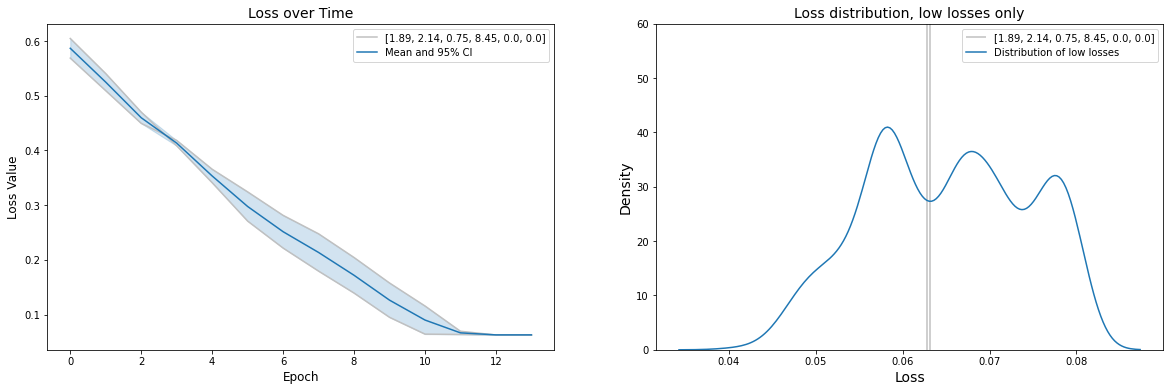

In [20]:
true_landscape = pd.read_csv('../6d_loss_landscape/6d_landscape_sundials.csv')

landscape = true_landscape.loc[true_landscape.theta1 != 100].loc[true_landscape.theta2 != 100]
min_loss = landscape.loss.min()
tolerance = 0.04

low_loss = landscape.loc[landscape.loss < min_loss + tolerance]
min_loss_landscape = landscape.loc[landscape.loss == min_loss]

ci_losses = []
ci_epochs = []
for df in list_of_results: 
    loss = df.loss.to_list()
    epochs = df.index.to_list()
    ci_losses = ci_losses + loss
    ci_epochs = ci_epochs + epochs
ci_df = pd.DataFrame({'loss': ci_losses, 'epoch':ci_epochs})

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'Loss over Time'
ax = axs[0]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.plot(df.loss, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.plot(df.loss, color='silver')
sns.lineplot(data=ci_df, x="epoch", y="loss", label='Mean and 95% CI',ax=ax)
ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)


endpoint = 'Loss distribution, low losses only'
ax = axs[1]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver')
    

    
sns.kdeplot(low_loss.loss, ax=ax, label='Distribution of low losses')

ax.set_ylim([0, 60])
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
#fig.savefig('init_losses_dc_n50.png')


In [22]:
area = np.trapz(list_of_results[1].loss, dx=5)
print("area =", area)

area = 17.61530547885394
